<a href="https://colab.research.google.com/github/dianakorka/statistical_capacity/blob/main/HH_capacity_index_rev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assessing Statistical Capacity to Compile Digital Development Statistics

## HH indicators

### Gathering and preparing data for analysis

I received data 4 different files:
- Household_data_availability_Apr2025.xlsx -> used to get country groupings,
- HH_availability_indicators_10_5.xlsx -> initially used for availability, but no longer used because best to have a single source of truth for availability and timeliness,
- HH Metadata_2015+.xlsx -> used to get most frequent and most recent data source,
- Data_availability_by_indicator_and_year.csv -> used for timeliness and availability.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import geopandas as gpd
import plotly.express as px
import re

In [2]:
file_path = '/content/Household_data_availability_Apr2025.xlsx'

dfs = pd.read_excel(file_path, sheet_name=None)  # Reads all sheets into a dict

This file includes several sheets. I read them all together in one dataset, so I can easily access all series.

In [3]:
for name, df in dfs.items():
    print(f"Sheet: {name}, Shape: {df.shape}")

Sheet: Overall availability, Shape: (238, 4)
Sheet: Availability by indicator, Shape: (187, 26)
Sheet: Availability by disaggregate, Shape: (212, 12)
Sheet: Country definition, Shape: (236, 16)


In [4]:
#df_1 = dfs['Overall availability']
#df_2 = dfs['Availability by indicator']
#df_2.drop(index=0, inplace=True)
#df_3 = dfs['Availability by disaggregate']
df_4 = dfs['Country definition']

In [5]:
#merged_df = pd.merge(df_2, df_3, on='ISO3', how='outer')


In [6]:
#merged_df = pd.merge(df_1, merged_df, how='outer', left_on='Iso3', right_on='ISO3')

In [7]:
#merged_df = pd.merge(df_4, merged_df, left_on='IsoCode', right_on='ISO3', how='outer')

In [8]:
merged_df = df_4

In [9]:
df_4.shape

(236, 16)

In [10]:
# Drop any duplicate column (if it appears several times)
#merged_df.drop(columns=['Iso3', 'Indicator', 'IsoCode', 'Target', 'Country_y', 'Country_x', 'Overall'], inplace=True)

In [11]:
merged_df.columns

Index(['ShortName', 'RegionName', 'CountryType', 'ItuMember', 'LDC', 'LLDC',
       'SIDS', 'M49Region', 'M49SubRegion', 'IsoN3Code', 'IsoCode',
       'Language6', 'WB_Income', 'ITU admin region', 'UMC event region',
       'OECD_member'],
      dtype='object')

In [12]:
merged_df.head()

,ShortName,RegionName,CountryType,ItuMember,LDC,LLDC,SIDS,M49Region,M49SubRegion,IsoN3Code,IsoCode,Language6,WB_Income,ITU admin region,UMC event region,OECD_member
0,Afghanistan,Asia & Pacific,Developing,1,LDC,LLDC,NaN,3.Central Asia (M49) and Southern Asia (MDG=M49),Southern Asia (MDG=M49),4.0,AFG,E,Low income,E,Asia,NaN
1,Albania,Europe countries,Developed,1,NaN,NaN,NaN,1.Northern America (M49) and Europe (M49),Europe (M49),8.0,ALB,E,Upper middle income,C,n.a.,NaN
2,Algeria,Arab States,Developing,1,NaN,NaN,NaN,5.Western Asia (M49) and Northern Africa (M49),Northern Africa (M49),12.0,DZA,A,Lower middle income,D,Arab states,NaN
3,American Samoa,Other Economies,Developing,0,NaN,NaN,SIDS,7.Oceania,Oceania (M49) excl Australia and New Zealand (...,16.0,ASM,E,Upper middle income,NaN,Pacific,NaN
4,Andorra,Europe countries,Developed,1,NaN,NaN,NaN,1.Northern America (M49) and Europe (M49),Europe (M49),20.0,AND,F,High income,B,n.a.,NaN


Read data from the two additional sources.

In [13]:
file_path = '/content/Data_availability_by_indicator_and_year.csv'

df_detailed = pd.read_csv(file_path)

In [14]:
df_detailed.head()

,Country,CountryType,RegionName,Indicator,ItuMember,DataYear
0,Afghanistan,Low Income,Asia & Pacific,HH1,1,2015
1,Afghanistan,Low Income,Asia & Pacific,HH18,1,2016
2,Afghanistan,Low Income,Asia & Pacific,HH2,1,2015
3,Afghanistan,Low Income,Asia & Pacific,HH3,1,2015
4,Afghanistan,Low Income,Asia & Pacific,HH4,1,2015


In [15]:
df_detailed.describe()

,ItuMember,DataYear
count,10231.000000,10231.000000
mean,0.956212,2018.320985
std,0.204634,3.230141
min,0.000000,2013.000000
25%,1.000000,2016.000000
50%,1.000000,2018.000000
75%,1.000000,2021.000000
max,1.000000,2025.000000


Can see above dataset has both itu members and non members and earliest data point is from 2013, latest from 2025.

Need to pivot the data to get it in a one row per country format and to calculate availability: count number of data points per country-indicator in the past 5 years (=restrict data to 2020 or after).

In [16]:
availability = df_detailed[df_detailed.DataYear >= 2020].groupby(['Indicator', 'Country'])['DataYear'].size().reset_index(name='count').pivot(index='Country', columns='Indicator', values='count').reset_index()

# Add suffix to all columns except 'Country'
availability.columns = [col if col == 'Country' else f"{col}_5y" for col in availability.columns]

availability.head()

,Country,HH1_5y,HH10_5y,HH11_5y,HH12_5y,HH13_5y,HH14_5y,HH15_5y,HH16_5y,HH17_5y,...,HH21_5y,HH22_5y,HH23_5y,HH3_5y,HH4_5y,HH5_5y,HH6_5y,HH7_5y,HH8_5y,HH9_5y
0,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
1,Albania,NaN,4.0,4.0,4.0,NaN,4.0,4.0,NaN,4.0,...,NaN,NaN,2.0,NaN,NaN,3.0,4.0,4.0,NaN,4.0
2,Argentina,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,5.0,3.0,5.0,5.0,NaN,NaN
3,Armenia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,...,NaN,NaN,NaN,4.0,4.0,4.0,4.0,4.0,4.0,NaN
4,Austria,NaN,NaN,NaN,3.0,NaN,NaN,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,5.0,5.0,NaN,5.0


Add this to the dataset - how=outer -> keep all observations from both datasets

In [17]:
merged_df = pd.merge(merged_df, availability, left_on='ShortName', right_on='Country', how='outer')

In [18]:
merged_df.shape

(236, 40)

In [19]:
merged_df.head()

,ShortName,RegionName,CountryType,ItuMember,LDC,LLDC,SIDS,M49Region,M49SubRegion,IsoN3Code,...,HH21_5y,HH22_5y,HH23_5y,HH3_5y,HH4_5y,HH5_5y,HH6_5y,HH7_5y,HH8_5y,HH9_5y
0,Afghanistan,Asia & Pacific,Developing,1,LDC,LLDC,NaN,3.Central Asia (M49) and Southern Asia (MDG=M49),Southern Asia (MDG=M49),4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
1,Albania,Europe countries,Developed,1,NaN,NaN,NaN,1.Northern America (M49) and Europe (M49),Europe (M49),8.0,...,NaN,NaN,2.0,NaN,NaN,3.0,4.0,4.0,NaN,4.0
2,Algeria,Arab States,Developing,1,NaN,NaN,NaN,5.Western Asia (M49) and Northern Africa (M49),Northern Africa (M49),12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,American Samoa,Other Economies,Developing,0,NaN,NaN,SIDS,7.Oceania,Oceania (M49) excl Australia and New Zealand (...,16.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Andorra,Europe countries,Developed,1,NaN,NaN,NaN,1.Northern America (M49) and Europe (M49),Europe (M49),20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now obtain timeliness - first identify by country-indicator pair what is the most recent data point available.

Then subtract that reference year from 2025.

In [20]:
df_detailed[df_detailed.DataYear >= 2020].groupby(['Indicator', 'Country'])['DataYear'].max().reset_index().pivot(index='Country', columns='Indicator', values='DataYear').reset_index()


Indicator,Country,HH1,HH10,HH11,HH12,HH13,HH14,HH15,HH16,HH17,...,HH21,HH22,HH23,HH3,HH4,HH5,HH6,HH7,HH8,HH9
0,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2023.0,NaN,NaN,NaN
1,Albania,NaN,2023.0,2023.0,2023.0,NaN,2023.0,2023.0,NaN,2023.0,...,NaN,NaN,2021.0,NaN,NaN,2023.0,2023.0,2023.0,NaN,2023.0
2,Argentina,NaN,2024.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2024.0,2024.0,2024.0,2024.0,NaN,NaN
3,Armenia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023.0,NaN,...,NaN,NaN,NaN,2023.0,2023.0,2023.0,2023.0,2023.0,2023.0,NaN
4,Austria,NaN,NaN,NaN,2024.0,NaN,NaN,2023.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2024.0,2024.0,2024.0,NaN,2024.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,Uruguay,2022.0,2024.0,2024.0,2024.0,2022.0,NaN,2024.0,NaN,2024.0,...,2022.0,NaN,NaN,2022.0,2024.0,2024.0,2024.0,2024.0,2024.0,2024.0
129,Uzbekistan,2022.0,2022.0,2021.0,2022.0,2022.0,2022.0,2023.0,2022.0,2022.0,...,NaN,NaN,NaN,2022.0,2023.0,2022.0,2023.0,2023.0,2022.0,2023.0
130,Vanuatu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2023.0,NaN,NaN,NaN
131,Viet Nam,2024.0,2024.0,2024.0,NaN,NaN,NaN,2024.0,NaN,NaN,...,NaN,NaN,NaN,2024.0,2024.0,NaN,2024.0,2024.0,NaN,2024.0


In [21]:
timeliness = df_detailed[df_detailed.DataYear >= 2020].groupby(['Indicator', 'Country'])['DataYear'].max().reset_index().pivot(index='Country', columns='Indicator', values='DataYear').reset_index()

hh_cols = [f'HH{i}' for i in range(1, 24)]

for col in hh_cols:
    new_col = f'timeliness_{col}'
    timeliness[new_col] = (2025 - timeliness[col]).astype('Int64')

timeliness.head()

Indicator,Country,HH1,HH10,HH11,HH12,HH13,HH14,HH15,HH16,HH17,...,timeliness_HH14,timeliness_HH15,timeliness_HH16,timeliness_HH17,timeliness_HH18,timeliness_HH19,timeliness_HH20,timeliness_HH21,timeliness_HH22,timeliness_HH23
0,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,Albania,NaN,2023.0,2023.0,2023.0,NaN,2023.0,2023.0,NaN,2023.0,...,2,2,<NA>,2,<NA>,<NA>,2,<NA>,<NA>,4
2,Argentina,NaN,2024.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,<NA>,<NA>,<NA>,<NA>,2,<NA>,<NA>,<NA>,<NA>,<NA>
3,Armenia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023.0,NaN,...,<NA>,<NA>,2,<NA>,3,<NA>,<NA>,<NA>,<NA>,<NA>
4,Austria,NaN,NaN,NaN,2024.0,NaN,NaN,2023.0,NaN,NaN,...,<NA>,2,<NA>,<NA>,<NA>,<NA>,1,<NA>,<NA>,<NA>


And add this as well to the merged dataset

In [22]:
timeliness_cols = [f'timeliness_HH{i}' for i in range(1, 24)]

timeliness_cols.extend(['Country'])

merged_df = pd.merge(merged_df, timeliness[timeliness_cols], left_on='ShortName', right_on='Country', how='outer')


merged_df.head()

,ShortName,RegionName,CountryType,ItuMember,LDC,LLDC,SIDS,M49Region,M49SubRegion,IsoN3Code,...,timeliness_HH15,timeliness_HH16,timeliness_HH17,timeliness_HH18,timeliness_HH19,timeliness_HH20,timeliness_HH21,timeliness_HH22,timeliness_HH23,Country_y
0,Afghanistan,Asia & Pacific,Developing,1,LDC,LLDC,NaN,3.Central Asia (M49) and Southern Asia (MDG=M49),Southern Asia (MDG=M49),4.0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,Afghanistan
1,Albania,Europe countries,Developed,1,NaN,NaN,NaN,1.Northern America (M49) and Europe (M49),Europe (M49),8.0,...,2,<NA>,2,<NA>,<NA>,2,<NA>,<NA>,4,Albania
2,Algeria,Arab States,Developing,1,NaN,NaN,NaN,5.Western Asia (M49) and Northern Africa (M49),Northern Africa (M49),12.0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN
3,American Samoa,Other Economies,Developing,0,NaN,NaN,SIDS,7.Oceania,Oceania (M49) excl Australia and New Zealand (...,16.0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN
4,Andorra,Europe countries,Developed,1,NaN,NaN,NaN,1.Northern America (M49) and Europe (M49),Europe (M49),20.0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN


In [23]:

merged_df.shape

(236, 64)

I transform column names, so they are more easily accessible in code.

In [24]:
def clean_column_names(df):
    df.columns = (
        df.columns.str.strip()             # Remove leading/trailing whitespace
                 .str.lower()              # Convert to lowercase
                 .str.replace(' ', '_')    # Replace spaces with underscores
                 .str.replace('  /  ', '_')    # Replace spaces with underscores
                 .str.replace(r'[^\w_]', '', regex=True)  # Remove non-alphanumeric chars
    )
    return df


In [25]:
df = clean_column_names(merged_df)

print(df.columns)

Index(['shortname', 'regionname', 'countrytype', 'itumember', 'ldc', 'lldc',
       'sids', 'm49region', 'm49subregion', 'ison3code', 'isocode',
       'language6', 'wb_income', 'itu_admin_region', 'umc_event_region',
       'oecd_member', 'country_x', 'hh1_5y', 'hh10_5y', 'hh11_5y', 'hh12_5y',
       'hh13_5y', 'hh14_5y', 'hh15_5y', 'hh16_5y', 'hh17_5y', 'hh18_5y',
       'hh19_5y', 'hh2_5y', 'hh20_5y', 'hh21_5y', 'hh22_5y', 'hh23_5y',
       'hh3_5y', 'hh4_5y', 'hh5_5y', 'hh6_5y', 'hh7_5y', 'hh8_5y', 'hh9_5y',
       'timeliness_hh1', 'timeliness_hh2', 'timeliness_hh3', 'timeliness_hh4',
       'timeliness_hh5', 'timeliness_hh6', 'timeliness_hh7', 'timeliness_hh8',
       'timeliness_hh9', 'timeliness_hh10', 'timeliness_hh11',
       'timeliness_hh12', 'timeliness_hh13', 'timeliness_hh14',
       'timeliness_hh15', 'timeliness_hh16', 'timeliness_hh17',
       'timeliness_hh18', 'timeliness_hh19', 'timeliness_hh20',
       'timeliness_hh21', 'timeliness_hh22', 'timeliness_hh23', 'coun

In [26]:
df.shape

(236, 64)

In [27]:
df = df.dropna(how='all')

In [28]:
# remove ITU non members from the getgo.  OPTIONAL

#df = df[df['itumember'] != 0]


In [29]:
n_countries= df.shortname.nunique()
n_itu_members = df[df['itumember'] != 0].shape[0]
n_non_iti_members = df[df['itumember'] == 0].shape[0]

print(f"This dataset includes data for {n_countries}, {n_itu_members} ITU members.")

This dataset includes data for 236, 193 ITU members.


In [30]:
# just checking that missing values are not encoded as 0s
df.hh1_5y.isna().sum()

np.int64(191)

In [31]:
# inspect data for one country
hh_cols = [f'hh{i}_5y' for i in range(1, 24)]

df[df['shortname']=='Afghanistan'][hh_cols]

,hh1_5y,hh2_5y,hh3_5y,hh4_5y,hh5_5y,hh6_5y,hh7_5y,hh8_5y,hh9_5y,hh10_5y,...,hh14_5y,hh15_5y,hh16_5y,hh17_5y,hh18_5y,hh19_5y,hh20_5y,hh21_5y,hh22_5y,hh23_5y
0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
df_detailed[df_detailed.Country == 'Afghanistan']

,Country,CountryType,RegionName,Indicator,ItuMember,DataYear
0,Afghanistan,Low Income,Asia & Pacific,HH1,1,2015
1,Afghanistan,Low Income,Asia & Pacific,HH18,1,2016
2,Afghanistan,Low Income,Asia & Pacific,HH2,1,2015
3,Afghanistan,Low Income,Asia & Pacific,HH3,1,2015
4,Afghanistan,Low Income,Asia & Pacific,HH4,1,2015
5,Afghanistan,Low Income,Asia & Pacific,HH5,1,2016
6,Afghanistan,Low Income,Asia & Pacific,HH6,1,2023


In the previous 5 years Afghanistan had data for one indicator HH6 in 2023. The other data points are more than 5 years old.

## DESCRIPTION

data_in_past_5_years = number of years data was available in the part 5 years for country I, indicator J. Number of times data was available in the past 5 years (2020-2024) for country I, indicator J.

Regrouping countries according to Jose's request.

In [33]:
# we need to do some regrouping of countries
def assign_group(row):
    if row['oecd_member'] == 1:
        return 'Developed-OECD'
    elif (row['sids'] == 'SIDS') or (row['ldc'] == 'LDC'):
    #or (row['lldc'] == 'LLDC'):
        return 'SIDS + LDC'
    else:
        return 'Other developing and transition'

df['new_group'] = df.apply(assign_group, axis=1)


In [34]:
df['new_group'].value_counts()

,count
new_group,
Other developing and transition,110
SIDS + LDC,88
Developed-OECD,38


In [35]:
df.wb_income.value_counts()

,count
wb_income,
High income,79
Upper middle income,54
Lower middle income,54
Low income,28


In [36]:
df.regionname.value_counts()

,count
regionname,
Europe countries,46
Africa,44
Asia & Pacific,40
Other Economies,38
The Americas,35
Arab States,21
CIS countries,9


A quick look at what does the country data look like for HH2.

In [37]:
df[['shortname','hh2_5y']].sort_values(by='hh2_5y', ascending=False)
## check that we still have the NAs

,shortname,hh2_5y
19,Belarus,5.0
28,Brazil,5.0
98,Indonesia,5.0
138,Moldova,5.0
167,Peru,5.0
...,...,...
229,Venezuela,NaN
231,Virgin Islands (US),NaN
232,Wallis and Futuna,NaN
233,Yemen,NaN


## Availability charts

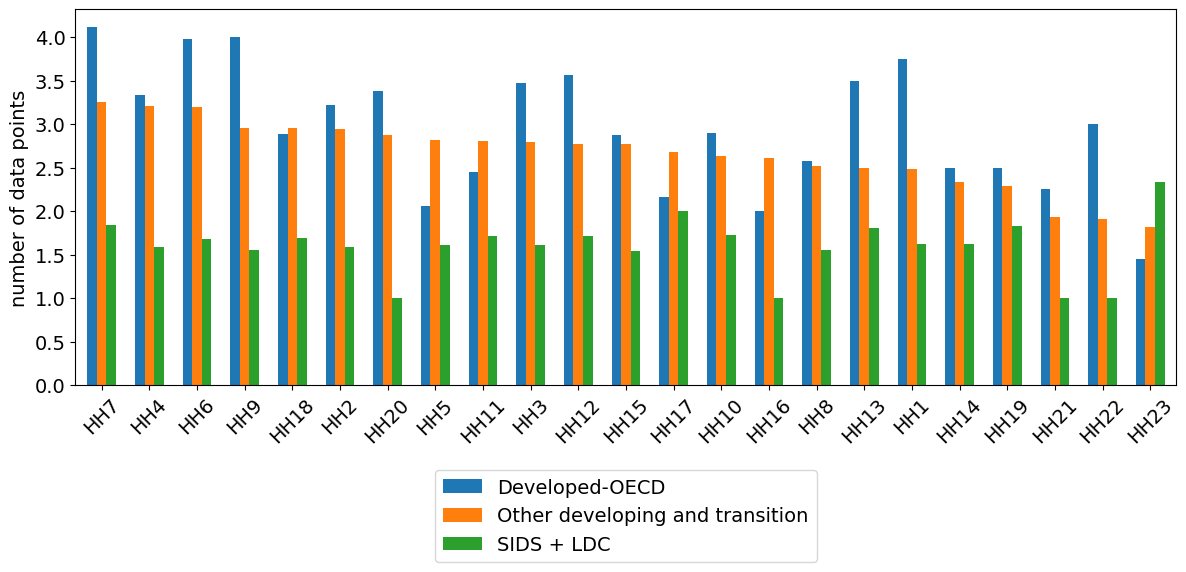

In [38]:
rename_dict = {
    'hh1_5y': 'HH1','hh2_5y': 'HH2','hh3_5y': 'HH3','hh4_5y': 'HH4','hh5_5y': 'HH5',
    'hh6_5y': 'HH6','hh7_5y': 'HH7','hh8_5y': 'HH8','hh9_5y': 'HH9','hh10_5y': 'HH10',
    'hh11_5y': 'HH11','hh12_5y': 'HH12','hh13_5y': 'HH13','hh14_5y': 'HH14','hh15_5y': 'HH15',
    'hh16_5y': 'HH16','hh17_5y': 'HH17','hh18_5y': 'HH18','hh19_5y': 'HH19','hh20_5y': 'HH20',
    'hh21_5y': 'HH21','hh22_5y': 'HH22','hh23_5y': 'HH23',
}

# Define your custom order
custom_order = ['Developed-OECD', 'Other developing and transition', 'SIDS + LDC']

df[['new_group','hh1_5y','hh2_5y','hh3_5y','hh4_5y','hh5_5y','hh6_5y','hh7_5y','hh8_5y',
 'hh9_5y','hh10_5y','hh11_5y','hh12_5y','hh13_5y','hh14_5y','hh15_5y','hh16_5y',
 'hh17_5y','hh18_5y','hh19_5y','hh20_5y','hh21_5y','hh22_5y','hh23_5y']].rename(
     columns=rename_dict).groupby('new_group').mean(numeric_only=True).T.sort_values(
     by='Other developing and transition', ascending=False)[custom_order].plot(kind='bar',
                                                                              figsize=(12, 6),
                                                                              width=0.6)
#plt.title('Average number of data points per indicator in the past 5 years (2020-2024)')
plt.xlabel('')
plt.ylabel('number of data points',fontsize=14)
plt.xticks(rotation=45,fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')

# Step 1: Get current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Step 2: Create a dict for easy lookup
label_to_handle = dict(zip(labels, handles))

# Step 3: Reconstruct the legend using custom order
plt.legend(
    [label_to_handle[label] for label in custom_order],
    custom_order,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.2),
    ncol=1,
    fontsize=14
)
plt.tight_layout()
plt.show()

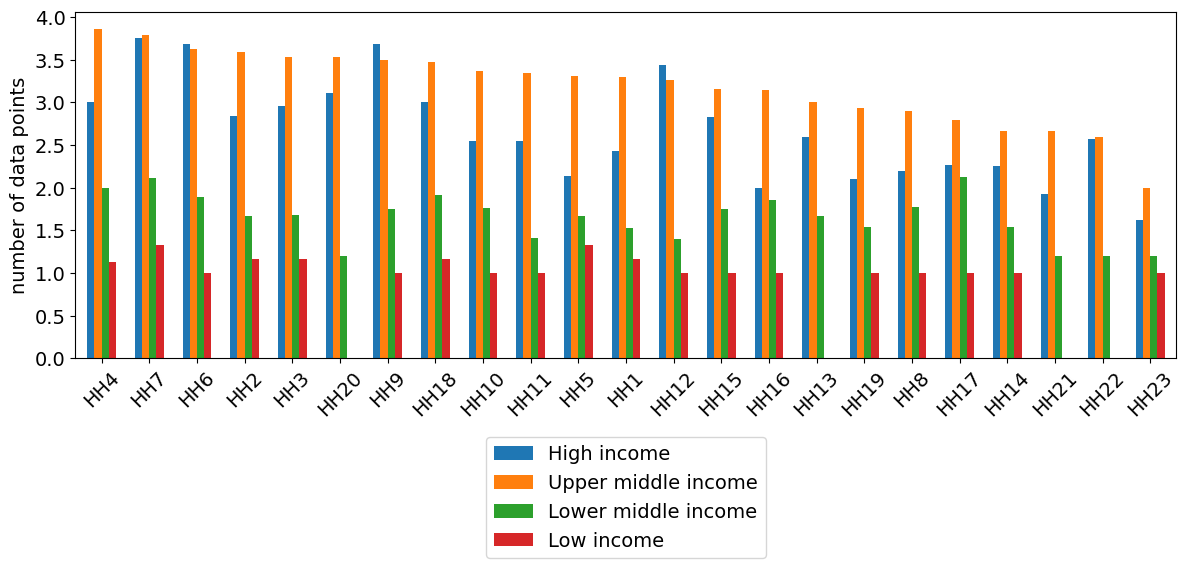

In [39]:
rename_dict = {
    'hh1_5y': 'HH1','hh2_5y': 'HH2','hh3_5y': 'HH3','hh4_5y': 'HH4','hh5_5y': 'HH5',
    'hh6_5y': 'HH6','hh7_5y': 'HH7','hh8_5y': 'HH8','hh9_5y': 'HH9','hh10_5y': 'HH10',
    'hh11_5y': 'HH11','hh12_5y': 'HH12','hh13_5y': 'HH13','hh14_5y': 'HH14','hh15_5y': 'HH15',
    'hh16_5y': 'HH16','hh17_5y': 'HH17','hh18_5y': 'HH18','hh19_5y': 'HH19','hh20_5y': 'HH20',
    'hh21_5y': 'HH21','hh22_5y': 'HH22','hh23_5y': 'HH23',
}

# Define your custom order
custom_order = ['High income', 'Upper middle income', 'Lower middle income', 'Low income']

df[['wb_income','hh1_5y','hh2_5y','hh3_5y','hh4_5y','hh5_5y','hh6_5y','hh7_5y','hh8_5y',
 'hh9_5y','hh10_5y','hh11_5y','hh12_5y','hh13_5y','hh14_5y','hh15_5y','hh16_5y',
 'hh17_5y','hh18_5y','hh19_5y','hh20_5y','hh21_5y','hh22_5y','hh23_5y']].rename(
     columns=rename_dict).groupby('wb_income').mean(numeric_only=True).T.sort_values(
     by='Upper middle income', ascending=False)[custom_order].plot(kind='bar',
                                                                              figsize=(12, 6),
                                                                              width=0.6)
#plt.title('Average number of data points per indicator in the past 5 years (2020-2024)')
plt.xlabel('')
plt.ylabel('number of data points',fontsize=14)
plt.xticks(rotation=45,fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')

# Step 1: Get current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Step 2: Create a dict for easy lookup
label_to_handle = dict(zip(labels, handles))

# Step 3: Reconstruct the legend using custom order
plt.legend(
    [label_to_handle[label] for label in custom_order],
    custom_order,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.2),
    ncol=1,
    fontsize=14
)
plt.tight_layout()
plt.show()

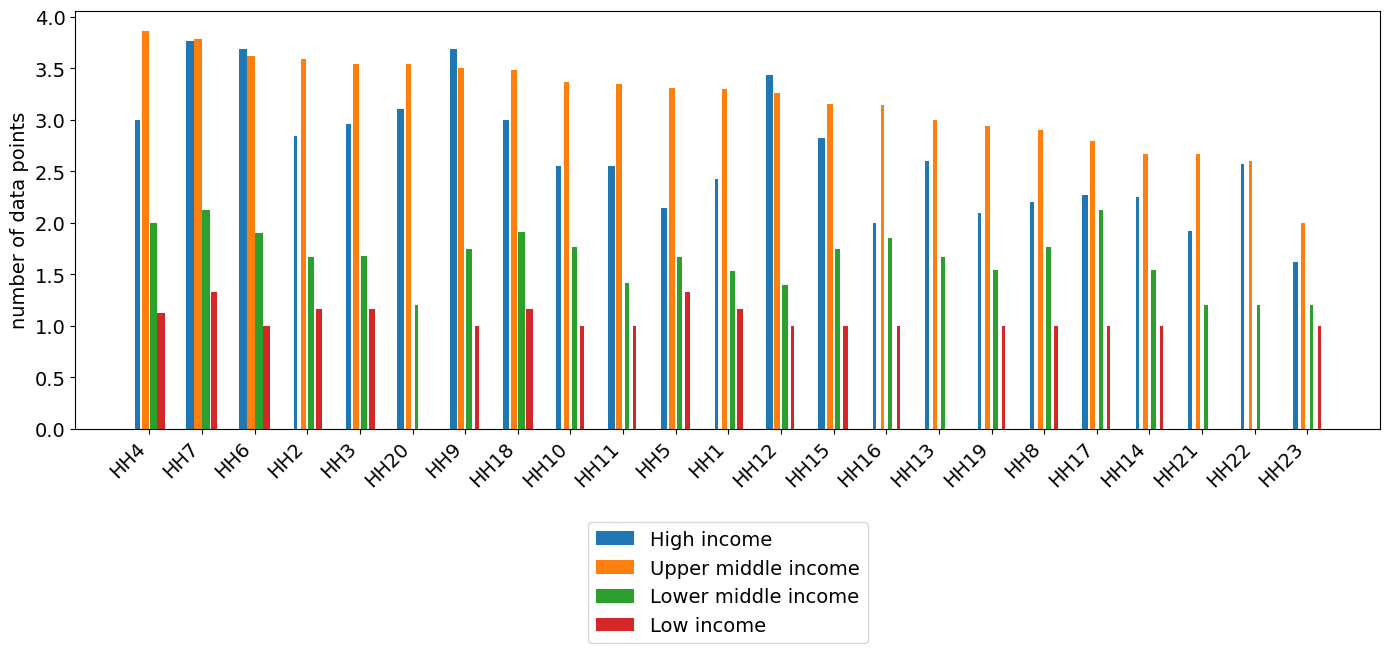

In [40]:
from matplotlib.patches import Patch

rename_dict = {
    'hh1_5y': 'HH1','hh2_5y': 'HH2','hh3_5y': 'HH3','hh4_5y': 'HH4','hh5_5y': 'HH5',
    'hh6_5y': 'HH6','hh7_5y': 'HH7','hh8_5y': 'HH8','hh9_5y': 'HH9','hh10_5y': 'HH10',
    'hh11_5y': 'HH11','hh12_5y': 'HH12','hh13_5y': 'HH13','hh14_5y': 'HH14','hh15_5y': 'HH15',
    'hh16_5y': 'HH16','hh17_5y': 'HH17','hh18_5y': 'HH18','hh19_5y': 'HH19','hh20_5y': 'HH20',
    'hh21_5y': 'HH21','hh22_5y': 'HH22','hh23_5y': 'HH23',
}

# Define your custom order
custom_order = ['High income', 'Upper middle income', 'Lower middle income', 'Low income']

subset = df[['wb_income','hh1_5y','hh2_5y','hh3_5y','hh4_5y','hh5_5y','hh6_5y','hh7_5y','hh8_5y',
 'hh9_5y','hh10_5y','hh11_5y','hh12_5y','hh13_5y','hh14_5y','hh15_5y','hh16_5y',
 'hh17_5y','hh18_5y','hh19_5y','hh20_5y','hh21_5y','hh22_5y','hh23_5y']].rename(columns=rename_dict)

# Calculate means and counts
means = subset.groupby('wb_income').mean(numeric_only=True).T
counts = subset.groupby('wb_income').count().T

# Sort by Upper middle income
means_sorted = means.sort_values(by='Upper middle income', ascending=False)[custom_order]
counts_sorted = counts.loc[means_sorted.index][custom_order]

# Set width factor range
min_width_factor = 0.3
max_width_factor = 1.0

# Create figure
fig, ax = plt.subplots(figsize=(14, 6))

# Plot each income group separately to control width
x = np.arange(len(means_sorted.index))
base_width = 0.6 / len(custom_order)

# Store colors for legend
colors = [f'C{i}' for i in range(len(custom_order))]

for i, income_group in enumerate(custom_order):
    # Calculate width for each bar WITHIN THIS GROUP
    group_max_count = counts_sorted[income_group].max()

    # Normalize within the group
    width_factors = counts_sorted[income_group] / group_max_count * (max_width_factor - min_width_factor) + min_width_factor

    # Plot bars with individual widths
    for j, (indicator, value) in enumerate(means_sorted[income_group].items()):
        bar_width = base_width * width_factors.iloc[j]
        bar_x = x[j] + i * base_width - (len(custom_order) - 1) * base_width / 2

        ax.bar(
            bar_x,
            value,
            bar_width,
            color=colors[i]
        )

        # Add text label on top of bar
        #count = int(counts_sorted[income_group].iloc[j])
        #if count > 0:
           # ax.text(
               # bar_x,
               # value,
               # f'n={count}',
               # ha='center',
               # va='bottom',
               # fontsize=9,
               # rotation=0
            #)

ax.set_xlabel('', fontsize=14)
ax.set_ylabel('number of data points', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(means_sorted.index, rotation=45, fontsize=14, ha='right')
ax.tick_params(axis='y', labelsize=14)

# Create custom legend
legend_handles = [Patch(facecolor=colors[i], label=income_group)
                  for i, income_group in enumerate(custom_order)]

plt.subplots_adjust(bottom=0.7)
plt.legend(
    handles=legend_handles,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.2),
    ncol=1,
    fontsize=14
)

plt.tight_layout()
plt.show()

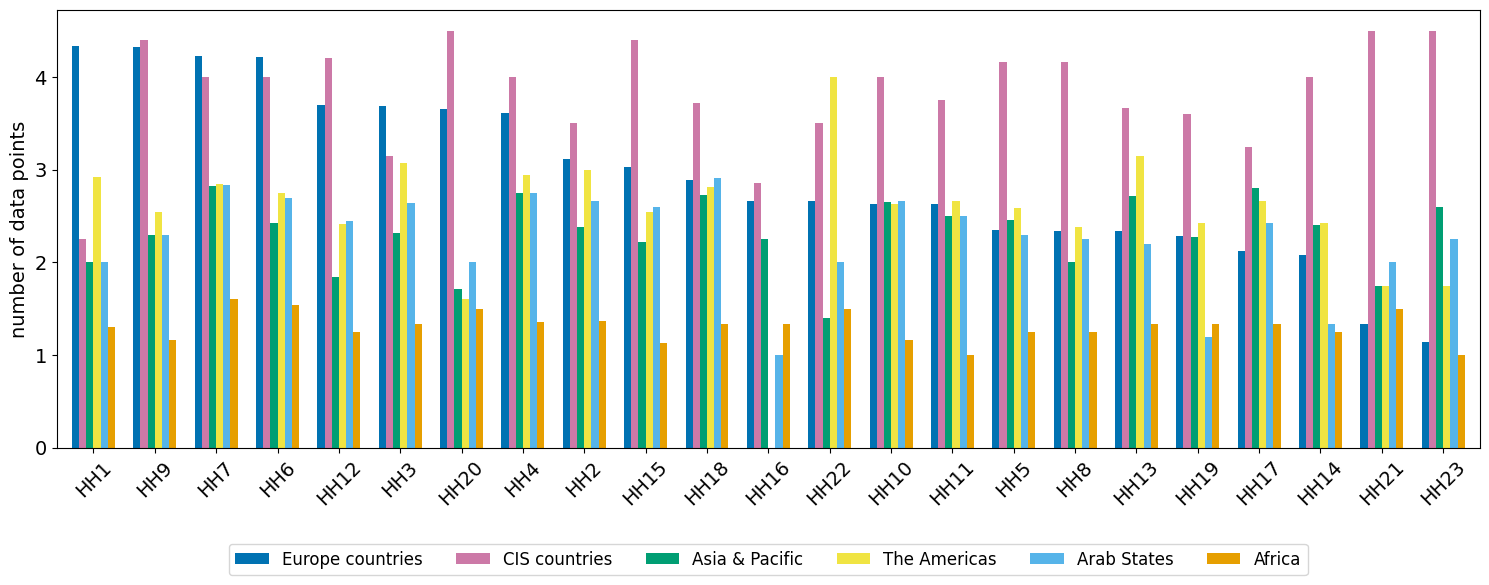

In [41]:
# Define your custom order
custom_order = ['Europe countries','CIS countries', 'Asia & Pacific', 'The Americas', 'Arab States', 'Africa']
#, 'Other Economies']

custom_colors = [
    '#0072B2',  # Blue
    '#CC79A7',  # Pink/Purple
    '#009E73',  # Green
    '#F0E442',  # Yellow
    '#56B4E9',  # Light Blue
    '#E69F00'  # Orange
    #'#696969'
    #'#999999',   # Grey
    ]

rename_dict = {
    'hh1_5y': 'HH1','hh2_5y': 'HH2','hh3_5y': 'HH3','hh4_5y': 'HH4','hh5_5y': 'HH5',
    'hh6_5y': 'HH6','hh7_5y': 'HH7','hh8_5y': 'HH8','hh9_5y': 'HH9','hh10_5y': 'HH10',
    'hh11_5y': 'HH11','hh12_5y': 'HH12','hh13_5y': 'HH13','hh14_5y': 'HH14','hh15_5y': 'HH15',
    'hh16_5y': 'HH16','hh17_5y': 'HH17','hh18_5y': 'HH18','hh19_5y': 'HH19','hh20_5y': 'HH20',
    'hh21_5y': 'HH21','hh22_5y': 'HH22','hh23_5y': 'HH23',
}

df[['regionname','hh1_5y','hh2_5y','hh3_5y','hh4_5y','hh5_5y','hh6_5y','hh7_5y','hh8_5y',
 'hh9_5y','hh10_5y','hh11_5y','hh12_5y','hh13_5y','hh14_5y','hh15_5y','hh16_5y',
 'hh17_5y','hh18_5y','hh19_5y','hh20_5y','hh21_5y','hh22_5y','hh23_5y']].rename(
     columns=rename_dict).groupby('regionname').mean(numeric_only=True).reindex(custom_order).T.sort_values(by='Europe countries', ascending=False).plot(kind='bar',
                                                  figsize=(15, 6),
                                                  color=custom_colors,
                                                  width=0.7)
#plt.title('Average number of data points per indicator in the past 5 years (2020-2024)')
plt.xlabel('')
plt.ylabel('number of data points', fontsize=14)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')

# Step 1: Get current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Step 2: Create a dict for easy lookup
label_to_handle = dict(zip(labels, handles))

# Step 3: Reconstruct the legend using custom order
plt.legend(
    [label_to_handle[label] for label in custom_order],
    custom_order,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.2),
    ncol=7,
    fontsize=12
)

plt.tight_layout()
plt.show()

## Apply a transformation so that we group indicators by type that is relevant for assessing capacity

In [42]:
# define groups of indicators

entry_household = ['hh1', 'hh2', 'hh3', 'hh4', 'hh6']
entry_individual = ['hh5', 'hh7', 'hh10', 'hh18']
disaggregated_household = ['hh11', 'hh14']
disaggregated_individual = ['hh8', 'hh9', 'hh12', 'hh13', 'hh15', 'hh17', 'hh19', 'hh20', 'hh21', 'hh22' 'hh23']
expenditure = ['hh16']

HH1_5y shows how many times the data was available in the 5 year period. HH2_5y shows how many times data was available for this indicator in the 5 year period. So I take the maximum of the two to say how many times data was available for the group in the last 5 years.

In [43]:
groups = {
    'entry_household': entry_household,
    'entry_individual': entry_individual,
    'disaggregated_household': disaggregated_household,
    'disaggregated_individual': disaggregated_individual,
    'expenditure': expenditure
}

for new_col, base_cols in groups.items():
    matching_cols = [f"{b}_5y" for b in base_cols if f"{b}_5y" in df.columns]
    df[f"{new_col}_5y"] = df[matching_cols].max(axis=1)


In [44]:
df.entry_household_5y.describe()

,entry_household_5y
count,127.000000
mean,3.086614
std,1.666779
min,1.000000
25%,1.000000
50%,4.000000
75%,5.000000
max,5.000000


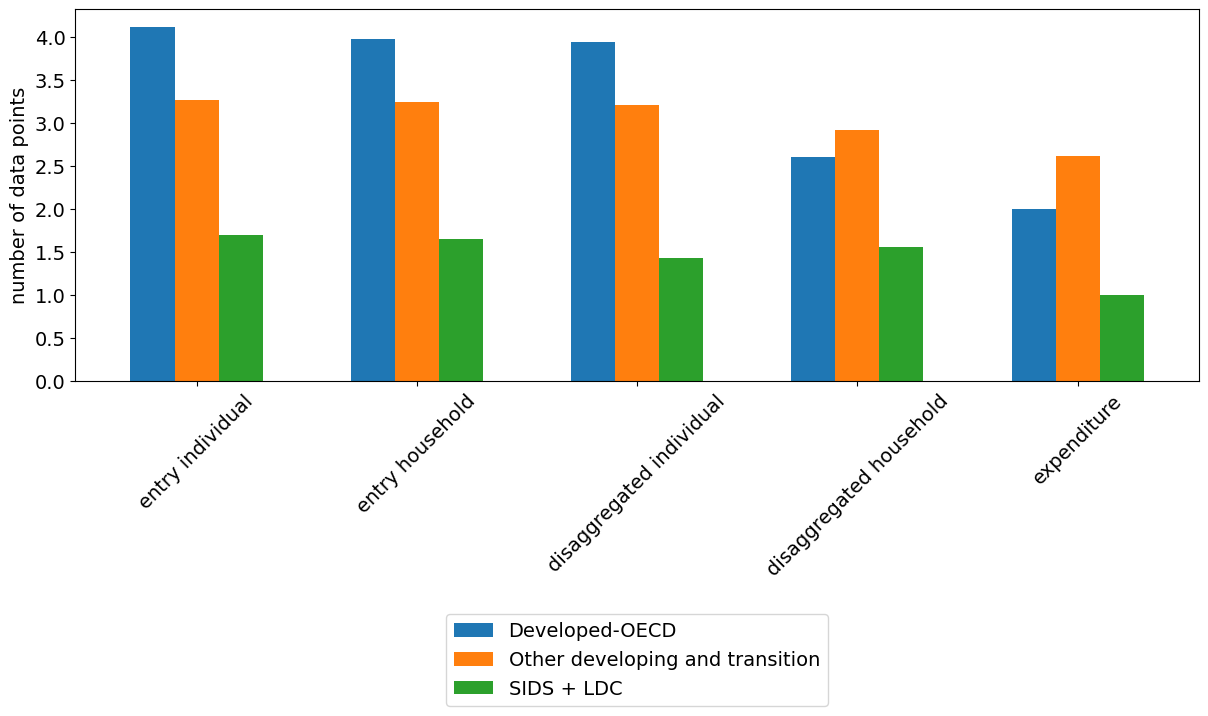

In [45]:
rename_dict = {
    'entry_household_5y': 'entry household',
    'entry_individual_5y': 'entry individual',
    'disaggregated_household_5y': 'disaggregated household',
    'disaggregated_individual_5y': 'disaggregated individual',
    'expenditure_5y': 'expenditure',
}

# Define your custom order
custom_order = ['Developed-OECD', 'Other developing and transition', 'SIDS + LDC']

df[['new_group', 'entry_household_5y',
    'entry_individual_5y',
    'disaggregated_household_5y',
    'disaggregated_individual_5y',
    'expenditure_5y']].rename(
     columns=rename_dict).groupby('new_group').mean(numeric_only=True).T.sort_values(
     by='Other developing and transition', ascending=False)[custom_order].plot(kind='bar',
                                                                              figsize=(12, 6),
                                                                              width=0.6)
#plt.title('Average number of data points per group of indicator in the past 5 years (2020-2024)')
plt.xlabel('')
plt.ylabel('number of data points',fontsize=14)
plt.xticks(rotation=45,fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')

# Step 1: Get current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Step 2: Create a dict for easy lookup
label_to_handle = dict(zip(labels, handles))

# Make more room at the bottom
plt.subplots_adjust(bottom=0.7)  # increase as needed

# Step 3: Reconstruct the legend using custom order
plt.legend(
    [label_to_handle[label] for label in custom_order],
    custom_order,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.6),
    ncol=1,
    fontsize=14
)
plt.tight_layout()
plt.show()

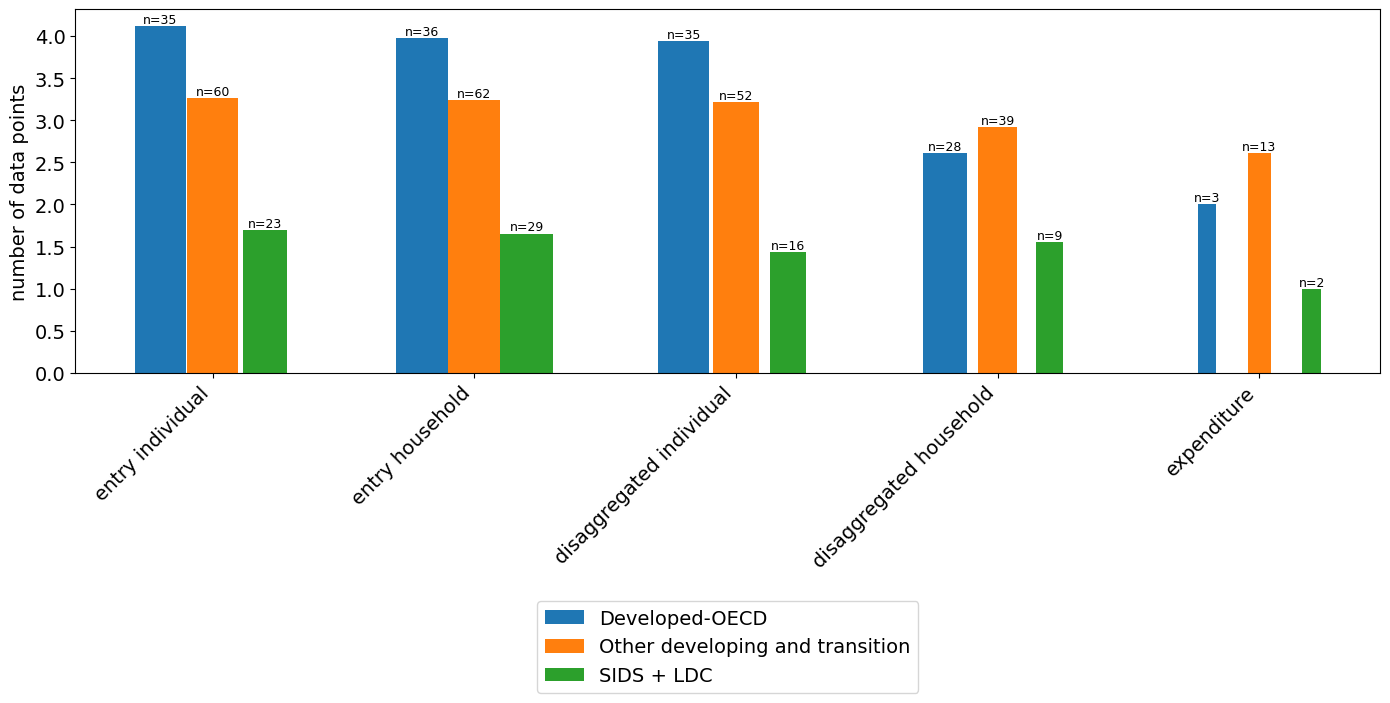

In [46]:
from matplotlib.patches import Patch

rename_dict = {
    'entry_household_5y': 'entry household',
    'entry_individual_5y': 'entry individual',
    'disaggregated_household_5y': 'disaggregated household',
    'disaggregated_individual_5y': 'disaggregated individual',
    'expenditure_5y': 'expenditure',
}

# Define your custom order
custom_order = ['Developed-OECD', 'Other developing and transition', 'SIDS + LDC']

subset = df[['new_group','entry_household_5y',
'entry_individual_5y',
'disaggregated_household_5y',
'disaggregated_individual_5y',
'expenditure_5y']].rename(columns=rename_dict)

# Calculate means and counts
means = subset.groupby('new_group').mean(numeric_only=True).T
counts = subset.groupby('new_group').count().T

# Sort by Upper middle income
means_sorted = means.sort_values(by='Other developing and transition', ascending=False)[custom_order]
counts_sorted = counts.loc[means_sorted.index][custom_order]

# Set width factor range
min_width_factor = 0.3
max_width_factor = 1.0

# Create figure
fig, ax = plt.subplots(figsize=(14, 6))

# Plot each income group separately to control width
x = np.arange(len(means_sorted.index))
base_width = 0.6 / len(custom_order)

# Store colors for legend
colors = [f'C{i}' for i in range(len(custom_order))]

for i, income_group in enumerate(custom_order):
    # Calculate width for each bar WITHIN THIS GROUP
    group_max_count = counts_sorted[income_group].max()

    # Normalize within the group
    width_factors = counts_sorted[income_group] / group_max_count * (max_width_factor - min_width_factor) + min_width_factor

    # Plot bars with individual widths
    for j, (indicator, value) in enumerate(means_sorted[income_group].items()):
        bar_width = base_width * width_factors.iloc[j]
        bar_x = x[j] + i * base_width - (len(custom_order) - 1) * base_width / 2

        ax.bar(
            bar_x,
            value,
            bar_width,
            color=colors[i]
        )

        # Add text label on top of bar
        count = int(counts_sorted[income_group].iloc[j])
        if count > 0:
            ax.text(
                bar_x,
                value,
                f'n={count}',
                ha='center',
                va='bottom',
                fontsize=9,
                rotation=0
            )

ax.set_xlabel('', fontsize=14)
ax.set_ylabel('number of data points', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(means_sorted.index, rotation=45, fontsize=14, ha='right')
ax.tick_params(axis='y', labelsize=14)

# Create custom legend
legend_handles = [Patch(facecolor=colors[i], label=income_group)
                  for i, income_group in enumerate(custom_order)]

plt.subplots_adjust(bottom=0.7)
plt.legend(
    handles=legend_handles,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.6),
    ncol=1,
    fontsize=14
)

plt.tight_layout()
plt.show()

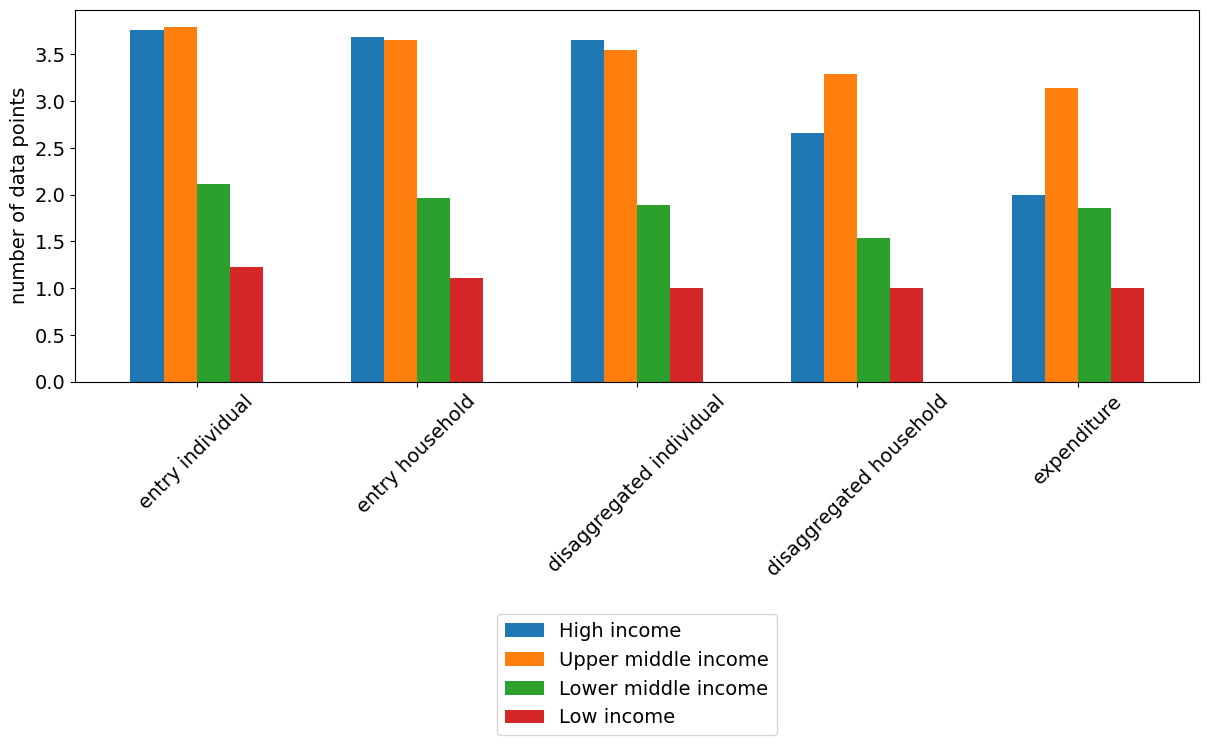

In [47]:

rename_dict = {
    'entry_household_5y': 'entry household',
    'entry_individual_5y': 'entry individual',
    'disaggregated_household_5y': 'disaggregated household',
    'disaggregated_individual_5y': 'disaggregated individual',
    'expenditure_5y': 'expenditure',
}

# Define your custom order
custom_order = ['High income', 'Upper middle income', 'Lower middle income', 'Low income']

df[['wb_income','entry_household_5y',
    'entry_individual_5y',
    'disaggregated_household_5y',
    'disaggregated_individual_5y',
    'expenditure_5y'
 ]].rename(columns=rename_dict).groupby('wb_income').mean(numeric_only=True).T.sort_values(
     by='Upper middle income', ascending=False)[custom_order].plot(kind='bar',
                                                figsize=(12, 6),
                                                width=0.6)
#plt.title('Average number of data points per group of indicator in the past 5 years (2020-2024)')
plt.xlabel('')
plt.ylabel('number of data points', fontsize=14)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.legend(title='', loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=1) # places legend bottom

# Step 1: Get current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Step 2: Create a dict for easy lookup
label_to_handle = dict(zip(labels, handles))

# Make more room at the bottom
plt.subplots_adjust(bottom=0.7)  # increase as needed

# Step 3: Reconstruct the legend using custom order
plt.legend(
    [label_to_handle[label] for label in custom_order],
    custom_order,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.6),
    ncol=1,
    fontsize=14
)
plt.tight_layout()
plt.show()

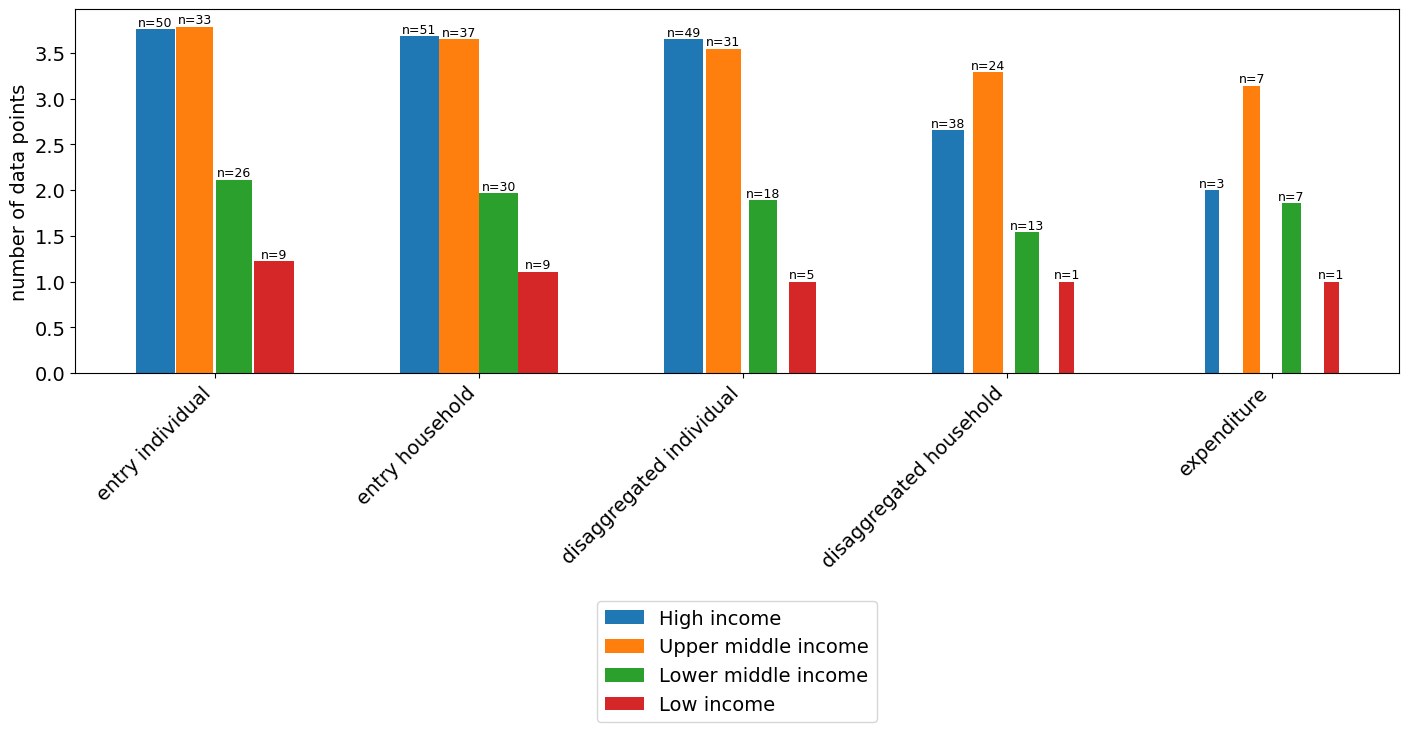

In [48]:
from matplotlib.patches import Patch

rename_dict = {
    'entry_household_5y': 'entry household',
    'entry_individual_5y': 'entry individual',
    'disaggregated_household_5y': 'disaggregated household',
    'disaggregated_individual_5y': 'disaggregated individual',
    'expenditure_5y': 'expenditure',
}

# Define your custom order
custom_order = ['High income', 'Upper middle income', 'Lower middle income', 'Low income']

subset = df[['wb_income','entry_household_5y',
'entry_individual_5y',
'disaggregated_household_5y',
'disaggregated_individual_5y',
'expenditure_5y']].rename(columns=rename_dict)

# Calculate means and counts
means = subset.groupby('wb_income').mean(numeric_only=True).T
counts = subset.groupby('wb_income').count().T

# Sort by Upper middle income
means_sorted = means.sort_values(by='Upper middle income', ascending=False)[custom_order]
counts_sorted = counts.loc[means_sorted.index][custom_order]

# Set width factor range
min_width_factor = 0.3
max_width_factor = 1.0

# Create figure
fig, ax = plt.subplots(figsize=(14, 6))

# Plot each income group separately to control width
x = np.arange(len(means_sorted.index))
base_width = 0.6 / len(custom_order)

# Store colors for legend
colors = [f'C{i}' for i in range(len(custom_order))]

for i, income_group in enumerate(custom_order):
    # Calculate width for each bar WITHIN THIS GROUP
    group_max_count = counts_sorted[income_group].max()

    # Normalize within the group
    width_factors = counts_sorted[income_group] / group_max_count * (max_width_factor - min_width_factor) + min_width_factor

    # Plot bars with individual widths
    for j, (indicator, value) in enumerate(means_sorted[income_group].items()):
        bar_width = base_width * width_factors.iloc[j]
        bar_x = x[j] + i * base_width - (len(custom_order) - 1) * base_width / 2

        ax.bar(
            bar_x,
            value,
            bar_width,
            color=colors[i]
        )

        # Add text label on top of bar
        count = int(counts_sorted[income_group].iloc[j])
        if count > 0:
            ax.text(
                bar_x,
                value,
                f'n={count}',
                ha='center',
                va='bottom',
                fontsize=9,
                rotation=0
            )

ax.set_xlabel('', fontsize=14)
ax.set_ylabel('number of data points', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(means_sorted.index, rotation=45, fontsize=14, ha='right')
ax.tick_params(axis='y', labelsize=14)

# Create custom legend
legend_handles = [Patch(facecolor=colors[i], label=income_group)
                  for i, income_group in enumerate(custom_order)]

plt.subplots_adjust(bottom=0.7)
plt.legend(
    handles=legend_handles,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.6),
    ncol=1,
    fontsize=14
)

plt.tight_layout()
plt.show()

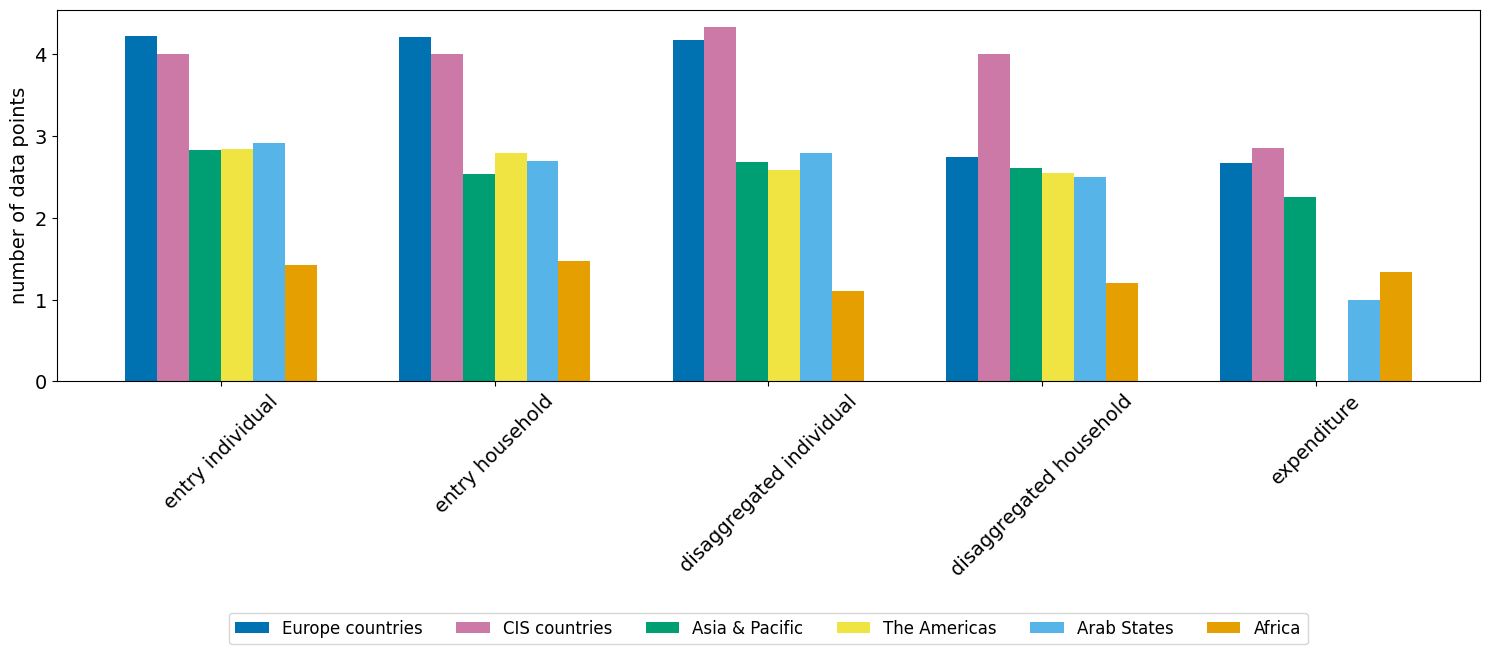

In [49]:
# Define your custom order
custom_order = ['Europe countries','CIS countries', 'Asia & Pacific', 'The Americas', 'Arab States', 'Africa']

custom_colors = [
    '#0072B2',  # Blue
    '#CC79A7',  # Pink/Purple
    '#009E73',  # Green
    '#F0E442',  # Yellow
    '#56B4E9',  # Light Blue
    '#E69F00'#,  # Orange
    #'#696969'
    #'#999999',   # Grey
    ]

rename_dict = {
    'entry_household_5y': 'entry household',
    'entry_individual_5y': 'entry individual',
    'disaggregated_household_5y': 'disaggregated household',
    'disaggregated_individual_5y': 'disaggregated individual',
    'expenditure_5y': 'expenditure',
}

df[['regionname','entry_household_5y',
    'entry_individual_5y',
    'disaggregated_household_5y',
    'disaggregated_individual_5y',
    'expenditure_5y']].rename(
     columns=rename_dict).groupby('regionname').mean(numeric_only=True).reindex(custom_order).T.sort_values(
     by='Europe countries', ascending=False).plot(kind='bar',
                                                  figsize=(15, 6),
                                                  color=custom_colors,
                                                  width=0.7)

#plt.title('Average number of data points per group of indicator in the past 5 years (2020-2024)')
plt.xlabel('')
plt.ylabel('number of data points',fontsize=14)
plt.xticks(rotation=45,fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')

# Step 1: Get current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Step 2: Create a dict for easy lookup
label_to_handle = dict(zip(labels, handles))

# Make more room at the bottom
plt.subplots_adjust(bottom=0.7)  # increase as needed

# Step 3: Reconstruct the legend using custom order
plt.legend(
    [label_to_handle[label] for label in custom_order],
    custom_order,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.6),
    ncol=7,
    fontsize=12
)

plt.tight_layout()
plt.show()

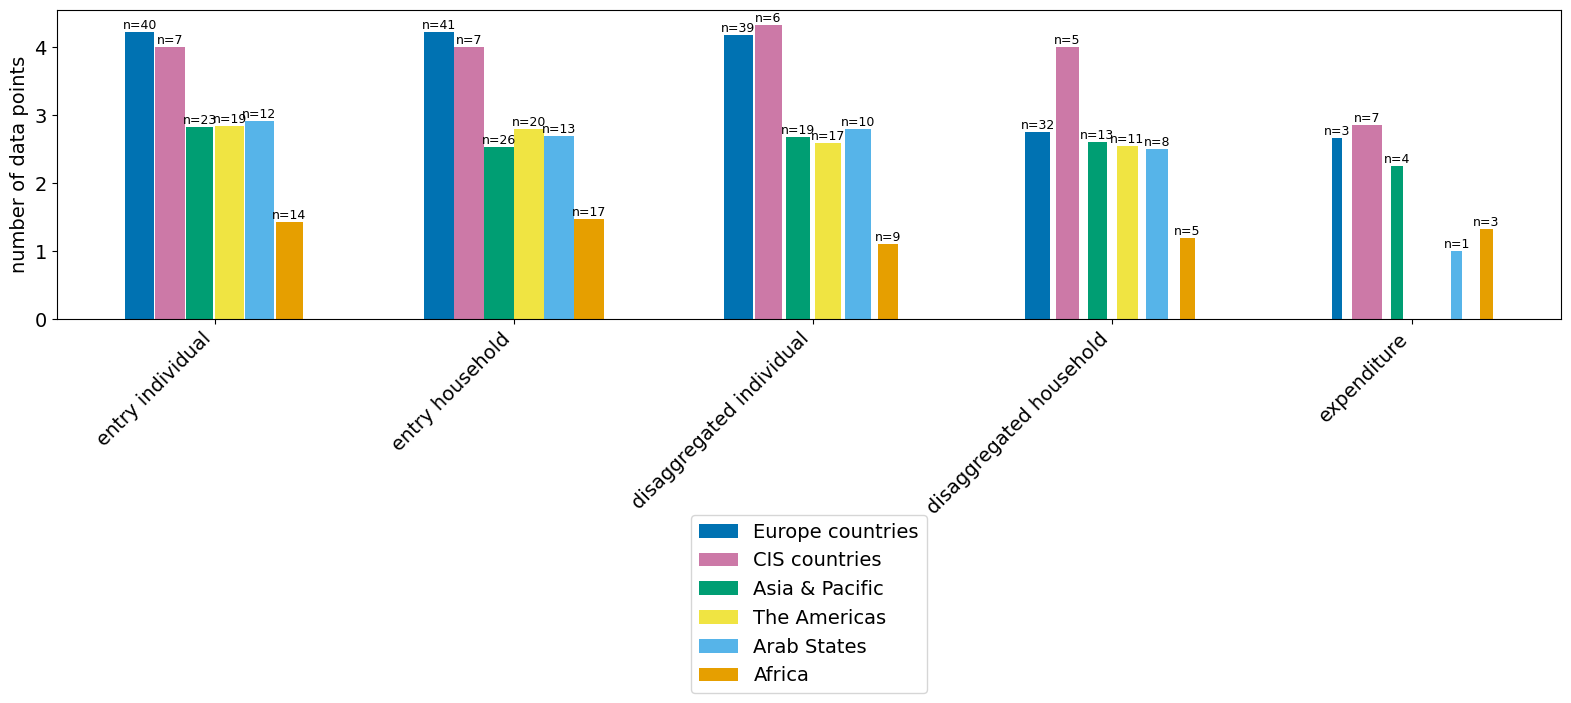

In [50]:
rename_dict = {
'entry_household_5y': 'entry household',
'entry_individual_5y': 'entry individual',
'disaggregated_household_5y': 'disaggregated household',
'disaggregated_individual_5y': 'disaggregated individual',
'expenditure_5y': 'expenditure',
}
# Define your custom order
custom_order = ['Europe countries','CIS countries', 'Asia & Pacific', 'The Americas', 'Arab States', 'Africa']
custom_colors = [
'#0072B2',  # Blue
'#CC79A7',  # Pink/Purple
'#009E73',  # Green
'#F0E442',  # Yellow
'#56B4E9',  # Light Blue
'#E69F00'   # Orange
]

subset = df[['regionname','entry_household_5y',
'entry_individual_5y',
'disaggregated_household_5y',
'disaggregated_individual_5y',
'expenditure_5y']].rename(columns=rename_dict)

# Calculate means and counts
means = subset.groupby('regionname').mean(numeric_only=True).T
counts = subset.groupby('regionname').count().T

# Sort by Europe countries
means_sorted = means.sort_values(by='Europe countries', ascending=False)[custom_order]
counts_sorted = counts.loc[means_sorted.index][custom_order]

# Set width factor range
min_width_factor = 0.3
max_width_factor = 1.0

# Create figure
fig, ax = plt.subplots(figsize=(16, 6))

# Plot each region separately to control width
x = np.arange(len(means_sorted.index))
base_width = 0.6 / len(custom_order)

for i, region in enumerate(custom_order):
    # Calculate width for each bar WITHIN THIS GROUP
    group_max_count = counts_sorted[region].max()

    # Normalize within the group
    width_factors = counts_sorted[region] / group_max_count * (max_width_factor - min_width_factor) + min_width_factor

    # Plot bars with individual widths
    for j, (indicator, value) in enumerate(means_sorted[region].items()):
        bar_width = base_width * width_factors.iloc[j]
        bar_x = x[j] + i * base_width - (len(custom_order) - 1) * base_width / 2

        ax.bar(
            bar_x,
            value,
            bar_width,
            color=custom_colors[i]
        )

        # Add text label on top of bar
        count = int(counts_sorted[region].iloc[j])
        if count > 0:
            ax.text(
                bar_x,
                value,
                f'n={count}',
                ha='center',
                va='bottom',
                fontsize=9,
                rotation=0
            )

ax.set_xlabel('', fontsize=14)
ax.set_ylabel('number of data points', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(means_sorted.index, rotation=45, fontsize=14, ha='right')
ax.tick_params(axis='y', labelsize=14)

# Create custom legend
legend_handles = [Patch(facecolor=custom_colors[i], label=region)
                  for i, region in enumerate(custom_order)]

plt.subplots_adjust(bottom=0.7)
plt.legend(
    handles=legend_handles,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.6),
    ncol=1,
    fontsize=14
)

plt.tight_layout()
plt.show()

# DOT PLOTS - assess how many countries have data by group

In [51]:
df[['shortname', 'regionname','hh4_5y']][(df.regionname=='CIS countries')]

,shortname,regionname,hh4_5y
9,Armenia,CIS countries,4.0
14,Azerbaijan,CIS countries,4.0
19,Belarus,CIS countries,5.0
108,Kazakhstan,CIS countries,5.0
114,Kyrgyzstan,CIS countries,1.0
174,Russian Federation,CIS countries,5.0
207,Tajikistan,CIS countries,NaN
216,Turkmenistan,CIS countries,NaN
226,Uzbekistan,CIS countries,4.0


In [52]:
hh_cols = [f'hh{i}_5y' for i in range(1, 24)]

# Count non-NaN values by region for each indicator
country_counts_by_region = df.groupby('regionname')[hh_cols].apply(lambda x: x.notna().sum())

country_counts_by_region

,hh1_5y,hh2_5y,hh3_5y,hh4_5y,hh5_5y,hh6_5y,hh7_5y,hh8_5y,hh9_5y,hh10_5y,...,hh14_5y,hh15_5y,hh16_5y,hh17_5y,hh18_5y,hh19_5y,hh20_5y,hh21_5y,hh22_5y,hh23_5y
regionname,,,,,,,,,,,,,,,,,,,,,
Africa,10,11,12,14,8,13,10,4,6,6,...,4,8,3,3,12,3,2,2,2,3
Arab States,5,6,11,12,10,13,12,8,10,9,...,6,10,1,7,11,5,5,5,4,4
Asia & Pacific,10,13,19,20,13,26,23,14,17,17,...,10,18,4,10,18,11,7,8,5,5
CIS countries,4,6,7,7,6,7,7,6,5,4,...,5,5,7,4,7,5,2,2,2,2
Europe countries,3,9,13,18,17,41,40,3,37,19,...,13,37,3,25,18,7,35,3,3,21
Other Economies,0,0,2,3,1,3,3,1,2,1,...,0,2,0,0,2,0,0,0,0,0
The Americas,13,14,13,18,17,20,19,13,13,16,...,7,13,0,9,11,7,5,4,1,4


In [53]:
country_counts_long = df.groupby('regionname')[hh_cols].apply(lambda x: x.notna().sum()).T.reset_index().melt(
    id_vars='index',
    var_name='regionname',
    value_name='Number_of_Countries'
).rename(columns={'index': 'Indicator'})

country_counts_long

,Indicator,regionname,Number_of_Countries
0,hh1_5y,Africa,10
1,hh2_5y,Africa,11
2,hh3_5y,Africa,12
3,hh4_5y,Africa,14
4,hh5_5y,Africa,8
...,...,...,...
156,hh19_5y,The Americas,7
157,hh20_5y,The Americas,5
158,hh21_5y,The Americas,4
159,hh22_5y,The Americas,1


In [54]:
country_counts_long= country_counts_long[country_counts_long.regionname!='Other Economies']

In [55]:
country_counts_long.regionname.unique()

array(['Africa', 'Arab States', 'Asia & Pacific', 'CIS countries',
       'Europe countries', 'The Americas'], dtype=object)

In [56]:
import plotly.express as px


# Define custom order and colors
custom_order = ['Europe countries','CIS countries', 'Asia & Pacific', 'The Americas', 'Arab States', 'Africa']
custom_colors = [
    '#0072B2',  # Blue
    '#CC79A7',  # Pink/Purple
    '#009E73',  # Green
    '#F0E442',  # Yellow
    '#56B4E9',  # Light Blue
    '#E69F00'   # Orange
]

# Create a color mapping dict
color_map = dict(zip(custom_order, custom_colors))


country_counts_long

# Create the scatter plot with custom order and colors
fig = px.scatter(
    country_counts_long,
    y="Indicator",
    x="Number_of_Countries",
    color="regionname",
    symbol="regionname",
    category_orders={"regionname": custom_order},  # enforce order
    color_discrete_map=color_map                   # enforce colors
)

# Rename y-axis tick labels
fig.update_yaxes(
    ticktext=['HH1', 'HH2', 'HH3', 'HH4', 'HH5', 'HH6','HH7', 'HH8', 'HH9', 'HH10', 'HH11', 'HH12',
       'HH13', 'HH14', 'HH15', 'HH16', 'HH17', 'HH18','HH19', 'HH20', 'HH21', 'HH22', 'HH23'],
    tickvals=['hh1_5y', 'hh2_5y', 'hh3_5y', 'hh4_5y', 'hh5_5y', 'hh6_5y','hh7_5y', 'hh8_5y', 'hh9_5y', 'hh10_5y', 'hh11_5y', 'hh12_5y',
       'hh13_5y', 'hh14_5y', 'hh15_5y', 'hh16_5y', 'hh17_5y', 'hh18_5y','hh19_5y', 'hh20_5y', 'hh21_5y', 'hh22_5y', 'hh23_5y']
)

# Optional: update marker size
fig.update_traces(marker_size=15)

# Remove gray background and grid lines
fig.update_layout(
    xaxis_title="Number of Countries",
    yaxis_title=" ",
    width=1500,   # Set width in pixels
    height=700,   # Set height in pixels
    plot_bgcolor='#F5F5F5',  # white background
    paper_bgcolor='white', # white surrounding background
    xaxis=dict(showgrid=False, title_font=dict(size=18), tickfont=dict(size=18)),  # remove x-axis grid lines
    yaxis=dict(showgrid=False, title_font=dict(size=18), tickfont=dict(size=18)),   # remove y-axis grid lines
    legend=dict(font=dict(size=18))
)

fig.show()


In [57]:
hh_cols = [f'hh{i}_5y' for i in range(1, 24)]
country_counts_long = df.groupby('wb_income')[hh_cols].apply(lambda x: x.notna().sum()).T.reset_index().melt(
    id_vars='index',
    var_name='wb_income',
    value_name='Number_of_Countries'
).rename(columns={'index': 'Indicator'})

country_counts_long

,Indicator,wb_income,Number_of_Countries
0,hh1_5y,High income,7
1,hh2_5y,High income,13
2,hh3_5y,High income,23
3,hh4_5y,High income,31
4,hh5_5y,High income,28
...,...,...,...
87,hh19_5y,Upper middle income,16
88,hh20_5y,Upper middle income,13
89,hh21_5y,Upper middle income,6
90,hh22_5y,Upper middle income,5


In [58]:
import plotly.express as px


# Define custom order and colors
custom_order = ['High income', 'Upper middle income', 'Lower middle income', 'Low income']
custom_colors = [
    '#1f77b4',  # Blue
    '#ff7f0e',  # Orange
    '#2ca02c',  # Green
    '#d62728'  # Red
]

# Create a color mapping dict
color_map = dict(zip(custom_order, custom_colors))


country_counts_long

# Create the scatter plot with custom order and colors
fig = px.scatter(
    country_counts_long,
    y="Indicator",
    x="Number_of_Countries",
    color="wb_income",
    symbol="wb_income",
    category_orders={"wb_income": custom_order},  # enforce order
    color_discrete_map=color_map                   # enforce colors
)

# Rename y-axis tick labels
fig.update_yaxes(
    ticktext=['HH1', 'HH2', 'HH3', 'HH4', 'HH5', 'HH6','HH7', 'HH8', 'HH9', 'HH10', 'HH11', 'HH12',
       'HH13', 'HH14', 'HH15', 'HH16', 'HH17', 'HH18','HH19', 'HH20', 'HH21', 'HH22', 'HH23'],
    tickvals=['hh1_5y', 'hh2_5y', 'hh3_5y', 'hh4_5y', 'hh5_5y', 'hh6_5y','hh7_5y', 'hh8_5y', 'hh9_5y', 'hh10_5y', 'hh11_5y', 'hh12_5y',
       'hh13_5y', 'hh14_5y', 'hh15_5y', 'hh16_5y', 'hh17_5y', 'hh18_5y','hh19_5y', 'hh20_5y', 'hh21_5y', 'hh22_5y', 'hh23_5y']
)

# Optional: update marker size
fig.update_traces(marker_size=15)

# Remove gray background and grid lines
fig.update_layout(
    xaxis_title="Number of Countries",
    yaxis_title=" ",
    width=1500,   # Set width in pixels
    height=700,   # Set height in pixels
    plot_bgcolor='#F5F5F5',  # white background
    paper_bgcolor='white', # white surrounding background
    xaxis=dict(showgrid=False, title_font=dict(size=18), tickfont=dict(size=18)),  # remove x-axis grid lines
    yaxis=dict(showgrid=False, title_font=dict(size=18), tickfont=dict(size=18)),   # remove y-axis grid lines
    legend=dict(font=dict(size=18))
)

fig.show()


In [59]:
hh_cols = [f'hh{i}_5y' for i in range(1, 24)]
country_counts_long = df.groupby('new_group')[hh_cols].apply(lambda x: x.notna().sum()).T.reset_index().melt(
    id_vars='index',
    var_name='new_group',
    value_name='Number_of_Countries'
).rename(columns={'index': 'Indicator'})

country_counts_long

,Indicator,new_group,Number_of_Countries
0,hh1_5y,Developed-OECD,4
1,hh2_5y,Developed-OECD,9
2,hh3_5y,Developed-OECD,15
3,hh4_5y,Developed-OECD,18
4,hh5_5y,Developed-OECD,16
...,...,...,...
64,hh19_5y,SIDS + LDC,6
65,hh20_5y,SIDS + LDC,3
66,hh21_5y,SIDS + LDC,2
67,hh22_5y,SIDS + LDC,1


In [60]:
import plotly.express as px


# Define custom order and colors
custom_order = ['Developed-OECD', 'Other developing and transition', 'SIDS + LDC']
custom_colors = [
    '#1f77b4',  # Blue
    '#ff7f0e',  # Orange
    '#2ca02c',  # Green
]

# Create a color mapping dict
color_map = dict(zip(custom_order, custom_colors))


country_counts_long

# Create the scatter plot with custom order and colors
fig = px.scatter(
    country_counts_long,
    y="Indicator",
    x="Number_of_Countries",
    color="new_group",
    symbol="new_group",
    category_orders={"new_group": custom_order},  # enforce order
    color_discrete_map=color_map                   # enforce colors
)

# Rename y-axis tick labels
fig.update_yaxes(
    ticktext=['HH1', 'HH2', 'HH3', 'HH4', 'HH5', 'HH6','HH7', 'HH8', 'HH9', 'HH10', 'HH11', 'HH12',
       'HH13', 'HH14', 'HH15', 'HH16', 'HH17', 'HH18','HH19', 'HH20', 'HH21', 'HH22', 'HH23'],
    tickvals=['hh1_5y', 'hh2_5y', 'hh3_5y', 'hh4_5y', 'hh5_5y', 'hh6_5y','hh7_5y', 'hh8_5y', 'hh9_5y', 'hh10_5y', 'hh11_5y', 'hh12_5y',
       'hh13_5y', 'hh14_5y', 'hh15_5y', 'hh16_5y', 'hh17_5y', 'hh18_5y','hh19_5y', 'hh20_5y', 'hh21_5y', 'hh22_5y', 'hh23_5y']
)

# Optional: update marker size
fig.update_traces(marker_size=15)

# Remove gray background and grid lines
fig.update_layout(
    xaxis_title="Number of Countries",
    yaxis_title=" ",
    width=1500,   # Set width in pixels
    height=700,   # Set height in pixels
    plot_bgcolor='#F5F5F5',  # white background
    paper_bgcolor='white', # white surrounding background
    xaxis=dict(showgrid=False, title_font=dict(size=18), tickfont=dict(size=18)),  # remove x-axis grid lines
    yaxis=dict(showgrid=False, title_font=dict(size=18), tickfont=dict(size=18)),   # remove y-axis grid lines
    legend=dict(font=dict(size=18))
)

fig.show()


## From metadata  -- > read what was the "data source"

In [61]:
file_path = '/content/HH Metadata_2015+.xlsx'

df_meta = pd.read_excel(file_path, sheet_name='Sheet 1', header=1)

 The column Code in this dataset includes the key to what kind of metadata can be consulted. For example we will use HHM Survey Type.

In [62]:
df_meta.sample(5)

,DataYear,CountryID,ShortName,RegionName,CountryType,Code,CodeDesc,ValueText
11879,2023,35,Bahrain,Arab States,High income,HHMResponseRate,Response rate,1
2827,2016,10,Albania,Europe countries,Upper middle income,HHMYear,Year,1 January - 31 December 2016
15281,2020,227,Czech Republic,Europe countries,High income,HHMLegalBasis,Legal basis,Regulation of European Parliament and European...
6741,2015,104,Honduras,The Americas,Lower middle income,HHMSamplingUnit,Sampling unit,"In the first stage, the UPMs are selected and ..."
16080,2023,130,Kuwait,Arab States,High income,HHMURL,Surveys website URL,\nhttps://citra.gov.kw/sites/ar/Pages/Informat...


In [63]:
df_meta.Code.unique()

array(['HHMName', 'HHMNameOrig', 'HHMOrganization', 'HHMContactPerson',
       'HHMYear', 'HHMSurveyType', 'HHMCollectionTechnique',
       'HHMSamplingFrame', 'HHMSampleDesign', 'HHMSamplingUnit',
       'HHMSampleSize', 'HHMSampleSizePost', 'HHMScopeHousehold',
       'HHMScopeIndividual', 'HHMFrequency', 'HHMResponseRate',
       'HHMNonRespTreatment', 'HHMWeightingMethods', 'HHMStandardError',
       'HHMNonSamplingError', 'HHMReferencePeriod', 'HHMLegalBasis',
       'HHMURL', 'HHMPersonSelection', 'HHAgeScope'], dtype=object)

For the purpose of the analysis here, we need to trim the metadata dataframe -- include only data for the last 5 years - i.e. when the reference year falls in the 2019-2023 time interval (datayear=2023 for 2024 data) AND only read data about HHM Survey Type to extract information about the source.

In the future the metadata could be further explored beyond what is done here.

In [64]:
df_meta = df_meta[(df_meta.DataYear >= 2020) & (df_meta.Code == 'HHMSurveyType')]

In [65]:
# checking what kind of data is reported under this column in the last 5 years (2020-2024)
df_meta.ValueText[(df_meta.Code == 'HHMSurveyType') & (df_meta.DataYear >= 2020)].unique()


array(['Household Survey', 'ICT survey (stand-alone ICT survey)',
       'Other household survey (multi-purpose survey)', nan,
       'ICT survey (stand-alone ICT survey) ',
       'Budget or expenditure household survey', 'Labour force survey',
       'Living condition survey', '-',
       'annual survey, based on a sample of individuals, conducted since 2002',
       'Survey technique was face – to – face interview, in an arranged date of visit in advance.',
       'Projected based on 2019 Population census',
       'Other source, no survey', 'Census'], dtype=object)

Determine what was the most frequent type of data source in the last 5 years (2020-2024)

For this I will encode the data points as "ICT survey"=3, "household survey"=2, "other survey"=1, "other source"=0 (this last one included nan)

In [66]:
# clean any trailing white space
df_meta['ValueText'] = df_meta['ValueText'].str.strip()

In [67]:
# Define sets of values
household_survey_values = {
    'Living condition survey',
    'Other household survey (multi-purpose survey)',
    'Labour force survey',
    'household survey',
    'HOUSEHOLD SURVEY',
    'Household Survey',
    'Household sample survey',
    'Household health survey',
    'Other household survey (multi-purpose survey)',
    'Household Telephone Survey',
    '1.Face to face interview to fill out the general information of samples household members. \r\n2. For the households with at least one internet user, the questionnaire was left to the household for answering the ICT questions by the internet user(s).',
    'Household and Individuals Survey',
    'ENQUETE AUPRES DES MENAGES',
    'Budget or expenditure household survey',
    'Enquête auprès des ménages',
    'Encuesta a hogares (muestra), 2019',
    'Household Social Consumption on Education in India',
    'Social Consumption - Education : Household Consumption Expenditure Survey\r\n\r\nAISHE: Survey on Higher Education'
}

ict_survey_values = {
    'ICT survey (stand-alone ICT survey)'
}

other_survey_values = {
    "Autre type d'enquête",
    'CONTINUOS SURVEY',
    'ENCUESTA CONTINUA',
    'Continua',
    'Sample survey',
    "Survey with ICT module.",
    'annual survey, based on a sample of individuals, conducted since 2002',
    'Adhoc module on ICT use by households and individuals',
    'full coverage', 'Politemática',
    'Encuesta por muestreo'
}

other_source_values = {
    'Census',
    'Estimates by DOSM',
    'No Household Survey was carried out in 2015',
    'Survey technique was face – to – face interview, in an arranged date of visit in advance.',
    'Other source, no survey',
    'Estimation Institut National de la Statistique',
    'NaN',
    'nan',
    '-',
    'Personal interview (face-to-face; other technique)',
    'No survey conducted',
    'Estimates',
    'Population Projection',
    'Face to Face',
    'Face-to-face interview',
    'Projected based on 2019 Population census',
    'Face-to-face interviews using physical questionnaires with  that are scanned and processed.'
}

# Create new binary columns
df_meta['hh_survey'] = df_meta['ValueText'].isin(household_survey_values).astype(int)
df_meta['ict_survey'] = df_meta['ValueText'].isin(ict_survey_values).astype(int)
df_meta['other_survey'] = df_meta['ValueText'].isin(other_survey_values).astype(int)
df_meta['other_source'] = df_meta['ValueText'].isin(other_source_values).astype(int)

In [68]:
df_meta[df_meta.Code == 'HHMSurveyType'].sample(5)

,DataYear,CountryID,ShortName,RegionName,CountryType,Code,CodeDesc,ValueText,hh_survey,ict_survey,other_survey,other_source
4193,2022,124,Jordan,Arab States,Upper middle income,HHMSurveyType,Type of Survey (survey vehicle),Labour force survey,1,0,0,0
4235,2022,276,Georgia,Europe countries,Upper middle income,HHMSurveyType,Type of Survey (survey vehicle),ICT survey (stand-alone ICT survey),0,1,0,0
4077,2021,74,Egypt,Arab States,Lower middle income,HHMSurveyType,Type of Survey (survey vehicle),NaN,0,0,0,0
4277,2023,128,Korea (Rep. of),Asia & Pacific,High income,HHMSurveyType,Type of Survey (survey vehicle),ICT survey (stand-alone ICT survey),0,1,0,0
4269,2023,105,Hungary,Europe countries,High income,HHMSurveyType,Type of Survey (survey vehicle),ICT survey (stand-alone ICT survey),0,1,0,0


In [69]:
#  I generate a new column that summarizes data sources - a source cannot be 2 or more of these categories at the same time
df_meta['overall_source'] = 3*df_meta['hh_survey'] + 2*df_meta['ict_survey'] + 1*df_meta['other_survey'] + 0*df_meta['other_source']

now I need to group the filetered data by country and get the mode (the most frequent value)

In [70]:
df_mode_source = df_meta.groupby(['ShortName', 'CountryID'])['overall_source'].agg(lambda x: x.mode().iloc[0]).reset_index()
# this is the most common data source for the reported data

In [71]:
df_mode_source['overall_source_text'] = df_mode_source['overall_source'].map({
    3: 'household survey',
    2: 'ICT survey',
    1: 'other survey',
    0: 'other source'
})

In [72]:
df_mode_source.sample(5)

,ShortName,CountryID,overall_source,overall_source_text
111,Thailand,229,3,household survey
123,Zimbabwe,260,0,other source
10,Belize,38,3,household survey
18,Burkina Faso,33,0,other source
50,Iraq,117,0,other source


In [73]:
df_mode_source.ShortName.unique()

array(['Albania', 'Argentina', 'Armenia', 'Australia', 'Austria',
       'Azerbaijan', 'Bahrain', 'Bangladesh', 'Belarus', 'Belgium',
       'Belize', 'Bhutan', 'Bolivia (Plurinational State of)',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi',
       'Cambodia', 'Canada', 'Chile', 'China', 'Colombia', 'Costa Rica',
       'Croatia', 'Cuba', 'Cyprus', 'Czech Republic', "Côte d'Ivoire",
       'Denmark', 'Dominican Rep.', 'Ecuador', 'Egypt', 'El Salvador',
       'Estonia', 'Finland', 'France', 'Gambia', 'Georgia', 'Germany',
       'Ghana', 'Greece', 'Guatemala', 'Hong Kong, China', 'Hungary',
       'Iceland', 'Indonesia', 'Iran (Islamic Republic of)', 'Iraq',
       'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan',
       'Kazakhstan', 'Kenya', 'Korea (Rep. of)', 'Kuwait', 'Kyrgyzstan',
       'Latvia', 'Liberia', 'Lithuania', 'Luxembourg', 'Macao, China',
       'Malawi', 'Malaysia', 'Maldives', 'Mal

In [74]:
df_mode_source[df_mode_source.ShortName=='Mauritius']

,ShortName,CountryID,overall_source,overall_source_text
71,Mauritius,142,3,household survey


OK, we'll add this to the main df so that it's available for further analysis

In [75]:
df.columns

Index(['shortname', 'regionname', 'countrytype', 'itumember', 'ldc', 'lldc',
       'sids', 'm49region', 'm49subregion', 'ison3code', 'isocode',
       'language6', 'wb_income', 'itu_admin_region', 'umc_event_region',
       'oecd_member', 'country_x', 'hh1_5y', 'hh10_5y', 'hh11_5y', 'hh12_5y',
       'hh13_5y', 'hh14_5y', 'hh15_5y', 'hh16_5y', 'hh17_5y', 'hh18_5y',
       'hh19_5y', 'hh2_5y', 'hh20_5y', 'hh21_5y', 'hh22_5y', 'hh23_5y',
       'hh3_5y', 'hh4_5y', 'hh5_5y', 'hh6_5y', 'hh7_5y', 'hh8_5y', 'hh9_5y',
       'timeliness_hh1', 'timeliness_hh2', 'timeliness_hh3', 'timeliness_hh4',
       'timeliness_hh5', 'timeliness_hh6', 'timeliness_hh7', 'timeliness_hh8',
       'timeliness_hh9', 'timeliness_hh10', 'timeliness_hh11',
       'timeliness_hh12', 'timeliness_hh13', 'timeliness_hh14',
       'timeliness_hh15', 'timeliness_hh16', 'timeliness_hh17',
       'timeliness_hh18', 'timeliness_hh19', 'timeliness_hh20',
       'timeliness_hh21', 'timeliness_hh22', 'timeliness_hh23', 'coun

In [76]:
# Left join
df = df.merge(
    df_mode_source[['ShortName', 'overall_source']],
    how='left',
    left_on='shortname',
    right_on='ShortName'
)

In [77]:
# fill NAs with 0 Here we have to make this assumption that if no source is provided but data is available then the source is "other source"
df['overall_source'] = df['overall_source'].fillna(0)


In [78]:
# re-create the text description
df['overall_source_text'] = df['overall_source'].map({
    3: 'household survey',
    2: 'ICT survey',
    1: 'other survey',
    0: 'other source'
})

In [79]:
df[['overall_source_text', 'shortname', 'ison3code']].sample(5)

,overall_source_text,shortname,ison3code
114,household survey,Kyrgyzstan,417.0
157,other source,Norfolk Islands,574.0
158,ICT survey,North Macedonia,807.0
64,other source,Equatorial Guinea,226.0
58,other source,Djibouti,262.0


In [80]:
df_meta.DataYear.unique()

array([2020, 2021, 2022, 2023, 2024])

In [81]:
df_most_recent_source = df_meta[df_meta['DataYear'] == df_meta.groupby('ShortName')['DataYear'].transform('max')]

In [82]:
# from here on determining data source used in the last year available
df_most_recent_source[['ValueText', 'ShortName', 'DataYear', 'overall_source']].sample(5)

,ValueText,ShortName,DataYear,overall_source
4227,"Other source, no survey",Tanzania,2022,0
4091,ICT survey (stand-alone ICT survey),Iran (Islamic Republic of),2021,2
4281,ICT survey (stand-alone ICT survey),Latvia,2023,2
4310,ICT survey (stand-alone ICT survey),Georgia,2023,2
4267,ICT survey (stand-alone ICT survey),Greece,2023,2


In [83]:
df_most_recent_source.DataYear.value_counts().reset_index().sort_values(by='DataYear', ascending=True)

,DataYear,count
4,2020,8
2,2021,20
1,2022,21
0,2023,64
3,2024,11


There are some missing values, which we will transform into 0 =other source

In [84]:
df_most_recent_source.ValueText.isna().sum()

np.int64(10)

In [85]:
df_most_recent_source['overall_source'] = df_most_recent_source['overall_source'].fillna(0)


df_most_recent_source['recent_source_text'] = df_most_recent_source['overall_source'].map({
    3: 'household survey',
    2: 'ICT survey',
    1: 'other survey',
    0: 'other source'
})

/tmp/ipython-input-3896203367.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-3896203367.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [86]:
df_most_recent_source[['recent_source_text', 'ShortName', 'DataYear', 'ValueText']].sample(5)

,recent_source_text,ShortName,DataYear,ValueText
4203,household survey,Mongolia,2022,Budget or expenditure household survey
4104,household survey,"Macao, China",2021,Labour force survey
4273,household survey,Indonesia,2023,Other household survey (multi-purpose survey)
4259,ICT survey,Cyprus,2023,ICT survey (stand-alone ICT survey)
4262,ICT survey,Spain,2023,ICT survey (stand-alone ICT survey)


In [87]:
# add it to the main dataset
# this way we can compare the most recent data source with the most frequent data source

# left join
df = df.merge(
    df_most_recent_source[['recent_source_text', 'ShortName', 'DataYear']],
    how='left',
    left_on='shortname',
    right_on='ShortName'
)

Countries that changed data source in the most rceent reference year.

In [88]:
df[['shortname', 'recent_source_text', 'overall_source_text', 'DataYear']][(df.recent_source_text != df.overall_source_text) & (df.DataYear.notna())]

,shortname,recent_source_text,overall_source_text,DataYear
13,Austria,household survey,ICT survey,2024.0
24,Bhutan,ICT survey,other source,2021.0
37,Canada,household survey,ICT survey,2022.0
41,Chile,ICT survey,other source,2023.0
54,Côte d'Ivoire,ICT survey,other source,2023.0
94,"Hong Kong, China",household survey,ICT survey,2023.0
99,Iran (Islamic Republic of),ICT survey,other source,2021.0
100,Iraq,ICT survey,other source,2022.0
124,"Macao, China",household survey,other source,2021.0
128,Maldives,household survey,other source,2022.0


In [89]:
df.overall_source_text.value_counts()

,count
overall_source_text,
other source,139
ICT survey,53
household survey,44


In [90]:
df.shape

(236, 76)

## Timeliness indicators

For each indicator take the time lag with which data is available (with reference to year 2025). Example: For country I, indicator J data was last available in 2020. Timeliness is 2025 (reference year) - 2020 (last year data available for hh1 in country X) = 5.

Here higher values are associated with a bad performance (data is less timely if it is older).

Capping data for reference year 2020 so we have the same data frame as for availability.



There are many NAs. Several treatments possible. Here we chose to keep them as NAs. Thus all the averages below represent the timeliness for the reported data points (for the countries for which data is available). There's no penatly when data is not available at all.

In [91]:
df[['timeliness_hh1',
       'timeliness_hh2', 'timeliness_hh3', 'timeliness_hh4', 'timeliness_hh5']].isna().sum()

,0
timeliness_hh1,191
timeliness_hh2,177
timeliness_hh3,159
timeliness_hh4,144
timeliness_hh5,164


In [92]:
timeliness_cols = [f'timeliness_hh{i}' for i in range(1, 24)]
df[timeliness_cols][df.shortname=='Panama'].T

,164
timeliness_hh1,<NA>
timeliness_hh2,<NA>
timeliness_hh3,<NA>
timeliness_hh4,<NA>
timeliness_hh5,2
timeliness_hh6,<NA>
timeliness_hh7,2
timeliness_hh8,<NA>
timeliness_hh9,<NA>
timeliness_hh10,2


In [93]:
hh_cols = [f'hh{i}_5y' for i in range(1, 24)]
df[hh_cols][df.shortname=='Panama'].T

,164
hh1_5y,NaN
hh2_5y,NaN
hh3_5y,NaN
hh4_5y,NaN
hh5_5y,1.0
hh6_5y,NaN
hh7_5y,1.0
hh8_5y,NaN
hh9_5y,NaN
hh10_5y,1.0


In [94]:
df_detailed[(df_detailed.Country == 'Panama') & (df_detailed.DataYear >=2020)]

,Country,CountryType,RegionName,Indicator,ItuMember,DataYear
7031,Panama,High Income,The Americas,HH10,1,2023
7044,Panama,High Income,The Americas,HH5,1,2023
7057,Panama,High Income,The Americas,HH7,1,2023


Look at regional timeliness averages.

In [95]:
timeliness_cols = [f'timeliness_hh{i}' for i in range(1, 24)]
timeliness_cols.extend(['regionname'])


In [96]:
df[timeliness_cols].groupby(['regionname']).mean().reset_index().set_index('regionname')

,timeliness_hh1,timeliness_hh2,timeliness_hh3,timeliness_hh4,timeliness_hh5,timeliness_hh6,timeliness_hh7,timeliness_hh8,timeliness_hh9,timeliness_hh10,...,timeliness_hh14,timeliness_hh15,timeliness_hh16,timeliness_hh17,timeliness_hh18,timeliness_hh19,timeliness_hh20,timeliness_hh21,timeliness_hh22,timeliness_hh23
regionname,,,,,,,,,,,,,,,,,,,,,
Africa,2.7,2.909091,2.75,2.785714,2.875,2.846154,3.1,3.5,3.333333,3.166667,...,3.5,4.0,3.333333,3.0,2.833333,3.0,3.5,3.5,3.5,3.333333
Arab States,2.8,2.666667,2.636364,2.583333,2.8,2.461538,2.333333,3.0,2.4,2.444444,...,3.5,2.4,3.0,2.714286,2.090909,3.4,2.2,2.2,1.75,2.25
Asia & Pacific,3.0,2.692308,2.578947,2.6,2.692308,2.615385,2.434783,3.0,2.588235,2.352941,...,2.2,2.611111,3.25,2.4,2.333333,2.545455,3.571429,3.5,3.8,2.6
CIS countries,2.75,2.5,2.285714,2.0,1.833333,2.0,2.0,1.833333,1.6,2.0,...,1.8,1.6,3.0,1.75,2.142857,2.4,1.5,1.5,1.5,1.5
Europe countries,1.333333,2.111111,1.692308,2.166667,2.235294,1.682927,1.675,2.666667,1.459459,2.894737,...,3.076923,1.918919,3.0,2.2,2.555556,2.857143,1.6,3.0,2.333333,3.904762
Other Economies,<NA>,<NA>,2.0,2.0,3.0,2.0,2.0,3.0,1.5,3.0,...,<NA>,1.5,<NA>,<NA>,1.5,<NA>,<NA>,<NA>,<NA>,<NA>
The Americas,2.230769,2.142857,1.846154,2.111111,2.058824,2.3,2.263158,2.0,2.0,2.125,...,2.285714,2.153846,<NA>,1.888889,2.272727,2.142857,2.6,2.5,2.0,2.25


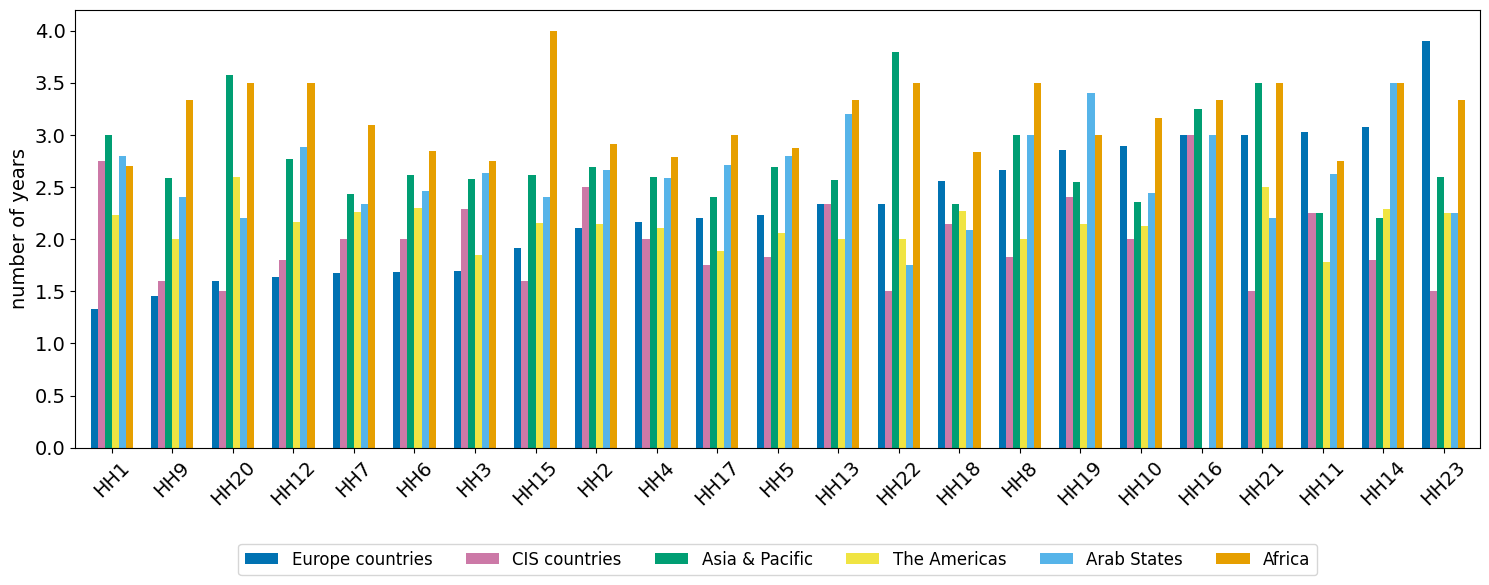

In [97]:
# Define your custom order
custom_order = ['Europe countries','CIS countries', 'Asia & Pacific', 'The Americas', 'Arab States', 'Africa']
#, 'Other Economies']

custom_colors = [
    '#0072B2',  # Blue
    '#CC79A7',  # Pink/Purple
    '#009E73',  # Green
    '#F0E442',  # Yellow
    '#56B4E9',  # Light Blue
    '#E69F00'  # Orange
    #'#696969'
    #'#999999',   # Grey
    ]


rename_dict = {
    'timeliness_hh1': 'HH1',
    'timeliness_hh2': 'HH2',
    'timeliness_hh3': 'HH3',
    'timeliness_hh4': 'HH4',
    'timeliness_hh5': 'HH5',
    'timeliness_hh6': 'HH6',
    'timeliness_hh7': 'HH7',
    'timeliness_hh8': 'HH8',
    'timeliness_hh9': 'HH9',
    'timeliness_hh10': 'HH10',
    'timeliness_hh11': 'HH11',
    'timeliness_hh12': 'HH12',
    'timeliness_hh13': 'HH13',
    'timeliness_hh14': 'HH14',
    'timeliness_hh15': 'HH15',
    'timeliness_hh16': 'HH16',
    'timeliness_hh17': 'HH17',
    'timeliness_hh18': 'HH18',
    'timeliness_hh19': 'HH19',
    'timeliness_hh20': 'HH20',
    'timeliness_hh21': 'HH21',
    'timeliness_hh22': 'HH22',
    'timeliness_hh23': 'HH23',
}


hh_timeliness = [f'timeliness_hh{i}' for i in range(1, 24)]
hh_timeliness.extend(['regionname'])
df[hh_timeliness].rename(columns=rename_dict).groupby(['regionname']).mean().reindex(custom_order).T.sort_values(
     by='Europe countries', ascending=True).plot(kind='bar',
                                                   stacked=False,
                                                   color=custom_colors,
                                                   figsize=(15, 6),
                                                   width=0.7)
#plt.title('Timeliness in 2025: average time lag of data points in number of years (available data only)', fontsize=12)
plt.xlabel('')
plt.ylabel('number of years', fontsize=14)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')

# Step 1: Get current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Step 2: Create a dict for easy lookup
label_to_handle = dict(zip(labels, handles))

# Step 3: Reconstruct the legend using custom order
plt.legend(
    [label_to_handle[label] for label in custom_order],
    custom_order,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.2),
    ncol=7,
    fontsize=12
)

plt.tight_layout()
plt.show()

In [98]:
df[df.regionname=='Europe countries'].shortname.unique()

array(['Albania', 'Andorra', 'Austria', 'Belgium',
       'Bosnia and Herzegovina', 'Bulgaria', 'Croatia', 'Cyprus',
       'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France',
       'Georgia', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland',
       'Israel', 'Italy', 'Latvia', 'Liechtenstein', 'Lithuania',
       'Luxembourg', 'Malta', 'Moldova', 'Monaco', 'Montenegro',
       'Netherlands', 'North Macedonia', 'Norway', 'Poland', 'Portugal',
       'Romania', 'San Marino', 'Serbia', 'Slovakia', 'Slovenia', 'Spain',
       'Sweden', 'Switzerland', 'Türkiye', 'Ukraine', 'United Kingdom',
       'Vatican'], dtype=object)

In [99]:
df[df.regionname=='Europe countries'].shortname.nunique()

46

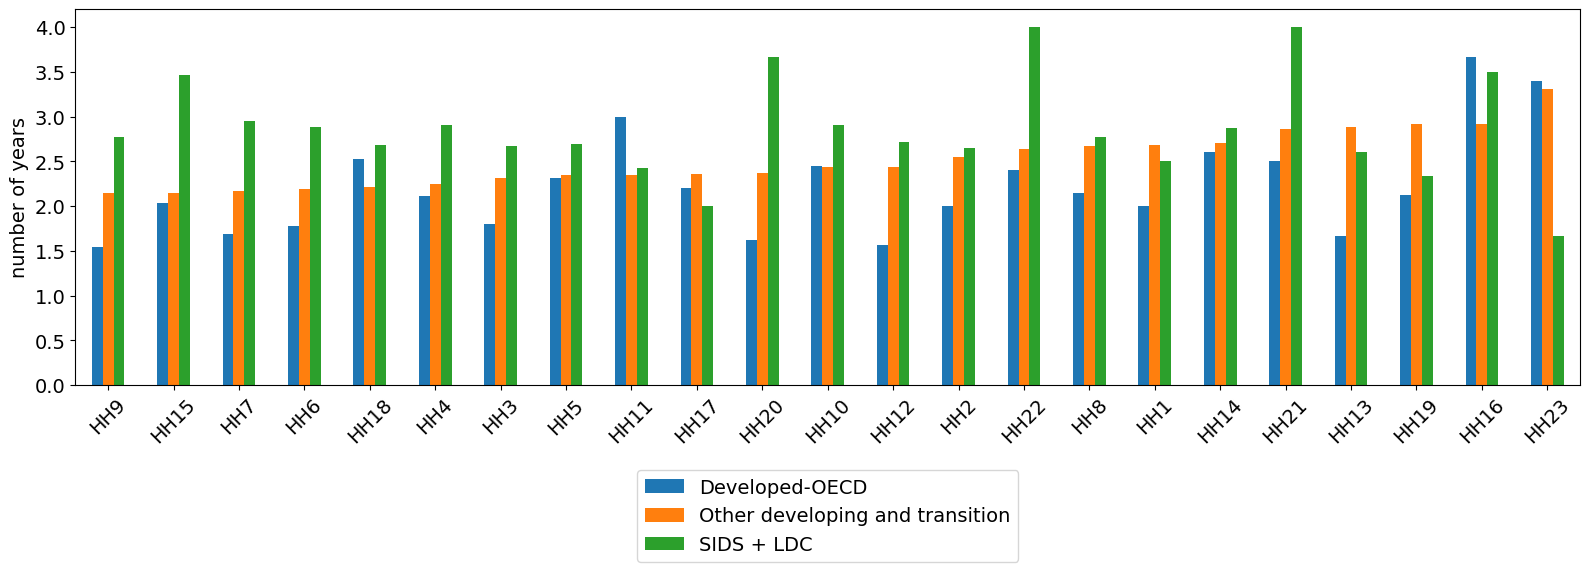

In [100]:
# Define your custom order
custom_order = ['Developed-OECD', 'Other developing and transition', 'SIDS + LDC']

rename_dict = {
    'timeliness_hh1': 'HH1',
    'timeliness_hh2': 'HH2',
    'timeliness_hh3': 'HH3',
    'timeliness_hh4': 'HH4',
    'timeliness_hh5': 'HH5',
    'timeliness_hh6': 'HH6',
    'timeliness_hh7': 'HH7',
    'timeliness_hh8': 'HH8',
    'timeliness_hh9': 'HH9',
    'timeliness_hh10': 'HH10',
    'timeliness_hh11': 'HH11',
    'timeliness_hh12': 'HH12',
    'timeliness_hh13': 'HH13',
    'timeliness_hh14': 'HH14',
    'timeliness_hh15': 'HH15',
    'timeliness_hh16': 'HH16',
    'timeliness_hh17': 'HH17',
    'timeliness_hh18': 'HH18',
    'timeliness_hh19': 'HH19',
    'timeliness_hh20': 'HH20',
    'timeliness_hh21': 'HH21',
    'timeliness_hh22': 'HH22',
    'timeliness_hh23': 'HH23',
}

hh_timeliness = [f'timeliness_hh{i}' for i in range(1, 24)]
hh_timeliness.extend(['new_group'])
df[hh_timeliness].rename(columns=rename_dict).groupby(['new_group']).mean().reset_index().set_index('new_group').T.sort_values(
     by='Other developing and transition', ascending=True)[custom_order].plot(kind='bar', stacked=False, figsize=(16, 6))
#plt.title('Timeliness in 2025: average time lag of data points in number of years (available data only)', fontsize=12)
plt.xlabel('')
plt.ylabel('number of years', fontsize=14)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')

# Step 1: Get current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Step 2: Create a dict for easy lookup
label_to_handle = dict(zip(labels, handles))

# Step 3: Reconstruct the legend using custom order
plt.legend(
    [label_to_handle[label] for label in custom_order],
    custom_order,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.2),
    ncol=1,
    fontsize=14
)
plt.tight_layout()
plt.show()

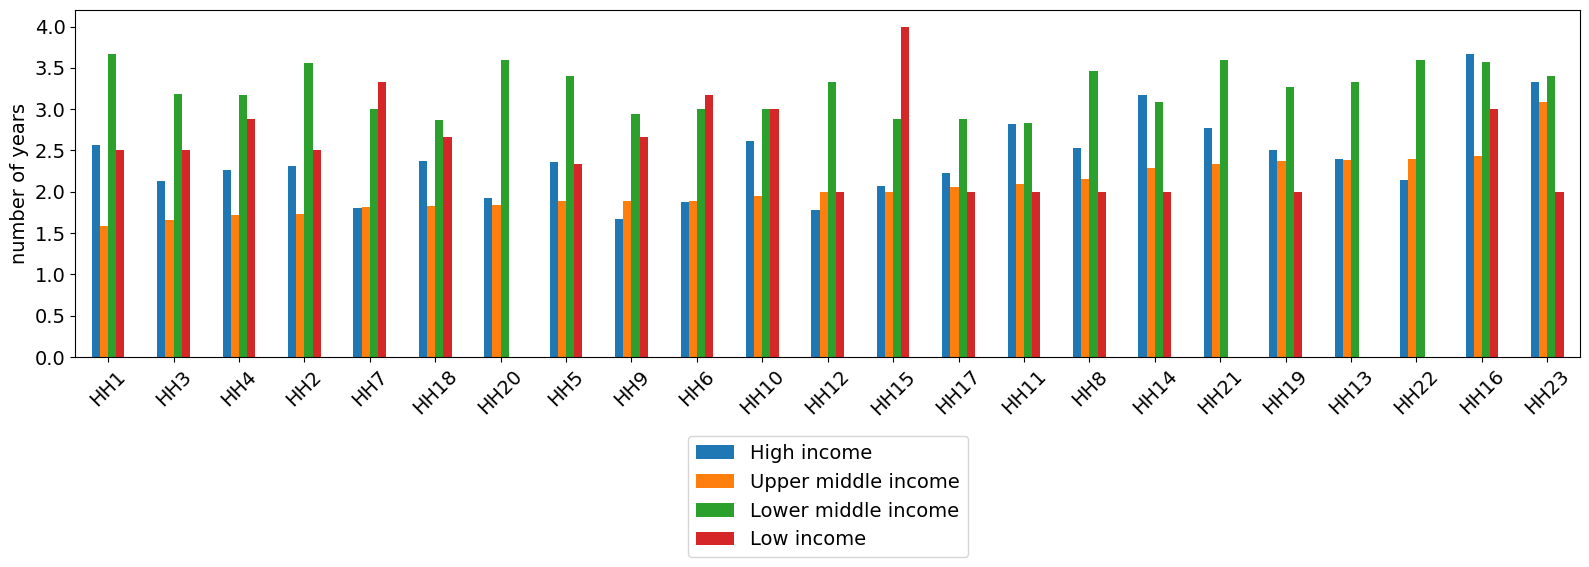

In [101]:
# Define your custom order
custom_order = ['High income', 'Upper middle income', 'Lower middle income', 'Low income']

rename_dict = {
    'timeliness_hh1': 'HH1',
    'timeliness_hh2': 'HH2',
    'timeliness_hh3': 'HH3',
    'timeliness_hh4': 'HH4',
    'timeliness_hh5': 'HH5',
    'timeliness_hh6': 'HH6',
    'timeliness_hh7': 'HH7',
    'timeliness_hh8': 'HH8',
    'timeliness_hh9': 'HH9',
    'timeliness_hh10': 'HH10',
    'timeliness_hh11': 'HH11',
    'timeliness_hh12': 'HH12',
    'timeliness_hh13': 'HH13',
    'timeliness_hh14': 'HH14',
    'timeliness_hh15': 'HH15',
    'timeliness_hh16': 'HH16',
    'timeliness_hh17': 'HH17',
    'timeliness_hh18': 'HH18',
    'timeliness_hh19': 'HH19',
    'timeliness_hh20': 'HH20',
    'timeliness_hh21': 'HH21',
    'timeliness_hh22': 'HH22',
    'timeliness_hh23': 'HH23',
}

hh_timeliness = [f'timeliness_hh{i}' for i in range(1, 24)]
hh_timeliness.extend(['wb_income'])
df[hh_timeliness].rename(columns=rename_dict).groupby(['wb_income']).mean().reset_index().set_index('wb_income').T.sort_values(
     by='Upper middle income', ascending=True)[custom_order].plot(kind='bar', stacked=False, figsize=(16, 6))
#plt.title('Timeliness in 2025: average time lag of data points in number of years (available data only)', fontsize=12)
plt.xlabel('')
plt.ylabel('number of years', fontsize=14)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')

# Step 1: Get current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Step 2: Create a dict for easy lookup
label_to_handle = dict(zip(labels, handles))

# Step 3: Reconstruct the legend using custom order
plt.legend(
    [label_to_handle[label] for label in custom_order],
    custom_order,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.2),
    ncol=1,
    fontsize=14
)
plt.tight_layout()
plt.show()

## Apply the indicator grouping as in the case of availability


In this case, if a country has hh1 which is 2 years old and hh3 which is 4 years old, for the group as a whole we take the minimum (not the maximum) between the two, such that data fir hh_group is 2 years old.

In [102]:
# define groups of indicators

entry_household = ['hh1', 'hh2', 'hh3', 'hh4', 'hh6']
entry_individual = ['hh5', 'hh7', 'hh10', 'hh18']
disaggregated_household = ['hh11', 'hh14']
disaggregated_individual = ['hh8', 'hh9', 'hh12', 'hh13', 'hh15', 'hh17', 'hh19', 'hh20', 'hh21', 'hh22','hh23']
expenditure = ['hh16']

groups = {
    'entry_household': entry_household,
    'entry_individual': entry_individual,
    'disaggregated_household': disaggregated_household,
    'disaggregated_individual': disaggregated_individual,
    'expenditure': expenditure
}

for new_col, base_cols in groups.items():
    matching_cols = [f"timeliness_{b}" for b in base_cols if f"timeliness_{b}" in df.columns]
    df[f"timeliness_{new_col}"] = df[matching_cols].min(axis=1)


In [103]:
df.timeliness_hh1.describe()

,timeliness_hh1
count,45.0
mean,2.555556
std,1.438995
min,1.0
25%,1.0
50%,2.0
75%,4.0
max,5.0


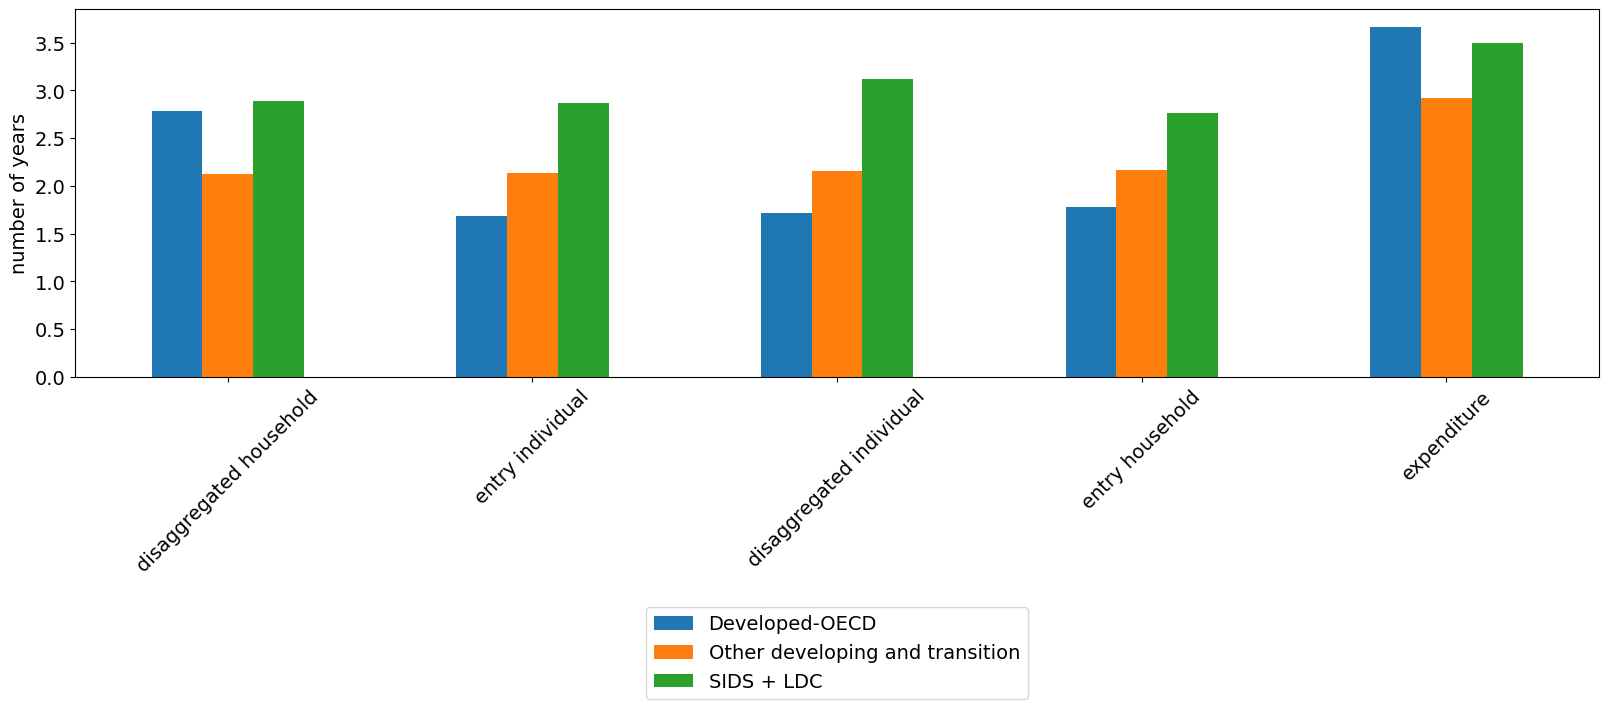

In [104]:
# Define your custom order
custom_order = ['Developed-OECD', 'Other developing and transition', 'SIDS + LDC']

rename_dict = {
    'timeliness_entry_household': 'entry household',
    'timeliness_entry_individual': 'entry individual',
    'timeliness_disaggregated_household': 'disaggregated household',
    'timeliness_disaggregated_individual': 'disaggregated individual',
    'timeliness_expenditure': 'expenditure',
}

hh_timeliness_new = ['timeliness_entry_household',
    'timeliness_entry_individual',
    'timeliness_disaggregated_household',
    'timeliness_disaggregated_individual',
    'timeliness_expenditure']
hh_timeliness_new.extend(['new_group'])
df[hh_timeliness_new].rename(columns=rename_dict).groupby(['new_group']).mean().reset_index().set_index('new_group').T.sort_values(
     by='Other developing and transition', ascending=True)[custom_order].plot(kind='bar', stacked=False, figsize=(16, 6))
#plt.title('Timeliness in 2025: average time lag of data points for indicator group in number of years (available data only)', fontsize=12)
plt.xlabel('')
plt.ylabel('number of years', fontsize=14)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')

# Step 1: Get current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Step 2: Create a dict for easy lookup
label_to_handle = dict(zip(labels, handles))

# Make more room at the bottom
plt.subplots_adjust(bottom=0.6)  # increase as needed

# Step 3: Reconstruct the legend using custom order
plt.legend(
    [label_to_handle[label] for label in custom_order],
    custom_order,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.6),
    ncol=1,
    fontsize=14
)
plt.tight_layout()
plt.show()

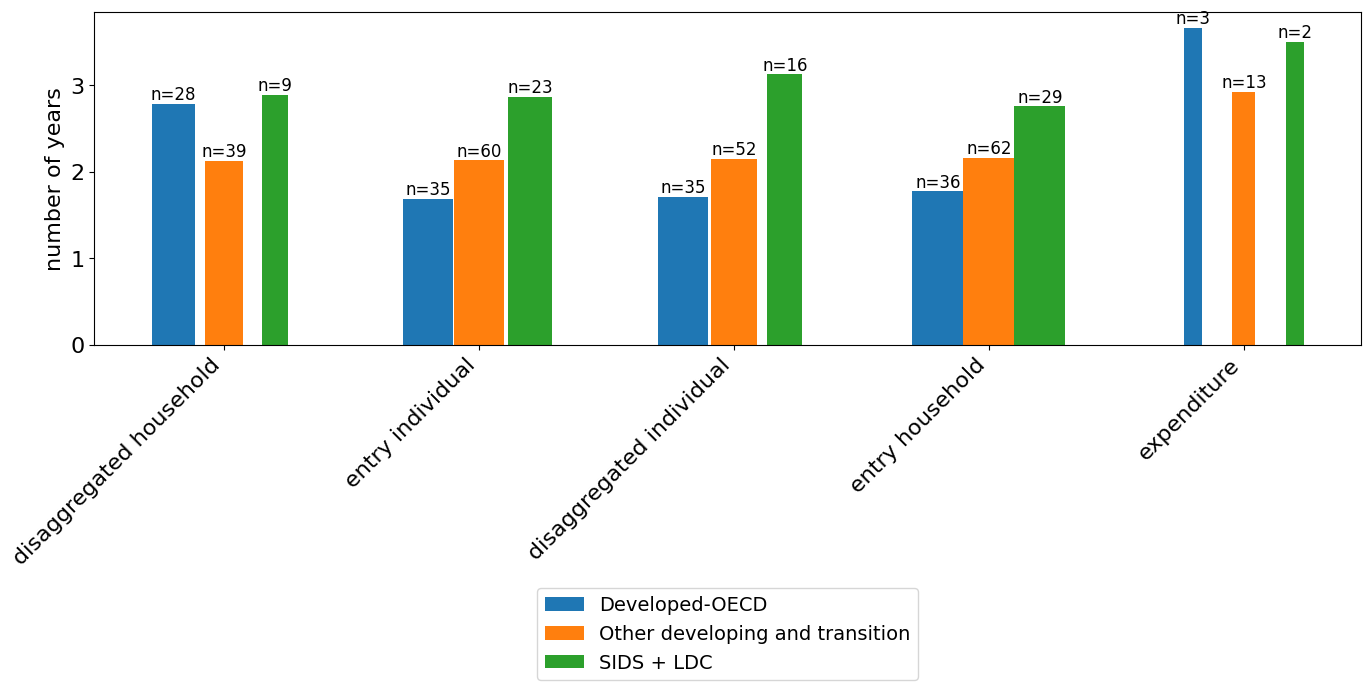

In [105]:
from matplotlib.patches import Patch

# Define your custom order
custom_order = ['Developed-OECD', 'Other developing and transition', 'SIDS + LDC']
#, 'Other Economies']

rename_dict = {
    'timeliness_entry_household': 'entry household',
    'timeliness_entry_individual': 'entry individual',
    'timeliness_disaggregated_household': 'disaggregated household',
    'timeliness_disaggregated_individual': 'disaggregated individual',
    'timeliness_expenditure': 'expenditure',
}

custom_colors = ['#1f77b4',  # Blue
'#ff7f0e' , # Orange
'#2ca02c',  # Green
'#d62728'  # Red
]

subset = df[['new_group','timeliness_entry_household','timeliness_entry_individual','timeliness_disaggregated_household',
    'timeliness_disaggregated_individual','timeliness_expenditure']].rename(columns=rename_dict)

# Calculate means and counts
means = subset.groupby('new_group').mean(numeric_only=True).T
counts = subset.groupby('new_group').count().T

# Sort by Europe countries
means_sorted = means.sort_values(by='Other developing and transition', ascending=True)[custom_order]
counts_sorted = counts.loc[means_sorted.index][custom_order]

# Set width factor range
min_width_factor = 0.3
max_width_factor = 1.0

# Create figure
fig, ax = plt.subplots(figsize=(14, 6))

# Plot each region separately to control width
x = np.arange(len(means_sorted.index))
base_width = 0.6 / len(custom_order)

for i, region in enumerate(custom_order):
    # Calculate width for each bar WITHIN THIS GROUP
    group_max_count = counts_sorted[region].max()

    # Normalize within the group
    width_factors = counts_sorted[region] / group_max_count * (max_width_factor - min_width_factor) + min_width_factor

    # Plot bars with individual widths
    for j, (indicator, value) in enumerate(means_sorted[region].items()):
        bar_width = base_width * width_factors.iloc[j]
        bar_x = x[j] + i * base_width - (len(custom_order) - 1) * base_width / 2

        ax.bar(
            bar_x,
            value,
            bar_width,
            color=custom_colors[i]
        )

        # Add text label on top of bar
        count = int(counts_sorted[region].iloc[j])
        if count > 0:
            ax.text(
                bar_x,
                value,
                f'n={count}',
                ha='center',
                va='bottom',
                fontsize=12,
                rotation=0
            )

ax.set_xlabel('', fontsize=16)
ax.set_ylabel('number of years', fontsize=16)
#plt.title('Timeliness in 2025: time lag of latest available data point in number of years (available data only)')
ax.set_xticks(x)
ax.set_xticklabels(means_sorted.index, rotation=45, fontsize=16, ha='right')
ax.tick_params(axis='y', labelsize=16)

# Create custom legend
legend_handles = [Patch(facecolor=custom_colors[i], label=region)
                  for i, region in enumerate(custom_order)] #

plt.subplots_adjust(bottom=0.7)
plt.legend(
    handles=legend_handles,
    loc='upper center',
    bbox_to_anchor=(0.5, -.7),
    ncol=1,
    fontsize=14
)

plt.tight_layout()
plt.show()


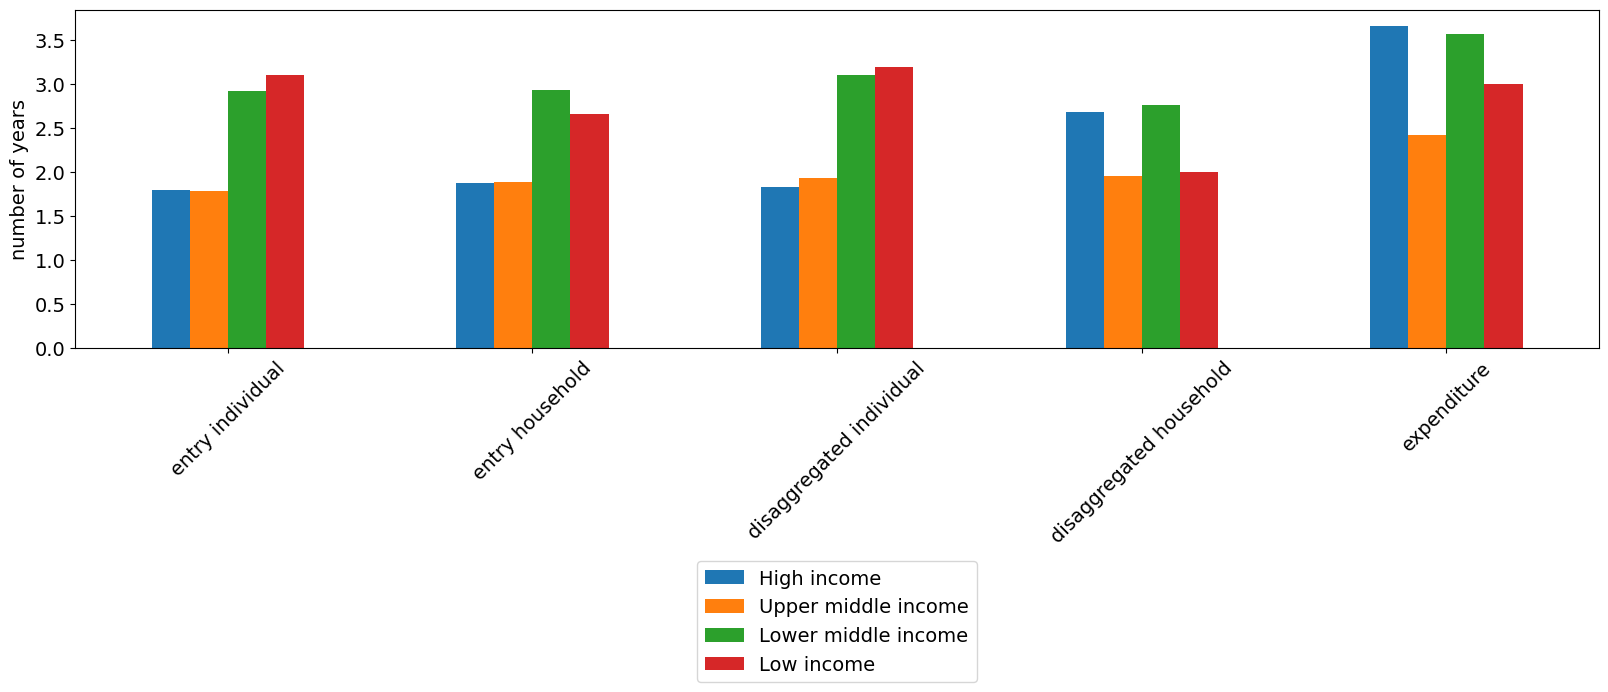

In [106]:
# Define your custom order
custom_order = ['High income', 'Upper middle income', 'Lower middle income', 'Low income']

rename_dict = {
    'timeliness_entry_household': 'entry household',
    'timeliness_entry_individual': 'entry individual',
    'timeliness_disaggregated_household': 'disaggregated household',
    'timeliness_disaggregated_individual': 'disaggregated individual',
    'timeliness_expenditure': 'expenditure',
}

hh_timeliness_new = ['timeliness_entry_household',
    'timeliness_entry_individual',
    'timeliness_disaggregated_household',
    'timeliness_disaggregated_individual',
    'timeliness_expenditure']
hh_timeliness_new.extend(['wb_income'])
df[hh_timeliness_new].rename(columns=rename_dict).groupby(['wb_income']).mean().reset_index().set_index('wb_income').T.sort_values(
     by='Upper middle income', ascending=True)[custom_order].plot(kind='bar', stacked=False, figsize=(16, 6))
#plt.title('Timeliness in 2025: average time lag of data points for indicator group in number of years (available data only)', fontsize=12)
plt.xlabel('')
plt.ylabel('number of years', fontsize=14)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')

# Step 1: Get current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Step 2: Create a dict for easy lookup
label_to_handle = dict(zip(labels, handles))

# Make more room at the bottom
plt.subplots_adjust(bottom=0.6)  # increase as needed

# Step 3: Reconstruct the legend using custom order
plt.legend(
    [label_to_handle[label] for label in custom_order],
    custom_order,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.6),
    ncol=1,
    fontsize=14
)
plt.tight_layout()
plt.show()

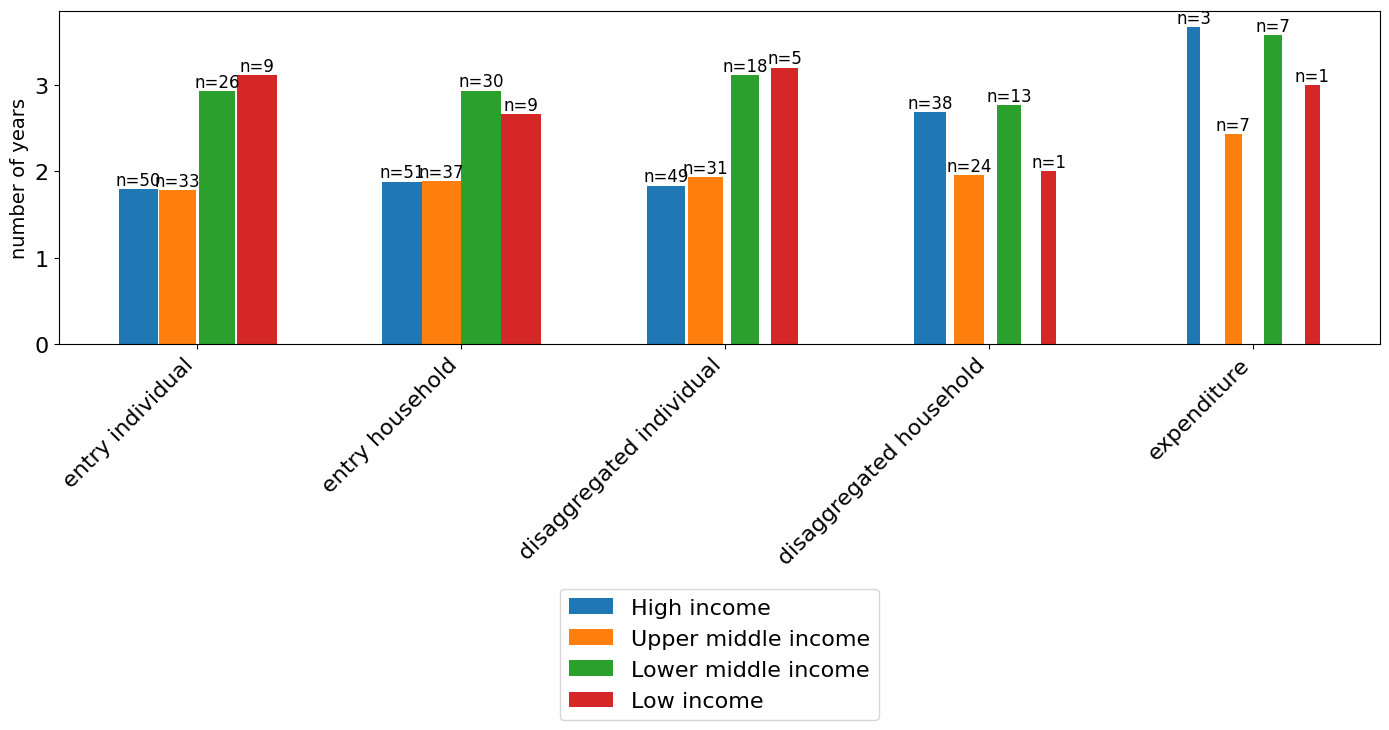

In [107]:
from matplotlib.patches import Patch

# Define your custom order
custom_order = ['High income', 'Upper middle income', 'Lower middle income', 'Low income']
#, 'Other Economies']

rename_dict = {
    'timeliness_entry_household': 'entry household',
    'timeliness_entry_individual': 'entry individual',
    'timeliness_disaggregated_household': 'disaggregated household',
    'timeliness_disaggregated_individual': 'disaggregated individual',
    'timeliness_expenditure': 'expenditure',
}

custom_colors = ['#1f77b4',  # Blue
'#ff7f0e' , # Orange
'#2ca02c',  # Green
'#d62728'  # Red
]

subset = df[['wb_income','timeliness_entry_household','timeliness_entry_individual','timeliness_disaggregated_household',
    'timeliness_disaggregated_individual','timeliness_expenditure']].rename(columns=rename_dict)

# Calculate means and counts
means = subset.groupby('wb_income').mean(numeric_only=True).T
counts = subset.groupby('wb_income').count().T

# Sort by Europe countries
means_sorted = means.sort_values(by='Upper middle income', ascending=True)[custom_order]
counts_sorted = counts.loc[means_sorted.index][custom_order]

# Set width factor range
min_width_factor = 0.3
max_width_factor = 1.0

# Create figure
fig, ax = plt.subplots(figsize=(14, 6))

# Plot each region separately to control width
x = np.arange(len(means_sorted.index))
base_width = 0.6 / len(custom_order)

for i, region in enumerate(custom_order):
    # Calculate width for each bar WITHIN THIS GROUP
    group_max_count = counts_sorted[region].max()

    # Normalize within the group
    width_factors = counts_sorted[region] / group_max_count * (max_width_factor - min_width_factor) + min_width_factor

    # Plot bars with individual widths
    for j, (indicator, value) in enumerate(means_sorted[region].items()):
        bar_width = base_width * width_factors.iloc[j]
        bar_x = x[j] + i * base_width - (len(custom_order) - 1) * base_width / 2

        ax.bar(
            bar_x,
            value,
            bar_width,
            color=custom_colors[i]
        )

        # Add text label on top of bar
        count = int(counts_sorted[region].iloc[j])
        if count > 0:
            ax.text(
                bar_x,
                value,
                f'n={count}',
                ha='center',
                va='bottom',
                fontsize=12,
                rotation=0
            )

ax.set_xlabel('', fontsize=15)
ax.set_ylabel('number of years', fontsize=14)
#plt.title('Timeliness in 2025: time lag of latest available data point in number of years (available data only)')
ax.set_xticks(x)
ax.set_xticklabels(means_sorted.index, rotation=45, fontsize=16, ha='right')
ax.tick_params(axis='y', labelsize=16)

# Create custom legend
legend_handles = [Patch(facecolor=custom_colors[i], label=region)
                  for i, region in enumerate(custom_order)] #

plt.subplots_adjust(bottom=0.7)
plt.legend(
    handles=legend_handles,
    loc='upper center',
    bbox_to_anchor=(0.5, -.7),
    ncol=1,
    fontsize=16
)

plt.tight_layout()
plt.show()


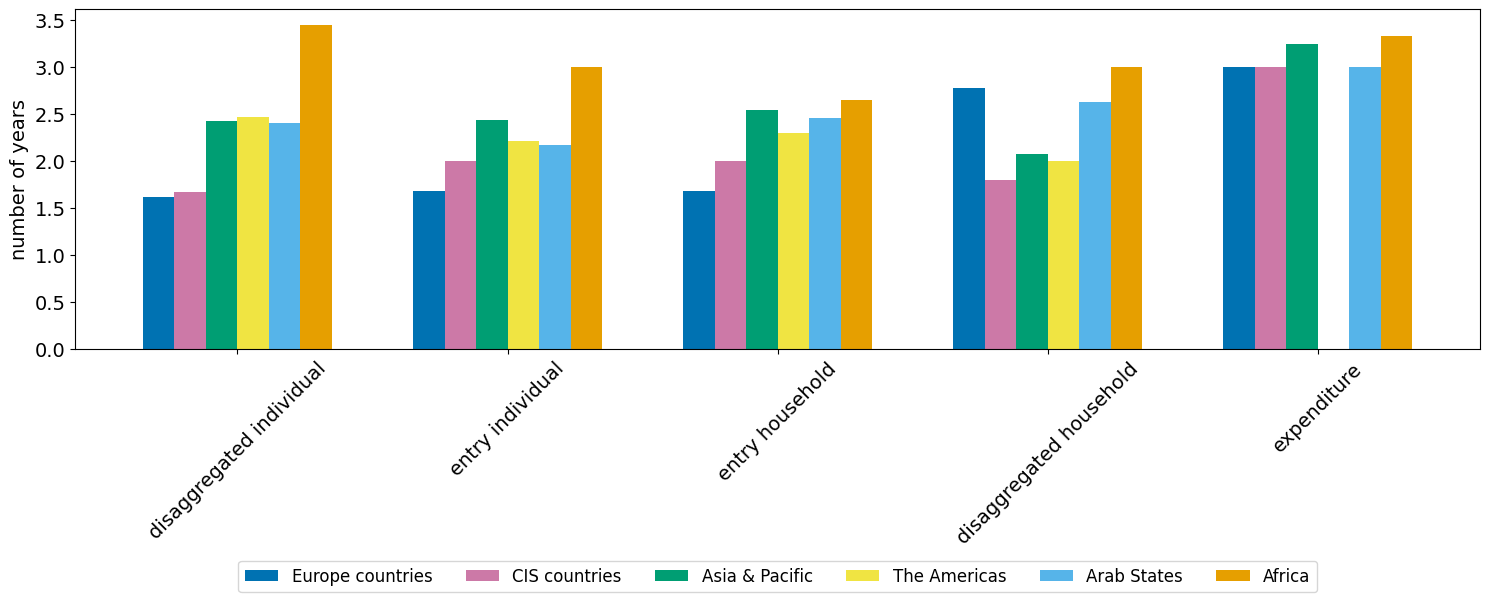

In [108]:
# Define your custom order
custom_order = ['Europe countries','CIS countries', 'Asia & Pacific', 'The Americas', 'Arab States', 'Africa']

custom_colors = [
    '#0072B2',  # Blue
    '#CC79A7',  # Pink/Purple
    '#009E73',  # Green
    '#F0E442',  # Yellow
    '#56B4E9',  # Light Blue
    '#E69F00'  # Orange
    #'#696969'
    #'#999999',   # Grey
    ]


rename_dict = {
    'timeliness_entry_household': 'entry household',
    'timeliness_entry_individual': 'entry individual',
    'timeliness_disaggregated_household': 'disaggregated household',
    'timeliness_disaggregated_individual': 'disaggregated individual',
    'timeliness_expenditure': 'expenditure',
}

hh_timeliness_new = ['timeliness_entry_household',
    'timeliness_entry_individual',
    'timeliness_disaggregated_household',
    'timeliness_disaggregated_individual',
    'timeliness_expenditure']
hh_timeliness_new.extend(['regionname'])
df[hh_timeliness_new].rename(columns=rename_dict).groupby(['regionname']).mean().reindex(custom_order).T.sort_values(
     by='Europe countries', ascending=True).plot(kind='bar',
                                                   stacked=False,
                                                   color=custom_colors,
                                                   figsize=(15, 6),
                                                   width=0.7)
#plt.title('Timeliness in 2025: average time lag of data points for indicator group in number of years (available data only)', fontsize=12)
plt.xlabel('')
plt.ylabel('number of years', fontsize=14)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')

# Step 1: Get current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Step 2: Create a dict for easy lookup
label_to_handle = dict(zip(labels, handles))

# Make more room at the bottom
plt.subplots_adjust(bottom=0.35)  # increase as needed

# Step 3: Reconstruct the legend using custom order
plt.legend(
    [label_to_handle[label] for label in custom_order],
    custom_order,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.6),
    ncol=7,
    fontsize=12
)

plt.tight_layout()
plt.show()

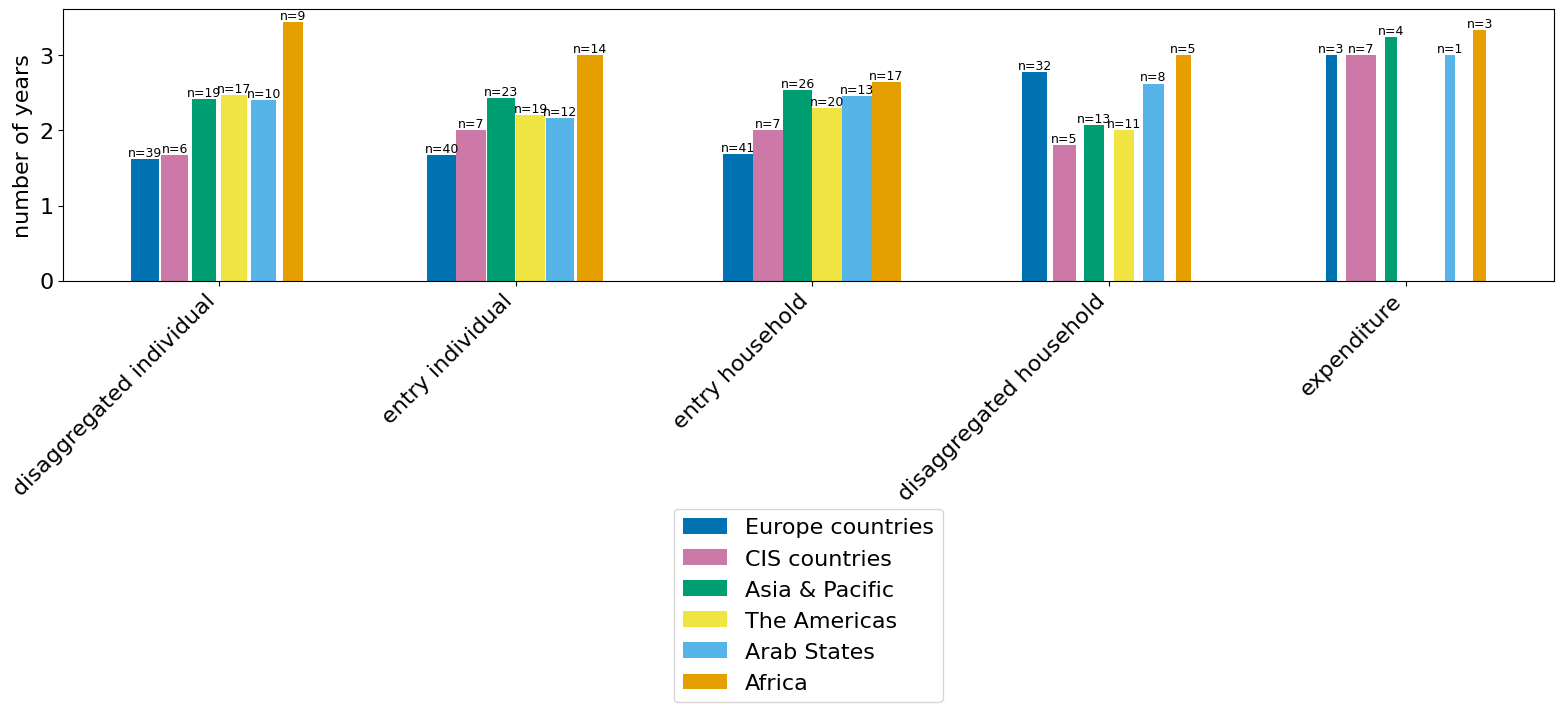

In [109]:
from matplotlib.patches import Patch

# Define your custom order
custom_order = ['Europe countries','CIS countries', 'Asia & Pacific', 'The Americas', 'Arab States', 'Africa']

custom_colors = [
    '#0072B2',  # Blue
    '#CC79A7',  # Pink/Purple
    '#009E73',  # Green
    '#F0E442',  # Yellow
    '#56B4E9',  # Light Blue
    '#E69F00'  # Orange
    ]

rename_dict = {
    'timeliness_entry_household': 'entry household',
    'timeliness_entry_individual': 'entry individual',
    'timeliness_disaggregated_household': 'disaggregated household',
    'timeliness_disaggregated_individual': 'disaggregated individual',
    'timeliness_expenditure': 'expenditure',
}


subset = df[['regionname','timeliness_entry_household','timeliness_entry_individual','timeliness_disaggregated_household',
    'timeliness_disaggregated_individual','timeliness_expenditure']].rename(columns=rename_dict)

# Calculate means and counts
means = subset.groupby('regionname').mean(numeric_only=True).T
counts = subset.groupby('regionname').count().T

# Sort by Europe countries
means_sorted = means.sort_values(by='Europe countries', ascending=True)[custom_order]
counts_sorted = counts.loc[means_sorted.index][custom_order]

# Set width factor range
min_width_factor = 0.3
max_width_factor = 1.0

# Create figure
fig, ax = plt.subplots(figsize=(16, 6))

# Plot each region separately to control width
x = np.arange(len(means_sorted.index))
base_width = 0.6 / len(custom_order)

for i, region in enumerate(custom_order):
    # Calculate width for each bar WITHIN THIS GROUP
    group_max_count = counts_sorted[region].max()

    # Skip if group_max_count is 0 or NaN
    if pd.isna(group_max_count) or group_max_count == 0:
        continue

    # Normalize within the group
    width_factors = counts_sorted[region] / group_max_count * (max_width_factor - min_width_factor) + min_width_factor

    # Plot bars with individual widths
    for j, (indicator, value) in enumerate(means_sorted[region].items()):
        # Skip if value is NaN
        if pd.isna(value):
            continue
        bar_width = base_width * width_factors.iloc[j]
        bar_x = x[j] + i * base_width - (len(custom_order) - 1) * base_width / 2

        ax.bar(
            bar_x,
            value,
            bar_width,
            color=custom_colors[i]
        )

        # Add text label on top of bar
        count = int(counts_sorted[region].iloc[j])
        if count > 0:
            ax.text(
                bar_x,
                value,
                f'n={count}',
                ha='center',
                va='bottom',
                fontsize=9,
                rotation=0
            )

ax.set_xlabel('', fontsize=16)
ax.set_ylabel('number of years', fontsize=16)
#plt.title('Timeliness in 2025: time lag of latest available data point in number of years (available data only)')
ax.set_xticks(x)
ax.set_xticklabels(means_sorted.index, rotation=45, fontsize=16, ha='right')
ax.tick_params(axis='y', labelsize=16)

# Create custom legend
legend_handles = [Patch(facecolor=custom_colors[i], label=region)
                  for i, region in enumerate(custom_order)] #

plt.subplots_adjust(bottom=0.7)
plt.legend(
    handles=legend_handles,
    loc='upper center',
    bbox_to_anchor=(0.5, -.8),
    ncol=1,
    fontsize=16
)

plt.tight_layout()
plt.show()


## New indicator: % of indicators available per year (of the 23 HH indicators) per country


We want to calculate how many HH indicators were available per country each year (max 23).

Then calculate the proportion of HH indicators available per country each year.


In [110]:
counts = (
  df_detailed.groupby(['Country','RegionName', 'CountryType', 'ItuMember', 'Indicator', 'DataYear'])
  .size()
  .reset_index(name='count')
) # counts non-NaNs automatically

# Step 1: Get unique countries and all years from column names
unique_countries = df_detailed[['Country']].drop_duplicates()

# List all years from this dataset
all_years = ['2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']

# List all HH indicators
all_hh_indicators = [f'HH{i}' for i in range(1, 24)]

# Step 4: Create base cartesian product of Country × Year
countries_years = (
    unique_countries.assign(key=1)
    .merge(pd.DataFrame({'DataYear': all_years, 'key': 1}), on='key')
    .drop(columns='key')
    .astype({'DataYear': 'int'})
)

# Step 5: Add HH indicators to the cartesian product
full_index = (
    countries_years.assign(key=1)
    .merge(pd.DataFrame({'Indicator': all_hh_indicators, 'key': 1}), on='key')
    .drop(columns='key')
)

# Step 3: Merge with the actual counts and fill missing with 0
df_by_country_year_hh = (
    full_index
    .merge(counts, on=['Country', 'DataYear', 'Indicator'], how='left')
    .fillna({'count': 0})
    .astype({'count': 'int'})
    .sort_values(['Country', 'DataYear'])
)


In [111]:
### correct for all of those NAs under regionname and countrytype
df_by_country_year_hh['RegionName'] = (
    df_by_country_year_hh
    .groupby('Country')['RegionName']
    .transform(lambda x: x.ffill().bfill())
)

df_by_country_year_hh['CountryType'] = (
    df_by_country_year_hh
    .groupby('Country')['CountryType']
    .transform(lambda x: x.ffill().bfill())
)

df_by_country_year_hh['ItuMember'] = (
    df_by_country_year_hh
    .groupby('Country')['ItuMember']
    .transform(lambda x: x.ffill().bfill())
)

/tmp/ipython-input-1529133037.py:5: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/tmp/ipython-input-1529133037.py:11: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [112]:
# checking for one country, one year to see the counts are correct

df_by_country_year_hh[(df_by_country_year_hh['Country']=='Afghanistan') & (df_by_country_year_hh['DataYear']== 2016)]

,Country,DataYear,Indicator,RegionName,CountryType,ItuMember,count
69,Afghanistan,2016,HH1,Asia & Pacific,Low Income,1.0,0
70,Afghanistan,2016,HH2,Asia & Pacific,Low Income,1.0,0
71,Afghanistan,2016,HH3,Asia & Pacific,Low Income,1.0,0
72,Afghanistan,2016,HH4,Asia & Pacific,Low Income,1.0,0
73,Afghanistan,2016,HH5,Asia & Pacific,Low Income,1.0,1
74,Afghanistan,2016,HH6,Asia & Pacific,Low Income,1.0,0
75,Afghanistan,2016,HH7,Asia & Pacific,Low Income,1.0,0
76,Afghanistan,2016,HH8,Asia & Pacific,Low Income,1.0,0
77,Afghanistan,2016,HH9,Asia & Pacific,Low Income,1.0,0
78,Afghanistan,2016,HH10,Asia & Pacific,Low Income,1.0,0


Now this dataset needs to be rendered by country x year. In it I calculate how many indicators are available by year (out of the 23)

In [113]:
df_by_country_year = df_by_country_year_hh.groupby(['Country', 'DataYear'])['count'].sum().reset_index()

In [114]:
df_by_country_year.rename(columns={'count': 'nb_hh_available'}, inplace=True)

df_by_country_year['pct_hh_available'] = df_by_country_year['nb_hh_available'] / 23 *100

In [115]:
# checking country by country for José
df_by_country_year[(df_by_country_year['DataYear']>2015) & (df_by_country_year['Country'].str.contains('Albania'))]

,Country,DataYear,nb_hh_available,pct_hh_available
15,Albania,2016,4,17.391304
16,Albania,2017,5,21.739130
17,Albania,2018,5,21.739130
18,Albania,2019,10,43.478261
19,Albania,2020,11,47.826087
20,Albania,2021,12,52.173913
21,Albania,2022,11,47.826087
22,Albania,2023,11,47.826087
23,Albania,2024,0,0.000000


In [116]:
# just checking it makes sense
df_by_country_year[(df_by_country_year['Country']=='Afghanistan')]

,Country,DataYear,nb_hh_available,pct_hh_available
0,Afghanistan,2013,0,0.000000
1,Afghanistan,2014,0,0.000000
2,Afghanistan,2015,4,17.391304
3,Afghanistan,2016,2,8.695652
4,Afghanistan,2017,0,0.000000
5,Afghanistan,2018,0,0.000000
6,Afghanistan,2019,0,0.000000
7,Afghanistan,2020,0,0.000000
8,Afghanistan,2021,0,0.000000
9,Afghanistan,2022,0,0.000000


Retrieve from the original data file the development group. I can do the join on country name because these are standard ITU country names

In [117]:
df_by_country_year = df_by_country_year.merge(df[['shortname', 'countrytype', 'new_group', 'overall_source','ison3code', 'regionname', 'wb_income']], left_on='Country', right_on='shortname', how='left')


Grouping the data again by year x country type so we can build a line chart evolution over time by development group

In [118]:
df_by_country_year[['DataYear', 'countrytype', 'pct_hh_available']].groupby(['countrytype', 'DataYear']).mean('pct_hh_available').reset_index().sort_values(by=['countrytype', 'DataYear'])

,countrytype,DataYear,pct_hh_available
0,Developed,2013,35.416667
1,Developed,2014,28.804348
2,Developed,2015,33.061594
3,Developed,2016,31.431159
4,Developed,2017,39.221014
5,Developed,2018,26.811594
6,Developed,2019,32.155797
7,Developed,2020,30.072464
8,Developed,2021,34.239130
9,Developed,2022,25.905797


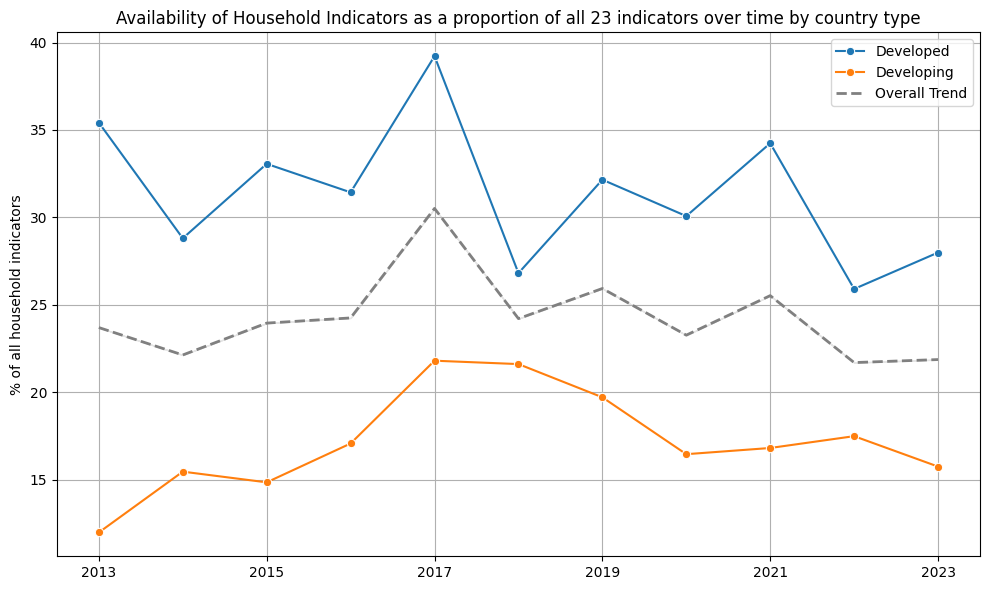

In [119]:
df_line = (
    df_by_country_year[df_by_country_year.DataYear <= 2023][['DataYear', 'countrytype', 'pct_hh_available']]
    .groupby(['countrytype', 'DataYear'], as_index=False)
    .mean(numeric_only=True)
    .sort_values(by=['countrytype', 'DataYear'])
)

# Compute average pct_hh_available by year (all countries combined)
df_line['trend'] = df_line[['pct_hh_available', 'DataYear']].groupby('DataYear').transform(lambda x: x.rolling(window=7, center=True, min_periods=1).mean())


# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df_line,
    x='DataYear',
    y='pct_hh_available',
    hue='countrytype',        # Two lines, one for each country type
    marker='o'                # Optional: dots on the line
)

# Overlay trend line
sns.lineplot(
    data=df_line,
    x='DataYear',
    y='trend',
    color='gray',
    linewidth=2,
    linestyle='--',
    label='Overall Trend',
    legend=False            # Don't repeat the legend
)

plt.title("Availability of Household Indicators as a proportion of all 23 indicators over time by country type")
plt.xlabel("")
plt.xticks(ticks=range(df_line['DataYear'].min(), df_line['DataYear'].max() + 1, 2))
plt.ylabel("% of all household indicators")
plt.legend(title="")
plt.grid(True)
plt.tight_layout()
plt.show()

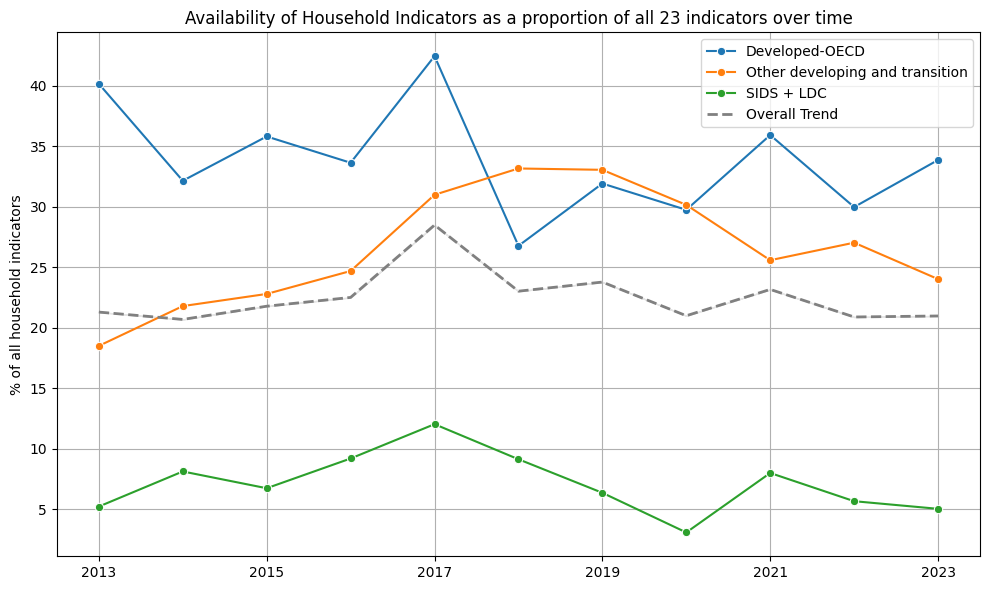

In [120]:
# Define your custom order
custom_order = ['Developed-OECD', 'Other developing and transition', 'SIDS + LDC']

df_line = (
    df_by_country_year[df_by_country_year.DataYear <= 2023][['DataYear', 'new_group', 'pct_hh_available']]
    .groupby(['new_group', 'DataYear'], as_index=False)
    .mean(numeric_only=True)
    .sort_values(by=['new_group', 'DataYear'])
)

# Compute average pct_hh_available by year (all countries combined)
df_line['trend'] = df_line[['pct_hh_available', 'DataYear']].groupby('DataYear').transform(lambda x: x.rolling(window=7, center=True, min_periods=1).mean())


# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df_line,
    x='DataYear',
    y='pct_hh_available',
    hue='new_group',        # Two lines, one for each country type
    hue_order=custom_order,
    marker='o'
)

# Overlay trend line
sns.lineplot(
    data=df_line,
    x='DataYear',
    y='trend',
    color='gray',
    linewidth=2,
    linestyle='--',
    label='Overall Trend',
    legend=False            # Don't repeat the legend
)

plt.title("Availability of Household Indicators as a proportion of all 23 indicators over time")
plt.xlabel("")
plt.xticks(ticks=range(df_line['DataYear'].min(), df_line['DataYear'].max() + 1, 2))
plt.ylabel("% of all household indicators")
plt.legend(title="")
plt.grid(True)
plt.tight_layout()
plt.show()

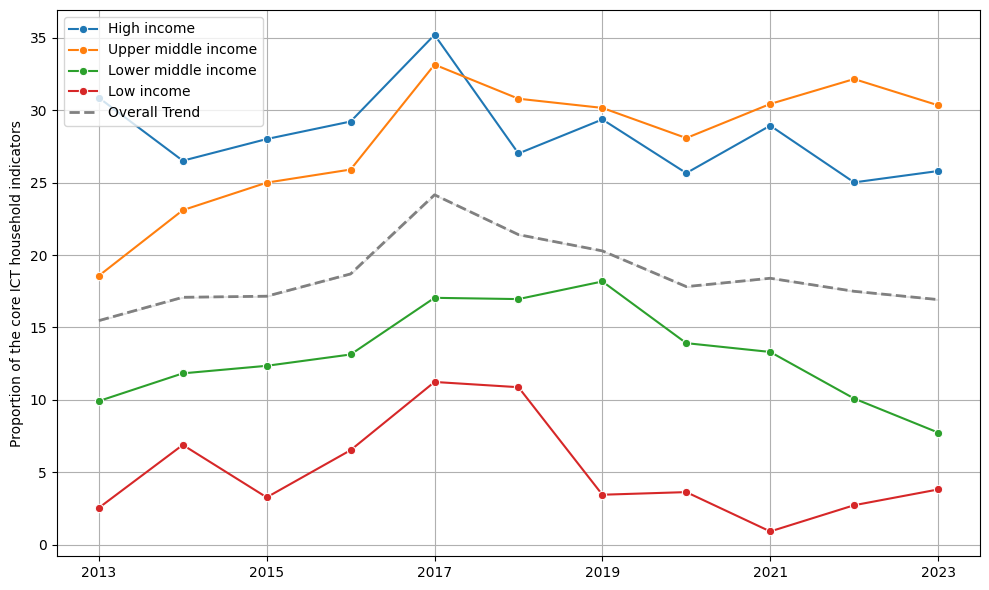

In [121]:
# Define your custom order
custom_order = ['High income', 'Upper middle income', 'Lower middle income', 'Low income']

df_line = (
    df_by_country_year[df_by_country_year.DataYear <= 2023][['DataYear', 'wb_income', 'pct_hh_available']]
    .groupby(['wb_income', 'DataYear'], as_index=False)
    .mean(numeric_only=True)
    .sort_values(by=['wb_income', 'DataYear'])
)

# Compute average pct_hh_available by year (all countries combined)
df_line['trend'] = df_line[['pct_hh_available', 'DataYear']].groupby('DataYear').transform(lambda x: x.rolling(window=7, center=True, min_periods=1).mean())


# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df_line,
    x='DataYear',
    y='pct_hh_available',
    hue='wb_income',        # Two lines, one for each country type
    hue_order=custom_order,
    marker='o'
)

# Overlay trend line
sns.lineplot(
    data=df_line,
    x='DataYear',
    y='trend',
    color='gray',
    linewidth=2,
    linestyle='--',
    label='Overall Trend',
    legend=False            # Don't repeat the legend
)

#plt.title("Availability of Household Indicators as a proportion of all 23 indicators over time")
plt.xlabel("")
plt.xticks(ticks=range(df_line['DataYear'].min(), df_line['DataYear'].max() + 1, 2))
plt.ylabel("Proportion of the core ICT household indicators")
plt.legend(title="")
plt.grid(True)
plt.tight_layout()
plt.show()

### Obtain bar charts for the availability indicator as well

Need to start from the dataset by country year and indicator.

Filter data for availability in 2020-2024 (last 5 years).

Group by country group and get the average indicator.

In [122]:
df_by_country_year[df_by_country_year.DataYear >= 2020].groupby("new_group")[
    "nb_hh_available"
].mean().reset_index().sort_values(by="nb_hh_available", ascending=False)


,new_group,nb_hh_available
0,Developed-OECD,6.773684
1,Other developing and transition,5.620513
2,SIDS + LDC,1.133333


In [123]:
# if we want data by indicator, but this is too similar to number vaialbale in last 5 years

#df_by_country_year_hh[df_by_country_year_hh.DataYear >= 2020].pivot(
 #   index=["Country", "DataYear"], columns="Indicator", values="count"
#).reset_index().groupby('Country').mean().reset_index()

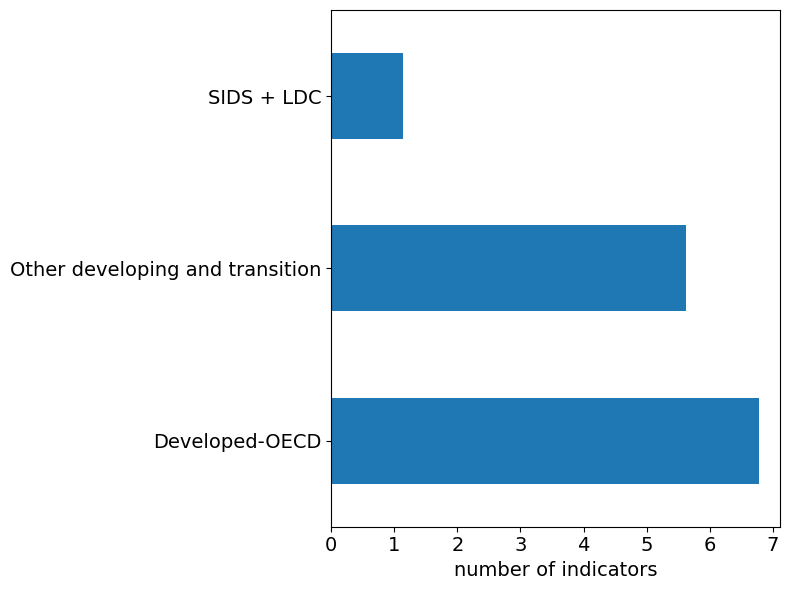

In [124]:

df_by_country_year[df_by_country_year.DataYear >= 2020].groupby("new_group")[
    "nb_hh_available"
].mean().reset_index().sort_values(by="nb_hh_available", ascending=False
                                   ).set_index('new_group').plot(kind='barh', stacked=False, figsize=(8, 6))




#plt.title('Average number of core HH indicators available by country group (2020-2024)', fontsize=12)
plt.ylabel('')
plt.xlabel('number of indicators', fontsize=14)
plt.xticks(rotation=0, fontsize=14)
plt.yticks(fontsize=14)
plt.legend().remove()




plt.tight_layout()
plt.show()

In [125]:

df_by_country_year[df_by_country_year.DataYear >= 2020].groupby("regionname")[
    "nb_hh_available"
].mean().reset_index().sort_values(by="nb_hh_available")

,regionname,nb_hh_available
0,Africa,0.975000
5,Other Economies,1.036364
2,Asia & Pacific,4.028571
6,The Americas,4.366667
1,Arab States,4.722222
4,Europe countries,6.709524
3,CIS countries,9.422222


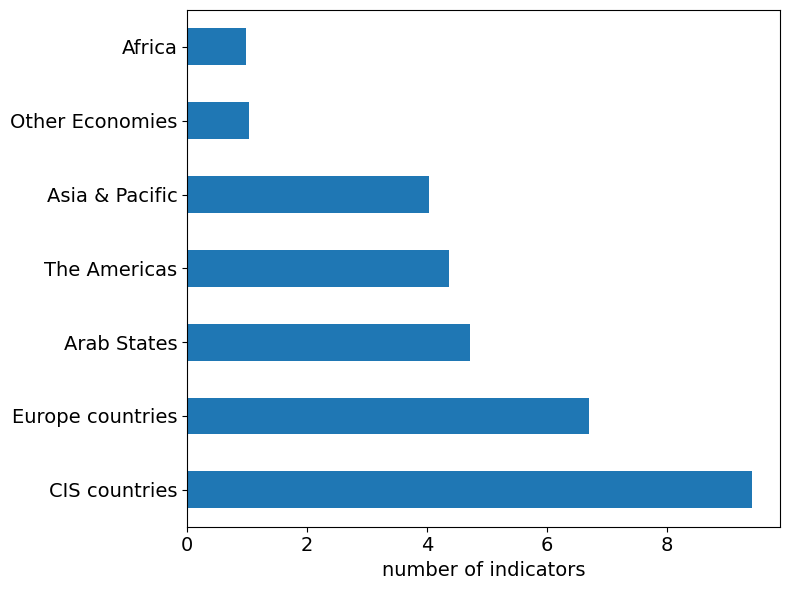

In [126]:
# Define your custom order
custom_order = ['Europe countries','CIS countries', 'Asia & Pacific', 'The Americas', 'Arab States', 'Africa', 'Other Economies']

custom_colors = [
    '#0072B2',  # Blue
    '#CC79A7',  # Pink/Purple
    '#009E73',  # Green
    '#F0E442',  # Yellow
    '#56B4E9',  # Light Blue
    '#E69F00',  # Orange
    '#696969'
    #'#999999',   # Grey
    ]

df_by_country_year[df_by_country_year.DataYear >= 2020].groupby("regionname")[
    "nb_hh_available"
].mean().reset_index().sort_values(by="nb_hh_available", ascending=False
                                   ).set_index('regionname').plot(kind='barh',
                                                                  stacked=False,
                                                                  figsize=(8, 6))




#plt.title('Average number of core HH indicators available by country group (2020-2024)', fontsize=12)
plt.ylabel('')
plt.xlabel('number of indicators', fontsize=14)
plt.xticks(rotation=0, fontsize=14)
plt.yticks(fontsize=14)
plt.legend().remove()




plt.tight_layout()
plt.show()

# Country Profile charts

In [177]:
country_name = 'South Africa'

df_detailed[(df_detailed.Country==country_name) & (df_detailed.DataYear>= 2020) ]

,Country,CountryType,RegionName,Indicator,ItuMember,DataYear
8711,South Africa,Upper Middle Income,Africa,HH1,1,2022
8712,South Africa,Upper Middle Income,Africa,HH1,1,2023
8717,South Africa,Upper Middle Income,Africa,HH13,1,2022
8734,South Africa,Upper Middle Income,Africa,HH2,1,2021
8735,South Africa,Upper Middle Income,Africa,HH2,1,2022
8736,South Africa,Upper Middle Income,Africa,HH2,1,2023
8742,South Africa,Upper Middle Income,Africa,HH3,1,2021
8743,South Africa,Upper Middle Income,Africa,HH3,1,2022
8744,South Africa,Upper Middle Income,Africa,HH3,1,2023
8752,South Africa,Upper Middle Income,Africa,HH4,1,2020


In [176]:
# prepping my data to draw a barcode plot

years = [2020, 2021, 2022, 2023, 2024]

hh_cols = [f'HH{i}' for i in range(1, 24)]

codes = hh_cols

# limit data to the past 5 years and to the country of choice
# we only need to know if the data is available or missing
df_country = df_detailed[(df_detailed.Country == country_name) & (df_detailed.DataYear>= 2020)].pivot(index='Indicator', columns='DataYear', values ='DataYear').reindex(columns=years, index=codes).notna().astype(int).reset_index()


df_country

DataYear,Indicator,2020,2021,2022,2023,2024
0,HH1,0,0,1,1,0
1,HH2,0,1,1,1,0
2,HH3,0,1,1,1,0
3,HH4,1,1,1,1,0
4,HH5,0,0,0,0,0
5,HH6,1,1,1,1,0
6,HH7,0,0,0,0,0
7,HH8,0,0,0,0,0
8,HH9,0,0,0,0,0
9,HH10,0,0,0,0,0


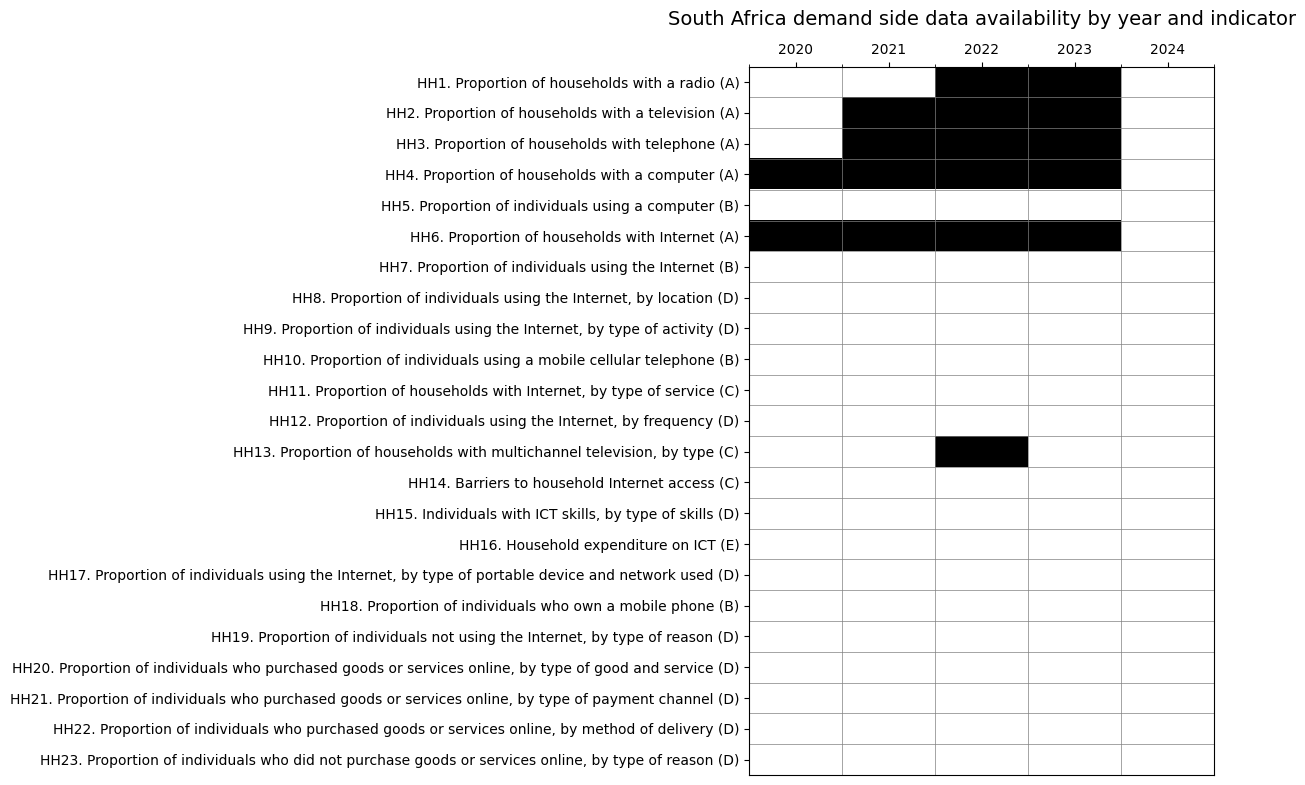

In [178]:


df_country = df_detailed[(df_detailed.Country == country_name) & (df_detailed.DataYear>= 2020)].pivot(index='Indicator', columns='DataYear', values ='DataYear').reindex(columns=years, index=codes).notna().astype(int).reset_index()

new_names = ['HH1. Proportion of households with a radio (A)', 'HH2. Proportion of households with a television (A)',
             'HH3. Proportion of households with telephone (A)', 'HH4. Proportion of households with a computer (A)',
             'HH5. Proportion of individuals using a computer (B)' , 'HH6. Proportion of households with Internet (A)',
             'HH7. Proportion of individuals using the Internet (B)', 'HH8. Proportion of individuals using the Internet, by location (D)',  'HH9. Proportion of individuals using the Internet, by type of activity (D)',
             'HH10. Proportion of individuals using a mobile cellular telephone (B)','HH11. Proportion of households with Internet, by type of service (C)',
             'HH12. Proportion of individuals using the Internet, by frequency (D)','HH13. Proportion of households with multichannel television, by type (C)',
             'HH14. Barriers to household Internet access (C)', 'HH15. Individuals with ICT skills, by type of skills (D)',
             'HH16. Household expenditure on ICT (E)', 'HH17. Proportion of individuals using the Internet, by type of portable device and network used (D)',
             'HH18. Proportion of individuals who own a mobile phone (B)', 'HH19. Proportion of individuals not using the Internet, by type of reason (D)',
             'HH20. Proportion of individuals who purchased goods or services online, by type of good and service (D)',
             'HH21. Proportion of individuals who purchased goods or services online, by type of payment channel (D)',
             'HH22. Proportion of individuals who purchased goods or services online, by method of delivery (D)', 'HH23. Proportion of individuals who did not purchase goods or services online, by type of reason (D)']

df_country.Indicator=new_names

# Convert DataFrame to numpy array (without transpose)

code_array = df_country.set_index('Indicator').to_numpy()


fig, ax = plt.subplots(figsize=(code_array.shape[1] * 1.2, code_array.shape[0] * 0.4))

# Show barcode
ax.imshow(code_array, cmap='binary', aspect='auto', interpolation='nearest')

# Set row labels (y-axis) - now Indicators
ax.set_yticks(np.arange(code_array.shape[0]))
ax.set_yticklabels(df_country.set_index('Indicator').index)

# Set column labels (x-axis) - now Years
ax.set_xticks(np.arange(code_array.shape[1]))
ax.set_xticklabels(df_country.set_index('Indicator').columns, rotation=0)
ax.xaxis.tick_top() # put year lables on top

ax.set_title(f'{country_name} demand side data availability by year and indicator', fontsize=14, pad=30)

# Optional: grid
ax.set_xticks(np.arange(-.5, code_array.shape[1], 1), minor=True)
ax.set_yticks(np.arange(-.5, code_array.shape[0], 1), minor=True)
ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
ax.tick_params(which='minor', bottom=False, left=False)

plt.show()

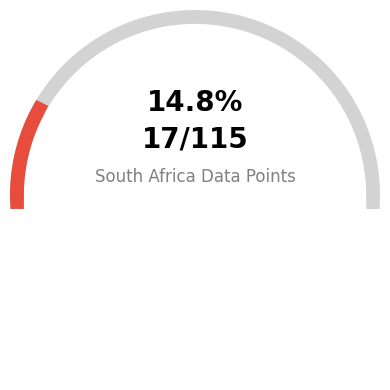

In [179]:
year_columns = [2020, 2021, 2022, 2023, 2024]

# Calculate your percentage
completeness = df_country[year_columns].sum().sum()/(23*5)*100

# Create gauge chart
fig, ax = plt.subplots(figsize=(8, 4), subplot_kw={'projection': 'polar'})

# Set up the gauge (semicircle)
theta = np.linspace(0, np.pi, 100)

# Background arc (gray)
ax.plot(theta, [1]*100, color='lightgray', linewidth=20)

# Colored arc based on percentage
# Define color zones
if completeness >= 75:
    color = '#2ecc71'  # Green
elif completeness >= 50:
    color = '#f39c12'  # Orange
else:
    color = '#e74c3c'  # Red

# Calculate how much of the arc to fill
theta_fill = np.linspace(0, np.pi * (completeness/100), 100)
ax.plot(theta_fill, [1]*100, color=color, linewidth=20)

# Add percentage text in center
ax.text(np.pi/2, 0.5, f'{completeness:.1f}%',
        ha='center', va='center', fontsize=20, fontweight='bold')
# Add calculation text in center
ax.text(np.pi/2, 0.3, f'{completeness*1.15:.0f}/115',
        ha='center', va='center', fontsize=20, fontweight='bold')
ax.text(np.pi/2, 0.1, f'{country_name} Data Points',
        ha='center', va='center', fontsize=12, color='gray')

# Customize appearance
ax.set_ylim(0, 1)
ax.set_theta_offset(np.pi)
ax.set_theta_direction(-1)
ax.set_xticks([])
ax.set_yticks([])
ax.spines['polar'].set_visible(False)
ax.grid(False)
plt.subplots_adjust(bottom=0.1, top=0.9)

plt.tight_layout()
plt.show()

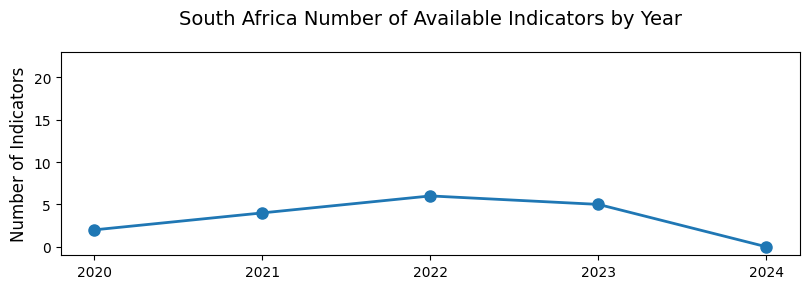

In [180]:
# Calculate sum for each year (excluding the 'Indicator' column)
year_columns = [2020, 2021, 2022, 2023, 2024]
year_sums = df_country[year_columns].sum()

# Create line chart
plt.figure(figsize=(8.2, 3))
plt.plot(year_sums.index, year_sums.values, marker='o', linewidth=2, markersize=8)

plt.title(f'{country_name} Number of Available Indicators by Year', fontsize=14, pad=20)
# Set x-ticks to integers only
plt.xticks(year_columns)  # This ensures only your year values appear as ticks
#plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Indicators', fontsize=12)
#plt.grid(True, alpha=0.3)
plt.ylim(-1, 23)  # Add some space at the top #max(year_sums.values) + 1
#plt.ylim(-1, max(year_sums.values) + 1)  # Starts at -1 instead of 0

plt.tight_layout()
plt.show()

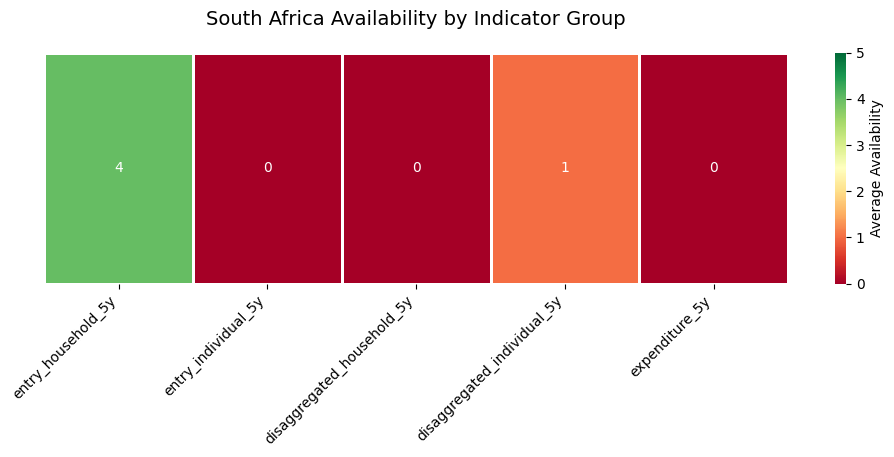

In [181]:
# Select the row for that country
country_data = df[df['shortname'] == country_name]

plt.figure(figsize=(12, 3))
sns.heatmap(country_data[['entry_household_5y',
'entry_individual_5y',
'disaggregated_household_5y',
'disaggregated_individual_5y',
'expenditure_5y']],
            annot=True,
            fmt='.0f',
            cmap='RdYlGn',  # Red-Yellow-Green
            cbar_kws={'label': 'Average Availability'},
            linewidths=1,
            linecolor='white',
            vmin=0,
            vmax=5)

plt.title(f'{country_name} Availability by Indicator Group', fontsize=14, pad=20)
#plt.xlabel('Indicator', fontsize=12)
#plt.ylabel('')
plt.yticks([])
plt.xticks(rotation=45, ha='right')
#plt.tight_layout()
plt.show()

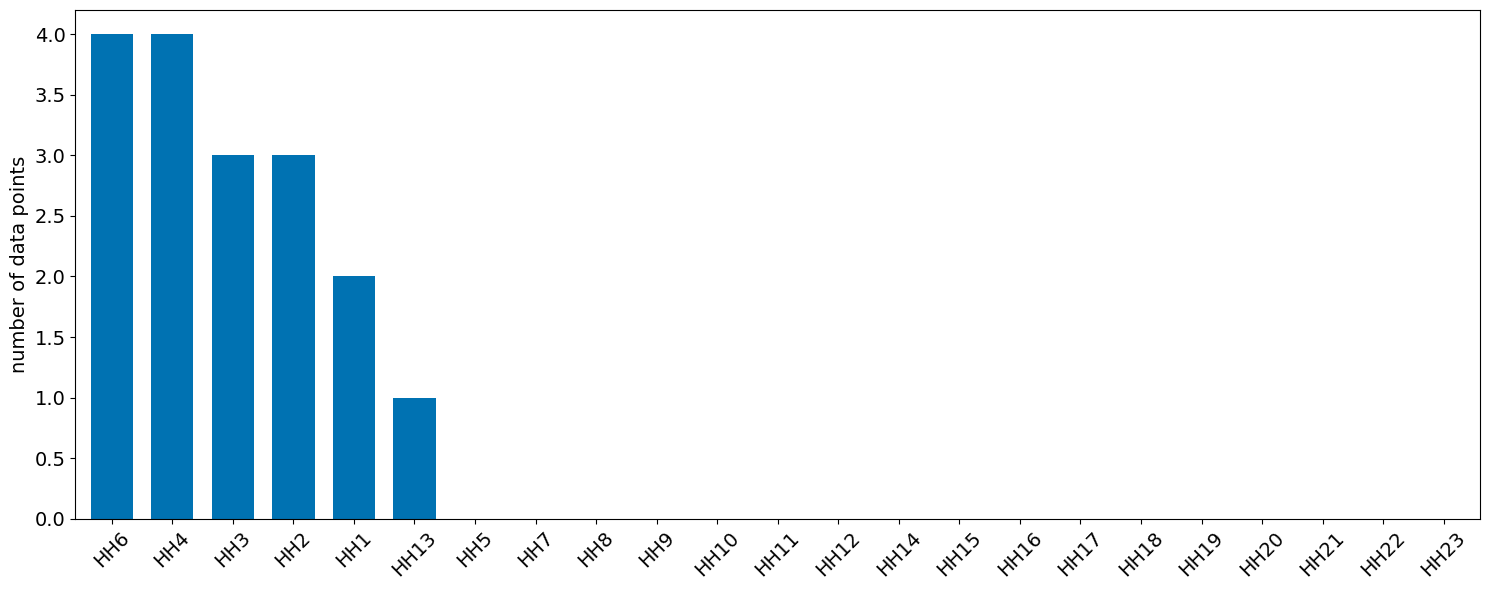

In [182]:
# Define your custom order
custom_order = ['Europe countries','CIS countries', 'Asia & Pacific', 'The Americas', 'Arab States', 'Africa']
#, 'Other Economies']

custom_colors = [
    '#0072B2',  # Blue
    '#CC79A7',  # Pink/Purple
    '#009E73',  # Green
    '#F0E442',  # Yellow
    '#56B4E9',  # Light Blue
    '#E69F00'  # Orange
    #'#696969'
    #'#999999',   # Grey
    ]

rename_dict = {
    'hh1_5y': 'HH1','hh2_5y': 'HH2','hh3_5y': 'HH3','hh4_5y': 'HH4','hh5_5y': 'HH5',
    'hh6_5y': 'HH6','hh7_5y': 'HH7','hh8_5y': 'HH8','hh9_5y': 'HH9','hh10_5y': 'HH10',
    'hh11_5y': 'HH11','hh12_5y': 'HH12','hh13_5y': 'HH13','hh14_5y': 'HH14','hh15_5y': 'HH15',
    'hh16_5y': 'HH16','hh17_5y': 'HH17','hh18_5y': 'HH18','hh19_5y': 'HH19','hh20_5y': 'HH20',
    'hh21_5y': 'HH21','hh22_5y': 'HH22','hh23_5y': 'HH23',
}

df[['hh1_5y','hh2_5y','hh3_5y','hh4_5y','hh5_5y','hh6_5y','hh7_5y','hh8_5y',
 'hh9_5y','hh10_5y','hh11_5y','hh12_5y','hh13_5y','hh14_5y','hh15_5y','hh16_5y',
 'hh17_5y','hh18_5y','hh19_5y','hh20_5y','hh21_5y','hh22_5y','hh23_5y']][df.shortname==country_name].rename(
     columns=rename_dict).reset_index().T.drop("index").sort_values(by=[0], ascending=False).plot(kind='bar',
                                                  figsize=(15, 6),
                                                  color=custom_colors,
                                                  width=0.7)
#plt.title('Average number of data points per indicator in the past 5 years (2020-2024)')
plt.xlabel('')
plt.legend().remove()

plt.ylabel('number of data points', fontsize=14)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')

# Step 1: Get current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Step 2: Create a dict for easy lookup
label_to_handle = dict(zip(labels, handles))


plt.tight_layout()
plt.show()

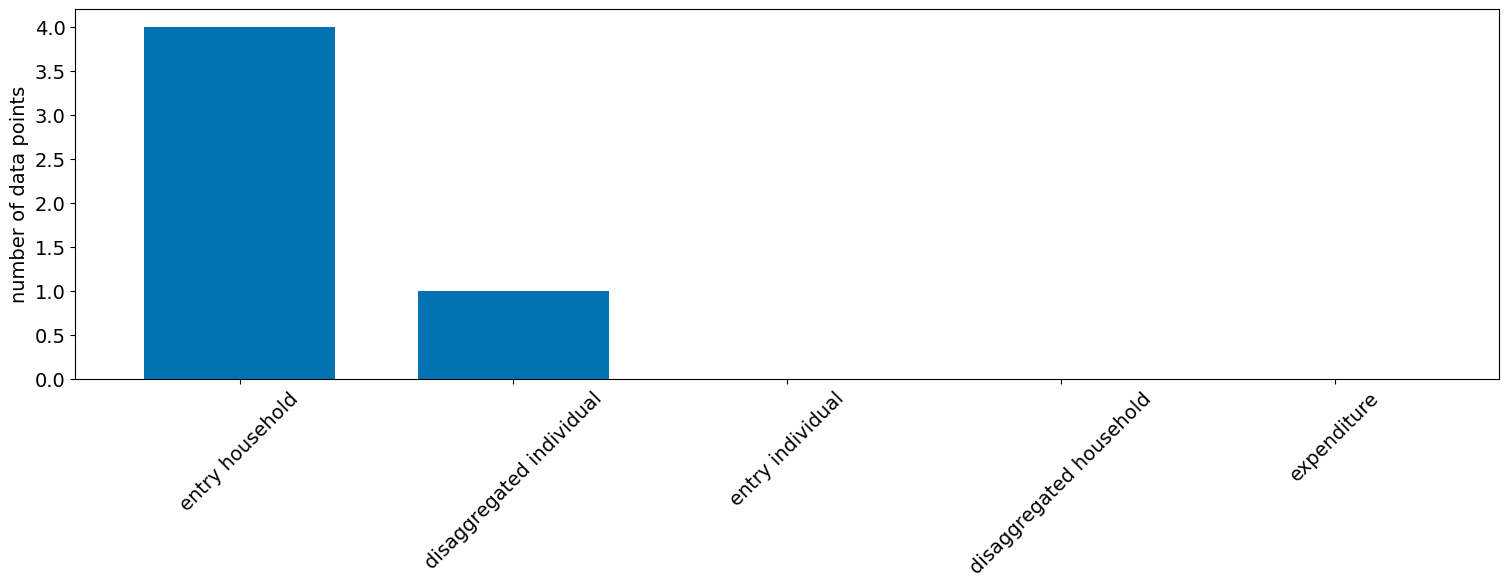

In [183]:
# Define your custom order
custom_order = ['Europe countries','CIS countries', 'Asia & Pacific', 'The Americas', 'Arab States', 'Africa']

custom_colors = [
    '#0072B2',  # Blue
    '#CC79A7',  # Pink/Purple
    '#009E73',  # Green
    '#F0E442',  # Yellow
    '#56B4E9',  # Light Blue
    '#E69F00'#,  # Orange
    ]

rename_dict = {
    'entry_household_5y': 'entry household',
    'entry_individual_5y': 'entry individual',
    'disaggregated_household_5y': 'disaggregated household',
    'disaggregated_individual_5y': 'disaggregated individual',
    'expenditure_5y': 'expenditure',
}

df[['entry_household_5y',
    'entry_individual_5y',
    'disaggregated_household_5y',
    'disaggregated_individual_5y',
    'expenditure_5y']].rename(
     columns=rename_dict)[df.shortname==country_name].rename(
     columns=rename_dict).reset_index().T.drop("index").sort_values(by=[0], ascending=False).plot(kind='bar',
                                                  figsize=(15, 6),
                                                  color=custom_colors,
                                                  width=0.7)

#plt.title('Average number of data points per group of indicator in the past 5 years (2020-2024)')
plt.xlabel('')
plt.ylabel('number of data points',fontsize=14)
plt.xticks(rotation=45,fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')

# Step 1: Get current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Step 2: Create a dict for easy lookup
label_to_handle = dict(zip(labels, handles))

plt.legend().remove()

# Make more room at the bottom
plt.subplots_adjust(bottom=0.7)  # increase as needed


plt.tight_layout()
plt.show()

In [184]:

rename_dict = {
    'timeliness_hh1': 'HH1',
    'timeliness_hh2': 'HH2',
    'timeliness_hh3': 'HH3',
    'timeliness_hh4': 'HH4',
    'timeliness_hh5': 'HH5',
    'timeliness_hh6': 'HH6',
    'timeliness_hh7': 'HH7',
    'timeliness_hh8': 'HH8',
    'timeliness_hh9': 'HH9',
    'timeliness_hh10': 'HH10',
    'timeliness_hh11': 'HH11',
    'timeliness_hh12': 'HH12',
    'timeliness_hh13': 'HH13',
    'timeliness_hh14': 'HH14',
    'timeliness_hh15': 'HH15',
    'timeliness_hh16': 'HH16',
    'timeliness_hh17': 'HH17',
    'timeliness_hh18': 'HH18',
    'timeliness_hh19': 'HH19',
    'timeliness_hh20': 'HH20',
    'timeliness_hh21': 'HH21',
    'timeliness_hh22': 'HH22',
    'timeliness_hh23': 'HH23',
}

hh_timeliness = [f'timeliness_hh{i}' for i in range(1, 24)]
df_plot_t = df[hh_timeliness][df.shortname==country_name].rename(columns=rename_dict).reset_index().T.drop("index").sort_values(by=[0], ascending=True)

In [185]:
df_plot_t[0]= pd.to_numeric(df_plot_t[0], errors="coerce")

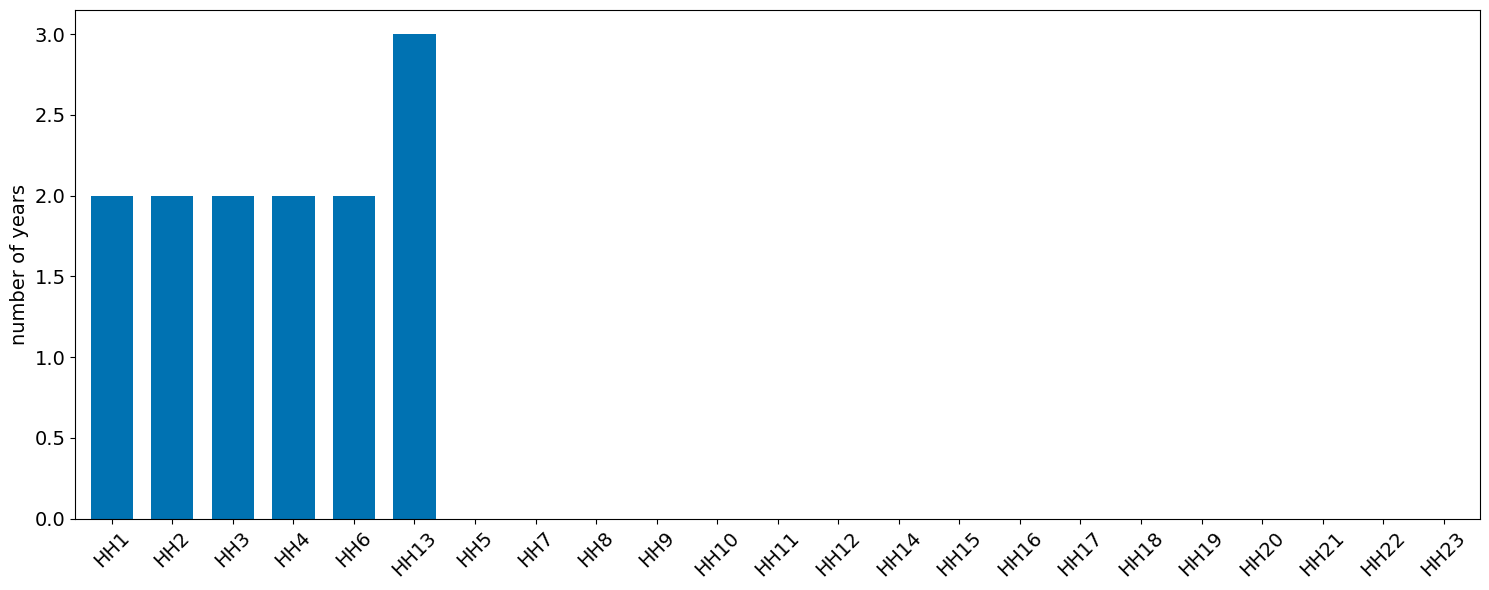

In [187]:
# Define your custom order
custom_order = ['Europe countries','CIS countries', 'Asia & Pacific', 'The Americas', 'Arab States', 'Africa']
#, 'Other Economies']

custom_colors = [
    '#0072B2',  # Blue
    '#CC79A7',  # Pink/Purple
    '#009E73',  # Green
    '#F0E442',  # Yellow
    '#56B4E9',  # Light Blue
    '#E69F00'  # Orange
    #'#696969'
    #'#999999',   # Grey
    ]



df_plot_t.plot(kind='bar',
                                                   stacked=False,
                                                   color=custom_colors,
                                                   figsize=(15, 6),
                                                   width=0.7)
#plt.title('Timeliness in 2025: average time lag of data points in number of years (available data only)', fontsize=12)
plt.xlabel('')
plt.ylabel('number of years', fontsize=14)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')

# Step 1: Get current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

plt.legend().remove()

# Step 2: Create a dict for easy lookup
label_to_handle = dict(zip(labels, handles))


plt.tight_layout()
plt.show()

In [188]:

rename_dict = {
    'timeliness_entry_household': 'entry household',
    'timeliness_entry_individual': 'entry individual',
    'timeliness_disaggregated_household': 'disaggregated household',
    'timeliness_disaggregated_individual': 'disaggregated individual',
    'timeliness_expenditure': 'expenditure',
}

hh_timeliness_new = ['timeliness_entry_household',
    'timeliness_entry_individual',
    'timeliness_disaggregated_household',
    'timeliness_disaggregated_individual',
    'timeliness_expenditure']

df_plot_t_g = df[hh_timeliness_new][df.shortname=='Brazil'].rename(columns=rename_dict).reset_index().T.drop("index").sort_values(by=[0], ascending=True)
df_plot_t_g[0]= pd.to_numeric(df_plot_t_g[0], errors="coerce")

df_plot_t_g

,0
entry household,1.0
entry individual,1.0
disaggregated household,1.0
disaggregated individual,1.0
expenditure,NaN


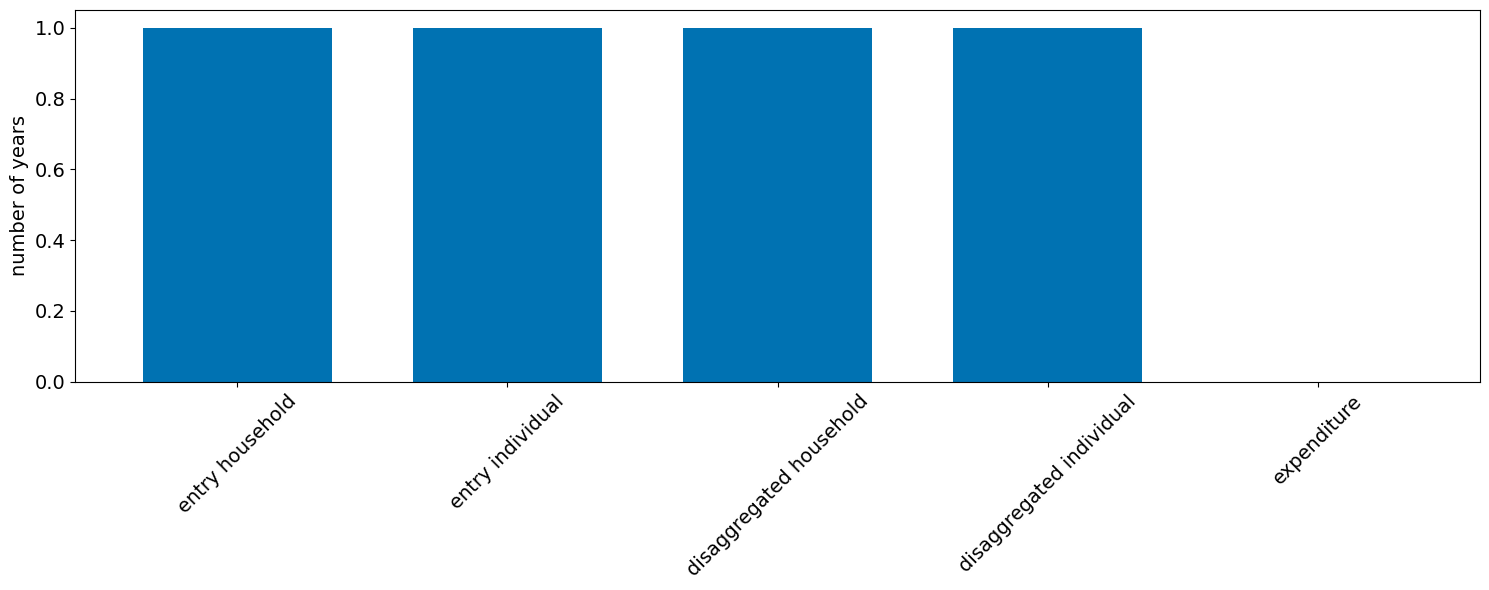

In [189]:
# Define your custom order
custom_order = ['Europe countries','CIS countries', 'Asia & Pacific', 'The Americas', 'Arab States', 'Africa']

custom_colors = [
    '#0072B2',  # Blue
    '#CC79A7',  # Pink/Purple
    '#009E73',  # Green
    '#F0E442',  # Yellow
    '#56B4E9',  # Light Blue
    '#E69F00'  # Orange
    #'#696969'
    #'#999999',   # Grey
    ]


df_plot_t_g.plot(kind='bar',
                                                   stacked=False,
                                                   color=custom_colors,
                                                   figsize=(15, 6),
                                                   width=0.7)
#plt.title('Timeliness in 2025: average time lag of data points for indicator group in number of years (available data only)', fontsize=12)
plt.xlabel('')
plt.ylabel('number of years', fontsize=14)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')

# Step 1: Get current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

plt.legend().remove()

# Step 2: Create a dict for easy lookup
label_to_handle = dict(zip(labels, handles))

# Make more room at the bottom
plt.subplots_adjust(bottom=0.35)  # increase as needed


plt.tight_layout()
plt.show()

# PRIORITY COUNTRIES LIST

Redo the analysis this time by counting missing values as 0 for the groups -- much easier to identify priority countries based on this.

In [141]:
df[['entry_household_5y',
    'entry_individual_5y',
    'disaggregated_household_5y',
    'disaggregated_individual_5y',
    'expenditure_5y']] = df[['entry_household_5y',
    'entry_individual_5y',
    'disaggregated_household_5y',
    'disaggregated_individual_5y',
    'expenditure_5y']].fillna(0)

In [143]:
df[['shortname',
 'regionname', 'new_group', 'wb_income', 'entry_household_5y',
    'entry_individual_5y',
    'disaggregated_household_5y',
    'disaggregated_individual_5y',
    'expenditure_5y']][
        ((df.regionname != 'Other Economies') & (df.new_group != 'Developed-OECD') & (df.shortname.notna() )) &
        ((df.entry_household_5y <1) |
         (df.entry_individual_5y <1) |
         (df.disaggregated_household_5y <1) |
         (df.disaggregated_individual_5y <1) |
         (df.expenditure_5y <1))
        ].sort_values (by=['regionname', 'shortname']
                       ).reset_index(
    drop=True
)

,shortname,regionname,new_group,wb_income,entry_household_5y,entry_individual_5y,disaggregated_household_5y,disaggregated_individual_5y,expenditure_5y
0,Angola,Africa,SIDS + LDC,Lower middle income,0.0,0.0,0.0,0.0,0.0
1,Benin,Africa,SIDS + LDC,Lower middle income,1.0,0.0,0.0,0.0,0.0
2,Botswana,Africa,Other developing and transition,Upper middle income,0.0,0.0,0.0,0.0,0.0
3,Burkina Faso,Africa,SIDS + LDC,Low income,0.0,0.0,0.0,0.0,0.0
4,Burundi,Africa,SIDS + LDC,Low income,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
145,Uruguay,The Americas,Other developing and transition,High income,2.0,2.0,2.0,2.0,0.0
146,Venezuela,The Americas,Other developing and transition,NaN,0.0,0.0,0.0,0.0,0.0
147,Guadeloupe,NaN,Other developing and transition,NaN,0.0,0.0,0.0,0.0,0.0
148,Martinique,NaN,Other developing and transition,NaN,0.0,0.0,0.0,0.0,0.0


In [144]:
# Africa only

df[['shortname',
 'regionname', 'new_group', 'wb_income', 'entry_household_5y',
    'entry_individual_5y',
    'disaggregated_household_5y',
    'disaggregated_individual_5y',
    'expenditure_5y']][
        ((df.regionname == 'Africa') & (df.new_group != 'Developed-OECD') & (df.shortname.notna() )) &
        ((df.entry_household_5y <1) |
         (df.entry_individual_5y <1) |
         (df.disaggregated_household_5y <1) |
         (df.disaggregated_individual_5y <1) |
         (df.expenditure_5y <1))
        ].sort_values (by=['regionname', 'shortname']
                       ).reset_index(
    drop=True
)

,shortname,regionname,new_group,wb_income,entry_household_5y,entry_individual_5y,disaggregated_household_5y,disaggregated_individual_5y,expenditure_5y
0,Angola,Africa,SIDS + LDC,Lower middle income,0.0,0.0,0.0,0.0,0.0
1,Benin,Africa,SIDS + LDC,Lower middle income,1.0,0.0,0.0,0.0,0.0
2,Botswana,Africa,Other developing and transition,Upper middle income,0.0,0.0,0.0,0.0,0.0
3,Burkina Faso,Africa,SIDS + LDC,Low income,0.0,0.0,0.0,0.0,0.0
4,Burundi,Africa,SIDS + LDC,Low income,1.0,1.0,0.0,1.0,0.0
5,Cabo Verde,Africa,SIDS + LDC,Lower middle income,0.0,0.0,0.0,0.0,0.0
6,Cameroon,Africa,Other developing and transition,Lower middle income,0.0,0.0,0.0,0.0,0.0
7,Central African Rep.,Africa,SIDS + LDC,Low income,0.0,0.0,0.0,0.0,0.0
8,Chad,Africa,SIDS + LDC,Low income,0.0,0.0,0.0,0.0,0.0
9,Congo (Rep. of the),Africa,Other developing and transition,Lower middle income,0.0,0.0,0.0,0.0,0.0


In [145]:
# leave expenditure asside

df[['shortname',
 'regionname', 'new_group', 'wb_income', 'entry_household_5y',
    'entry_individual_5y',
    'disaggregated_household_5y',
    'disaggregated_individual_5y',
    'expenditure_5y']][
        ((df.regionname != 'Other Economies') & (df.new_group != 'Developed-OECD') & (df.shortname.notna() )) &
        ((df.entry_household_5y <1) |
         (df.entry_individual_5y <1) |
         (df.disaggregated_household_5y <1) |
         (df.disaggregated_individual_5y <1) )
        ].sort_values (by=['regionname', 'shortname']
                       ).reset_index(
    drop=True
)

,shortname,regionname,new_group,wb_income,entry_household_5y,entry_individual_5y,disaggregated_household_5y,disaggregated_individual_5y,expenditure_5y
0,Angola,Africa,SIDS + LDC,Lower middle income,0.0,0.0,0.0,0.0,0.0
1,Benin,Africa,SIDS + LDC,Lower middle income,1.0,0.0,0.0,0.0,0.0
2,Botswana,Africa,Other developing and transition,Upper middle income,0.0,0.0,0.0,0.0,0.0
3,Burkina Faso,Africa,SIDS + LDC,Low income,0.0,0.0,0.0,0.0,0.0
4,Burundi,Africa,SIDS + LDC,Low income,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
111,Trinidad and Tobago,The Americas,SIDS + LDC,High income,2.0,1.0,0.0,1.0,0.0
112,Venezuela,The Americas,Other developing and transition,NaN,0.0,0.0,0.0,0.0,0.0
113,Guadeloupe,NaN,Other developing and transition,NaN,0.0,0.0,0.0,0.0,0.0
114,Martinique,NaN,Other developing and transition,NaN,0.0,0.0,0.0,0.0,0.0


In [146]:
# leave expenditure asside

df[['shortname',
 'regionname', 'new_group', 'wb_income', 'timeliness_entry_household',
    'timeliness_entry_individual',
    #'timeliness_disaggregated_household',
    'timeliness_disaggregated_individual',
    #'timeliness_expenditure'
    ]][
        ((df.regionname != 'Other Economies') & (df.new_group != 'Developed-OECD') & (df.shortname.notna() )) &
        ((df.entry_household_5y <1) |
         (df.entry_individual_5y <1) |
         (df.disaggregated_household_5y <1) |
         (df.disaggregated_individual_5y <1) )
        ].sort_values (by=['regionname', 'shortname']
                       ).reset_index(
    drop=True
).fillna(6)

,shortname,regionname,new_group,wb_income,timeliness_entry_household,timeliness_entry_individual,timeliness_disaggregated_individual
0,Angola,Africa,SIDS + LDC,Lower middle income,6,6,6
1,Benin,Africa,SIDS + LDC,Lower middle income,3,6,6
2,Botswana,Africa,Other developing and transition,Upper middle income,6,6,6
3,Burkina Faso,Africa,SIDS + LDC,Low income,6,6,6
4,Burundi,Africa,SIDS + LDC,Low income,5,5,5
...,...,...,...,...,...,...,...
111,Trinidad and Tobago,The Americas,SIDS + LDC,High income,3,4,4
112,Venezuela,The Americas,Other developing and transition,6,6,6,6
113,Guadeloupe,6,Other developing and transition,6,6,6,6
114,Martinique,6,Other developing and transition,6,6,6,6


In [147]:
# leave expenditure asside

df[['shortname',
 'regionname', 'new_group', 'wb_income', 'timeliness_entry_household',
    'timeliness_entry_individual',
    #'timeliness_disaggregated_household',
    'timeliness_disaggregated_individual',
    #'timeliness_expenditure'
    ]][df.shortname.isin(['Philippines', 'Ukraine', 'Brazil', 'Panama', 'Peru'])].fillna(6)

,shortname,regionname,new_group,wb_income,timeliness_entry_household,timeliness_entry_individual,timeliness_disaggregated_individual
28,Brazil,The Americas,Other developing and transition,Upper middle income,1,1,1
164,Panama,The Americas,Other developing and transition,High income,6,2,6
167,Peru,The Americas,Other developing and transition,Upper middle income,1,1,1
168,Philippines,Asia & Pacific,Other developing and transition,Lower middle income,3,3,3
221,Ukraine,Europe countries,Other developing and transition,Lower middle income,4,4,4


In [150]:
# to check by country if something looks off
hh_cols = [f'hh{i}_5y' for i in range(1, 24)]
df[hh_cols][df.shortname=='Panama'].T

,164
hh1_5y,NaN
hh2_5y,NaN
hh3_5y,NaN
hh4_5y,NaN
hh5_5y,1.0
hh6_5y,NaN
hh7_5y,1.0
hh8_5y,NaN
hh9_5y,NaN
hh10_5y,1.0
